<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales - 2023</h1>
    <p>Docente: Rodrigo Del Rosso<p>
    <p>Asistentes: Sebastián Calcagno y Braian Drago <p>
    <p>Integrantes: Cerutti, Garcia Rio, Levit, Marchetta <p>
</div>

# Lectura y preparacion de los datos  <br>


In [ ]:
# Modulos a instalar
!pip install pmdarima
!pip install arch

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import scipy.stats
import pylab
import statsmodels.api as sm

In [ ]:
path ='/content/gdp-per-capita-world-bank-constant-usd.csv'
gdp = pd.read_csv(path, names=["Pais", "Moneda", "Anio", "Ingreso"])

In [ ]:
gdp = gdp[gdp['Pais'] == 'Argentina']
gdp.head()

Pais Moneda  Anio    Ingreso
284  Argentina    ARG  1960   7410.305
285  Argentina    ARG  1961  7687.5176
286  Argentina    ARG  1962    7498.84
287  Argentina    ARG  1963   6986.565
288  Argentina    ARG  1964   7572.231

In [ ]:
cols = ['Anio', 'Ingreso']
gdp = gdp.loc[:, cols]
gdp.head()

Anio    Ingreso
284  1960   7410.305
285  1961  7687.5176
286  1962    7498.84
287  1963   6986.565
288  1964   7572.231

In [ ]:
gdp['Anio'] = pd.to_datetime(gdp['Anio'], format='%Y')
gdp.set_index("Anio", inplace=True)

gdp.head()

Ingreso
Anio                 
1960-01-01   7410.305
1961-01-01  7687.5176
1962-01-01    7498.84
1963-01-01   6986.565
1964-01-01   7572.231

In [ ]:
gdp.dtypes

Ingreso    object
dtype: object

In [ ]:
gdp['Ingreso'] = gdp['Ingreso'].astype(float)

# Punto 2: Grafico de la serie y test de Fuller

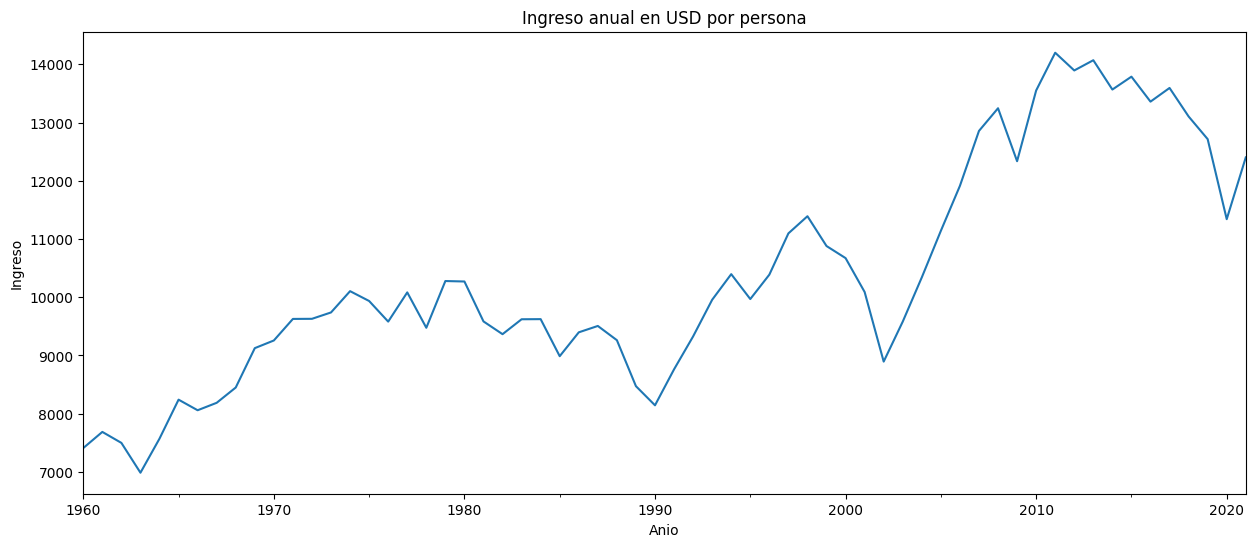

In [ ]:
gdp["Ingreso"].plot(figsize=(15, 6))
plt.xlabel("Anio")
plt.ylabel("Ingreso")
plt.title("Ingreso anual en USD por persona")
plt.show()

In [ ]:
adfuller(gdp['Ingreso'])

(-1.4335469352283639,
 0.5660918710260875,
 0,
 61,
 {'1%': -3.542412746661615,
  '5%': -2.910236235808284,
  '10%': -2.5927445767266866},
 783.6520587663022)

Dado el p-valor obtenido del test de fuller (0.56), no tenemos informacion suficiente para rechazar H0 (que indica la presencia de raices unitarias), por lo que sera necesario diferenciar la serie para volverla estacionaria.

# Punto 3: Grafico funciones de ACF y PACF. Analisis grafico.

<Figure size 1200x600 with 0 Axes>

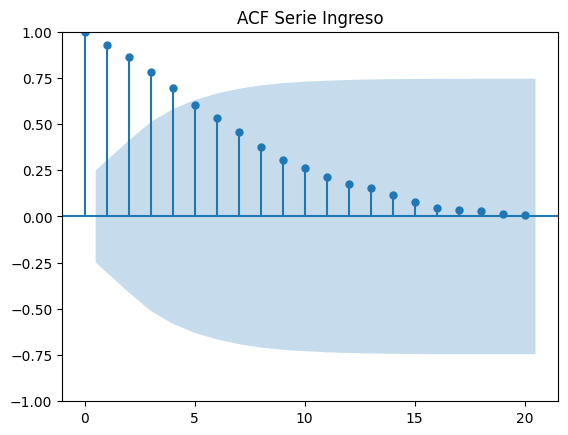

<Figure size 1200x600 with 0 Axes>

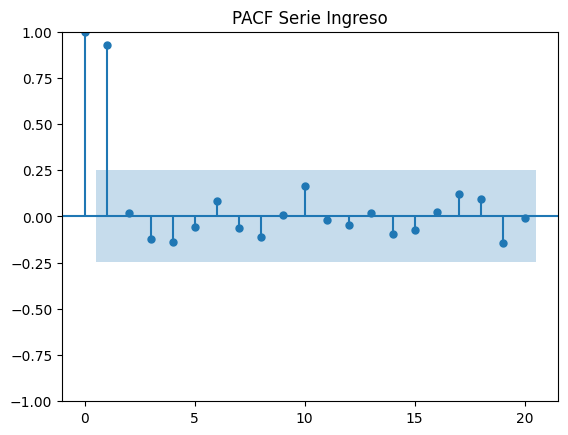

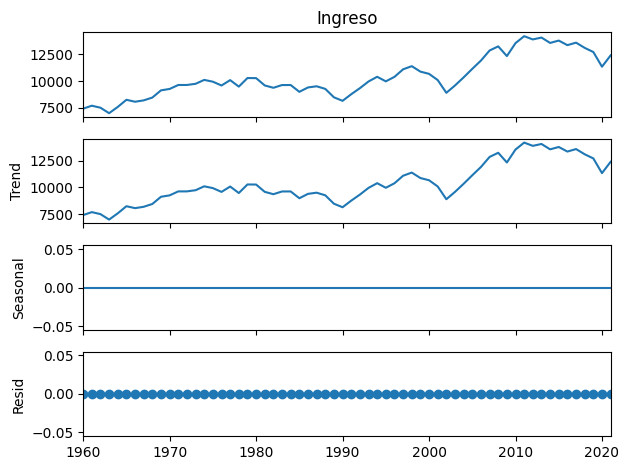

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(gdp['Ingreso'], lags=20, title='ACF Serie Ingreso')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(gdp['Ingreso'], lags=20, title='PACF Serie Ingreso')
plt.show()


s_dec_additive = seasonal_decompose(gdp.Ingreso, model = "adittive")
s_dec_additive.plot()
plt.show()

Con los graficos previos, podemos dar mayor soporte al resultado del test de fuller (no estacionariedad de la serie), dado el decrecimiento constante de la funcion de ACF.

Del grafico PACF podemos determinar que un modelo de orden 1 podria servir para modelar la serie (en caso que fuera estacionaria).

Finalmente, se agrego la descomposicion de la serie, donde podemos observar la presencia de tendencia, lo cual nuevamente da soporte al resultado de las concluciones anteriores.

# Punto 4: Pruebas de raices unitarias

In [ ]:
def estacionario(y):
  n_adf = ndiffs(y, test='adf')
  n_kpss = ndiffs(y, test='kpss')
  n_pp = ndiffs(y, test='pp')

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

In [ ]:
estacionario(gdp)

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.38163965033251734, True)


Se han realizado tres pruebas diferentes: Dickey-Fuller aumentada (ADF), Kwiatkowski-Phillips-Schmidt-Shin (KPSS) y Phillips-Perron (PP).

En este caso, todas las pruebas indican que se requiere una diferencia de orden 1 para lograr la estacionariedad en la serie de tiempo. Esto significa que, se debe aplicar una diferencia de primer orden (restar el valor actual del valor anterior) una vez. Después de aplicar esta diferencia, la serie debería ser estacionaria y adecuada para su análisis con modelos ARMA.

# Punto 5: Identificacion del Orden a utilizar

In [ ]:
# BOX & COX    => Mismo resultado
# from scipy import stats
# gdp_BoxCox = gdp.copy()
# transformacion_Box_Cox = np.asarray(gdp['Ingreso'].values)
# fitted_data, fitted_lambda = stats.boxcox(transformacion_Box_Cox)
# gdp['Ingreso'] = fitted_data

# Transformacion Logaritmica    => Mismo resultado
#gdp['Ingreso'] = np.log(gdp['Ingreso'])

#Removicion de tendencia (diferenciacion)    => Aplicando esto no hace falta diferenciar luego
# gdp['Ingreso'] = gdp['Ingreso'].diff().dropna()


# Box-Jenkins
# exponential_smoothing = sm.tsa.ExponentialSmoothing(gdp, trend='add', seasonal=None)
# fitted_model = exponential_smoothing.fit()
# smoothed_data = fitted_model.fittedvalues
# gdp['Ingreso'] = smoothed_data

# Transformacion Raiz cuadrada    => Mismo resultado
# gdp['Ingreso'] = np.sqrt(gdp['Ingreso'])

# Transformacion de potencia    => Mismo resultado
# power = 0.5
# gdp['Ingreso'] = np.power(gdp['Ingreso'], power)

# gdp.head()

In [ ]:
auto_arima(gdp, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True, information_criterion='aic').summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=950.129, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=953.514, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=953.547, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=949.397, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=951.868, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=951.926, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=953.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=951.895, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=951.850, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=953.762, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.400 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -473.698
Date:                Tue, 07 Nov 2023   AIC                            949.397
Time:                        22:00:25   BIC                            951.508
Sample:                    01-01-1960   HQIC                           950.224
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.255e+05   7.12e+04      4.568      0.000    1.86e+05    4.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.70   Prob(JB):                         0.46
Heteroskedasticity (H):               3.34   Skew:                            -0.31
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima(gdp, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True, information_criterion='bic').summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=954.351, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=961.957, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=961.990, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=951.508, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : BIC=958.200, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : BIC=958.259, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : BIC=961.943, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=958.227, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=958.183, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : BIC=962.206, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.025 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -473.698
Date:                Tue, 07 Nov 2023   AIC                            949.397
Time:                        22:00:27   BIC                            951.508
Sample:                    01-01-1960   HQIC                           950.224
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.255e+05   7.12e+04      4.568      0.000    1.86e+05    4.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.70   Prob(JB):                         0.46
Heteroskedasticity (H):               3.34   Skew:                            -0.31
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima(gdp, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True, information_criterion='aicc').summary()

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AICC=950.332, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AICC=954.215, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AICC=954.249, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AICC=949.464, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AICC=952.282, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AICC=952.340, Time=0.14 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AICC=954.201, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AICC=952.308, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AICC=952.264, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AICC=954.464, Time=0.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.660 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -473.698
Date:                Tue, 07 Nov 2023   AIC                            949.397
Time:                        22:00:30   BIC                            951.508
Sample:                    01-01-1960   HQIC                           950.224
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.255e+05   7.12e+04      4.568      0.000    1.86e+05    4.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.70   Prob(JB):                         0.46
Heteroskedasticity (H):               3.34   Skew:                            -0.31
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima(gdp, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True, information_criterion='hqic').summary()

Performing stepwise search to minimize hqic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : HQIC=951.783, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : HQIC=956.823, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : HQIC=956.856, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[7]             : HQIC=950.224, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : HQIC=954.350, Time=0.18 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : HQIC=954.408, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : HQIC=956.808, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : HQIC=954.376, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : HQIC=954.332, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : HQIC=957.071, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 3.010 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -473.698
Date:                Tue, 07 Nov 2023   AIC                            949.397
Time:                        22:00:33   BIC                            951.508
Sample:                    01-01-1960   HQIC                           950.224
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.255e+05   7.12e+04      4.568      0.000    1.86e+05    4.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.70   Prob(JB):                         0.46
Heteroskedasticity (H):               3.34   Skew:                            -0.31
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima(gdp, trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=957.269, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=950.129, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=951.895, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=951.850, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=949.397, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=953.762, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.632 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

En este caso, el modelo seleccionado es ARIMA(0,1,0)(0,0,0)[0], que significa que se trata de un modelo sin términos autoregresivos ni de media móvil, con una diferenciación no estacional de primer orden (d=1), y sin una periodicidad estacional.

Vemos que para todos los criterios de informacion aplicados este es el modelo selecto, y podemos observar que la salida no muestra coeficientes específicos para términos AR ni MA, por lo que no hay coeficientes individuales que evaluar en términos de significatividad para estos términos.

# Punto 6: Performance en train/test

In [ ]:
gdp.tail()

Ingreso
Anio                 
2017-01-01  13595.037
2018-01-01  13105.397
2019-01-01  12716.225
2020-01-01  11341.269
2021-01-01  12402.491

In [ ]:
train = gdp['1960-01-01':'2009-01-01']
test = gdp['2010-01-01':]

auto_arima_model = sm.tsa.SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
auto_arima_results = auto_arima_model.fit()

auto_arima_predictions = auto_arima_results.get_forecast(steps=len(test))

auto_arima_forecasted_values = auto_arima_predictions.predicted_mean
confidence_intervals = auto_arima_predictions.conf_int()

mse = mean_squared_error(test, auto_arima_forecasted_values)
mae = mean_absolute_error(test, auto_arima_forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error cuadrático medio (MSE): 1530899.4389993353
Error Absoluto Medio (MAE): 1128.7695000000008


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Podemos observar un MSE (Error cuadratico medio) de 1530899.43 USD y un MAE (Error absoluto medio) del 1128.76 USD. Procederemos en el punto siguinte a calcular estas metricas para otros modelos y realizar comparaciones con los obtenidos en este punto.

# Punto 7: Compracion con otros modelos

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cargar los datos y preparar la serie temporal
# (El código para cargar y preparar los datos permanece igual)

# Función para encontrar el mejor modelo SARIMA basado en AIC
def find_best_sarima(train_data, p_values, d_values, q_values, P_values, D_values, Q_values, M_values):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in M_values:
                                order = (p, d, q)
                                seasonal_order = (P, D, Q, m)
                                try:
                                    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
                                    results = model.fit(disp=False)
                                    aic = results.aic
                                    if aic < best_aic:
                                        best_aic = aic
                                        best_order = order
                                        best_seasonal_order = seasonal_order
                                except:
                                    continue

    return best_order, best_seasonal_order, best_aic

# Define los rangos de órdenes de parámetros a considerar
p_values = range(0, 3)
d_values = [1]
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
M_values = range(2, 7)

# Encuentra el mejor modelo SARIMA basado en AIC
best_order_aic, best_seasonal_order_aic, best_aic = find_best_sarima(train, p_values, d_values, q_values, P_values, D_values, Q_values, M_values)

# Imprime los resultados
print("Mejor modelo SARIMA basado en AIC:")
print(f"Orden de parámetros: {best_order_aic}")
print(f"Orden de parámetros estacional: {best_seasonal_order_aic}")
print(f"AIC: {best_aic}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be use

Mejor modelo SARIMA basado en AIC:
Orden de parámetros: (0, 1, 1)
Orden de parámetros estacional: (1, 1, 2, 6)
AIC: 681.8409026747115


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mediante la ejecucion del codigo anterior, se puedo identificar un modelo distinto. En este caso enforce la diferenciacion dado los tests corridos anteriormente.

# Punto 8: Analsis de residuos del modelo

Dado que en el punto anterior he encontrado un modelo que posee mejore metrica de error, pero aun mas importante dado que incluye coeficientes AR y MA, continuare el analisis con este modelo.
Realizare algunas moficaciones (como parte del punto 8), para ir ajustando los lags a utilizar en funcion de las significancia de los coeficientes del modelo, pero tambien del test de Ljung-Box (el cual me permite identificar si algunos lags puede tener incidencia en valores futuros).

In [ ]:
order = ((0, 1), 1, 1)
seasonal_order = (0, 1, 0, 2)
# seasonal_order = (1, 1, 2, 6)

# Crea el modelo SARIMA sin el coeficiente no significativo
model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)

# Ajusta el modelo a los datos
results = model.fit()

# Muestra el nuevo resumen del modelo
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              Ingreso   No. Observations:                   50
Model:             SARIMAX([2], 1, 1)x(0, 1, [], 2)   Log Likelihood                -371.680
Date:                              Tue, 07 Nov 2023   AIC                            749.360
Time:                                      22:06:13   BIC                            754.910
Sample:                                  01-01-1960   HQIC                           751.448
                                       - 01-01-2009                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.4310      0.173     -2.493      0.013      -0.770      -0.092
ma.L1          0.30

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


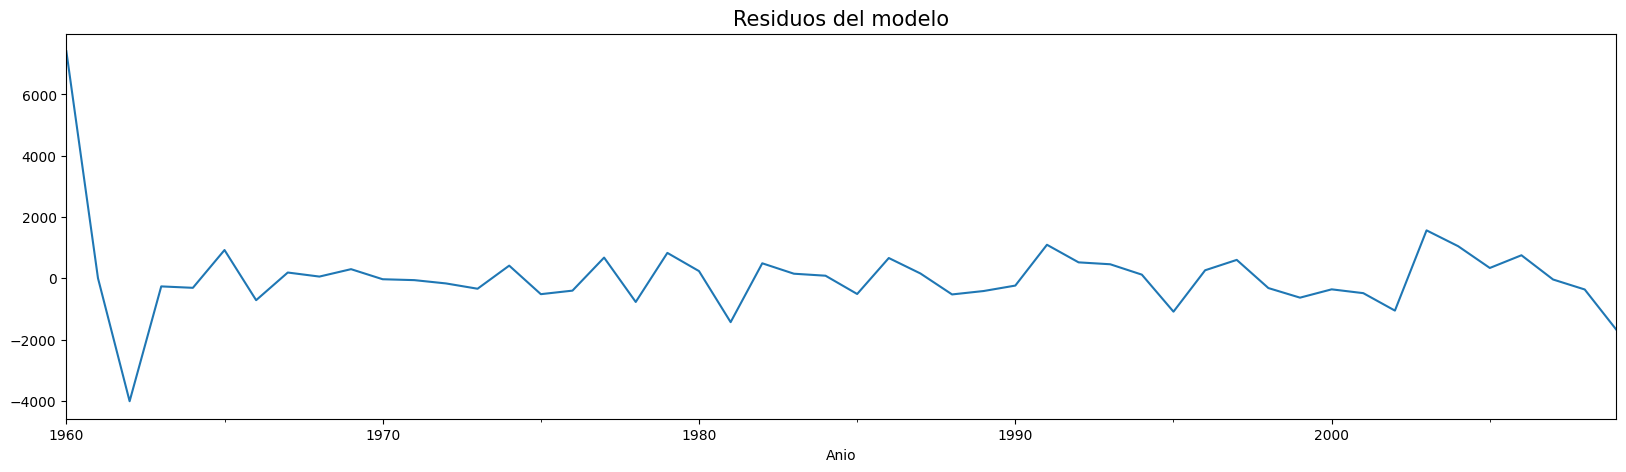

In [ ]:
results.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=15)
plt.show()

<ipython-input-93-964e5b8052da>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid, bins=15, color='#fcba03')


Text(0.5, 1.0, 'Histograma de los residuos del modelo')

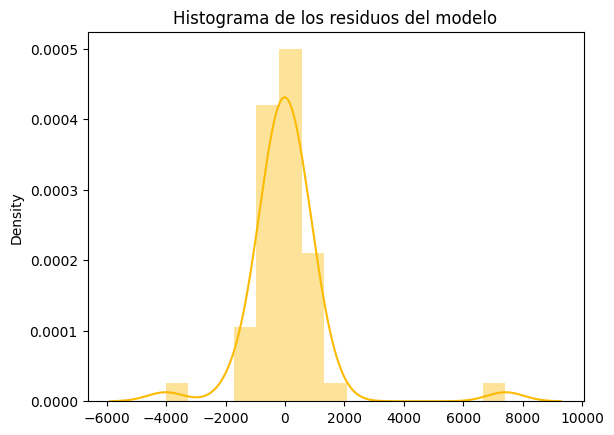

In [ ]:
sns.distplot(results.resid, bins=15, color='#fcba03')
plt.title('Histograma de los residuos del modelo')

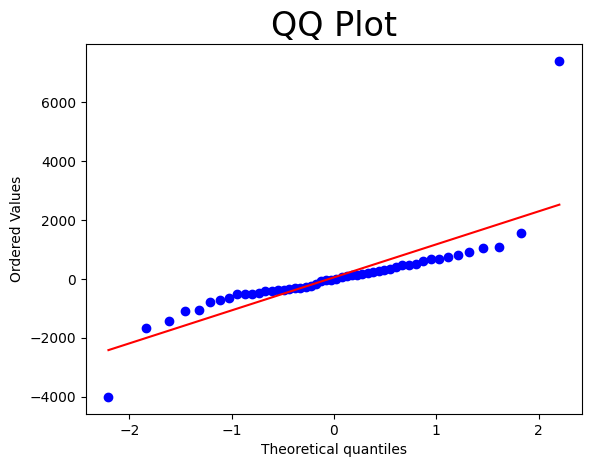

In [ ]:
scipy.stats.probplot(results.resid, plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

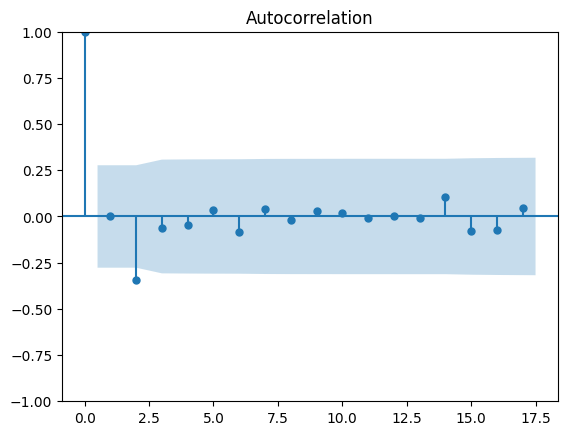

In [ ]:
plot_acf(results.resid);

In [ ]:
Incorr_residuos_modelo=sm.stats.acorr_ljungbox(results.resid, lags=30)
Incorr_residuos_modelo



lb_stat  lb_pvalue
1    0.001039   0.974291
2    6.313107   0.042572
3    6.545495   0.087885
4    6.671913   0.154276
5    6.740825   0.240640
6    7.142832   0.307840
7    7.254880   0.402833
8    7.281613   0.506576
9    7.336055   0.602175
10   7.353687   0.691686
11   7.357463   0.769441
12   7.358977   0.833008
13   7.365362   0.882355
14   8.191901   0.879091
15   8.658766   0.894673
16   9.057623   0.911022
17   9.208678   0.933487
18   9.984992   0.932395
19  11.506014   0.905642
20  11.509772   0.931917
21  12.394123   0.928362
22  12.410242   0.948318
23  12.423239   0.963411
24  12.437777   0.974512
25  13.084729   0.975446
26  14.050128   0.972334
27  14.207448   0.979146
28  14.300995   0.984912
29  14.971923   0.985232
30  15.722624   0.984971

Text(0, 0.5, 'P-valores ')

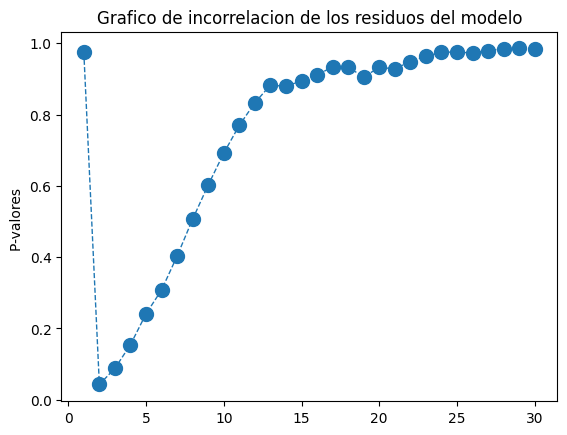

In [ ]:
plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo")
plt.ylabel("P-valores ")

Finalmente, el modelo seleccionado es el siguiente:

* sm.tsa.SARIMAX(train, order=((0, 1), 1, 1), seasonal_order=(0, 1, 0, 2))

Dado que los residuos parecen tener una distribucion cerca a una normal, y que los residuos estan casi en su totalidad incorrelacionados (con excepcion del lag 2, por este motivo incluimos el coeficiente autoregresivo 2).

Continuaremos realizando el analisis con dicho modelo, con el objetivo de evaluar en el punto siguiente su performance utilizando algunas metricas de inters.

# Punto 9: Pronostico

Pronostico con el ultimo modelo seleccionado:

In [ ]:
predictions = results.get_forecast(steps=len(test))

forecasted_values = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

mse = mean_squared_error(test, forecasted_values)
mae = mean_absolute_error(test, forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error cuadrático medio (MSE): 2391571.0726596075
Error Absoluto Medio (MAE): 1465.0410791972015


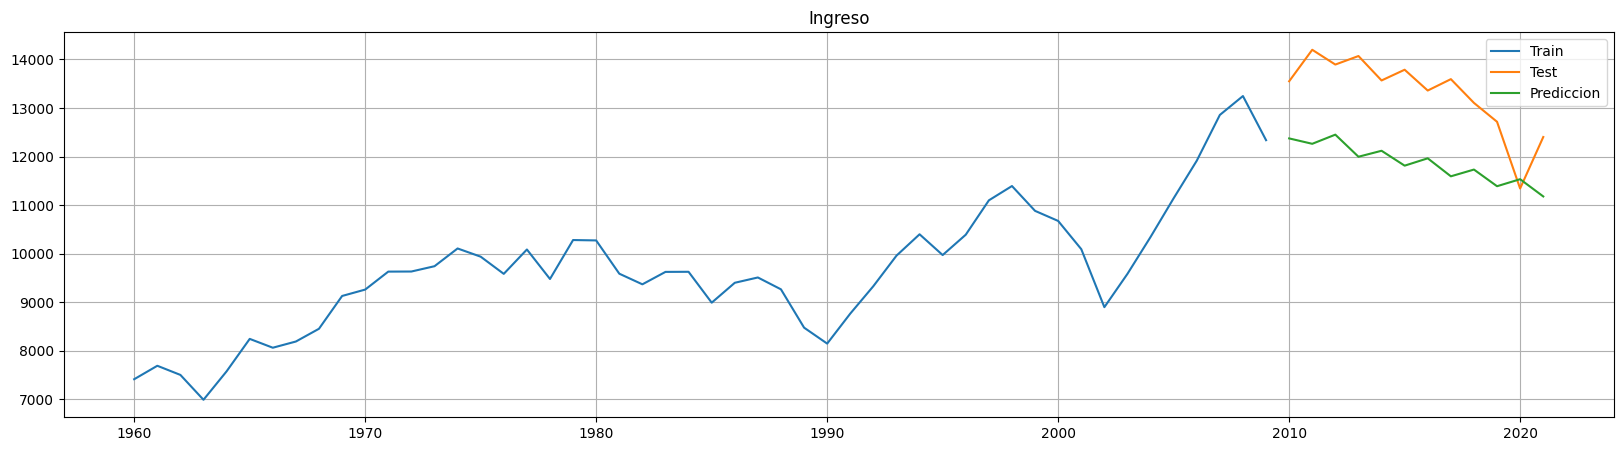

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Ingreso'], label='Train')
plt.plot(test['Ingreso'], label='Test')
plt.plot(forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('Ingreso')
plt.show()

Grafico el prnostico realizado con el modelo sugerido por auto arima:

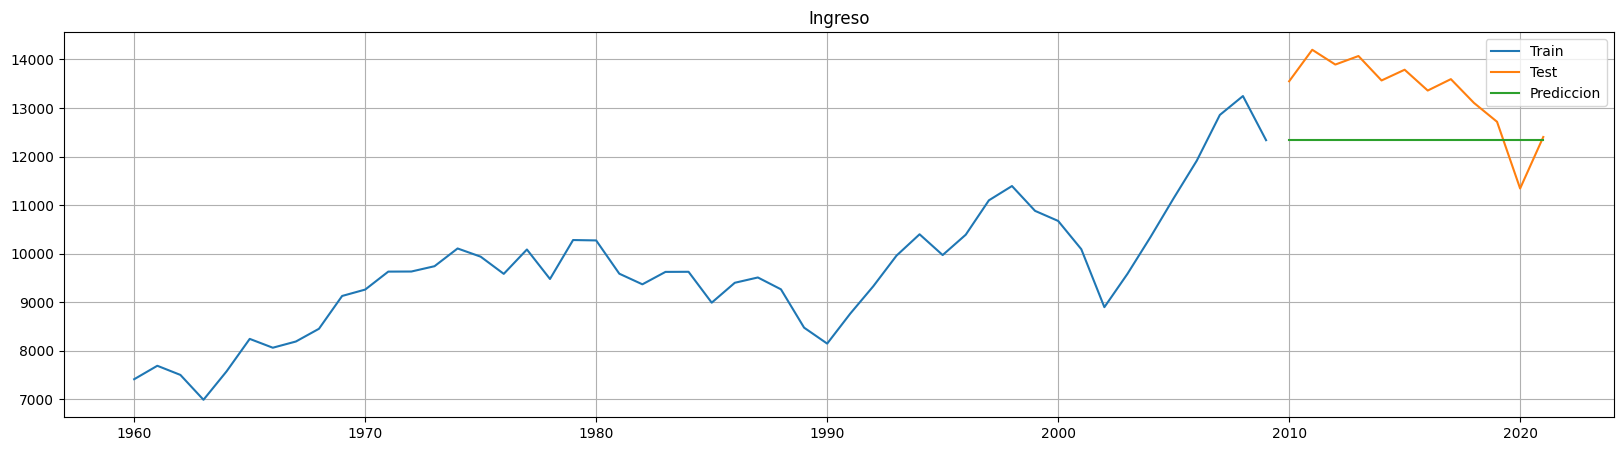

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Ingreso'], label='Train')
plt.plot(test['Ingreso'], label='Test')
plt.plot(auto_arima_forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('Ingreso')
plt.show()

De lo anterior podemos concluir que si bien el modelo sugerido por auto arima tiene (por poco) un mejor MAE y MSE, este predice un valor continuo, mientras que el modelo que planteamos nosotros, parece detectar la tendencia de la serie.

Por lo que seria aconsejable en este escenario continuar con el modelo que nosotros planteamos, quizas aplicando alguna transformacion, se pueda mejorar aun mas las predicciones.

A continuacion intentaremos mejorar estas predicciones utilizando box & cox:

In [ ]:
from scipy import stats
gdp_BoxCox = gdp.copy()

transformacion_Box_Cox = np.asarray(gdp['Ingreso'].values)
fitted_data, fitted_lambda = stats.boxcox(transformacion_Box_Cox)
gdp_BoxCox['Ingreso'] = fitted_data

gdp_BoxCox.head()

Ingreso
Anio                
1960-01-01  2.177155
1961-01-01  2.177809
1962-01-01  2.177367
1963-01-01  2.176082
1964-01-01  2.177541

In [ ]:
train_cox = gdp_BoxCox['1960-01-01':'2009-01-01']
test_cox = gdp_BoxCox['2010-01-01':]

In [ ]:
from scipy.special import inv_boxcox

model_cox = sm.tsa.SARIMAX(train_cox, order=order, seasonal_order=seasonal_order)
results_cox = model.fit()

print(results.summary())

predictions_cox = results_cox.get_forecast(steps=len(test_cox))

forecasted_values_cox = predictions_cox.predicted_mean
confidence_intervals = predictions_cox.conf_int()

mse = mean_squared_error(test_cox, forecasted_values_cox)
mae = mean_absolute_error(test_cox, forecasted_values_cox)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")


                                      SARIMAX Results                                       
Dep. Variable:                              Ingreso   No. Observations:                   50
Model:             SARIMAX([2], 1, 1)x(0, 1, [], 2)   Log Likelihood                -371.680
Date:                              Tue, 07 Nov 2023   AIC                            749.360
Time:                                      22:06:16   BIC                            754.910
Sample:                                  01-01-1960   HQIC                           751.448
                                       - 01-01-2009                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.4310      0.173     -2.493      0.013      -0.770      -0.092
ma.L1          0.30

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


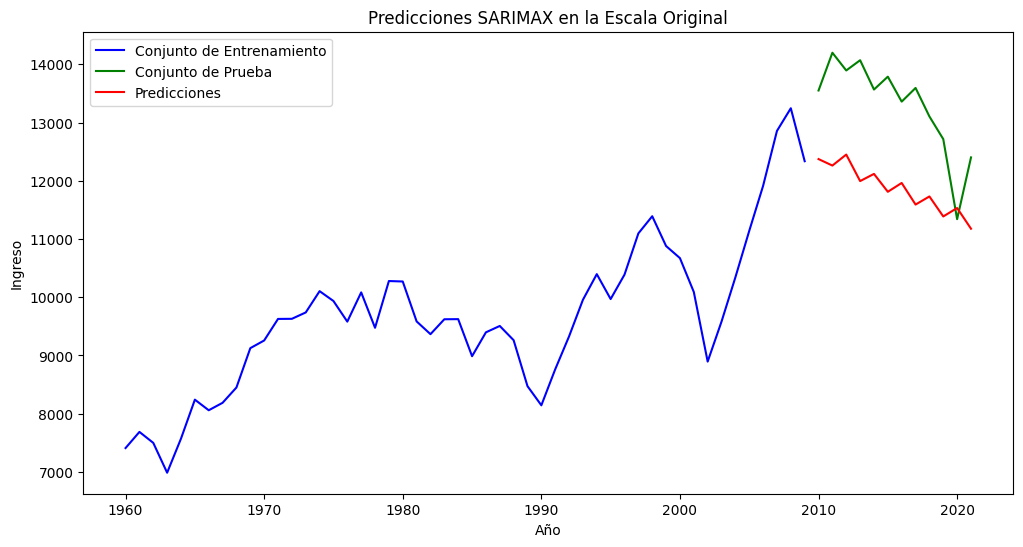

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Invertir la transformación Box-Cox en los datos de entrenamiento, prueba y predicciones
train_original = train
test_original = test
forecasted_values_original = forecasted_values_cox

# Crear un gráfico
plt.figure(figsize=(12, 6))

# Graficar el conjunto de entrenamiento en la escala original
plt.plot(train_original.index, train_original['Ingreso'], label='Conjunto de Entrenamiento', color='blue')

# Graficar el conjunto de prueba en la escala original
plt.plot(test_original.index, test_original['Ingreso'], label='Conjunto de Prueba', color='green')

# Graficar las predicciones en la escala original
plt.plot(test_cox.index, forecasted_values_original, label='Predicciones', color='red')

# Rellenar el área entre los intervalos de confianza en la escala original
lower_bound_original = np.exp(confidence_intervals.iloc[:, 0])
upper_bound_original = np.exp(confidence_intervals.iloc[:, 1])
plt.fill_between(test_cox.index, lower_bound_original, upper_bound_original, color='pink', alpha=0.5)

# Configurar el título y las etiquetas de los ejes
plt.title('Predicciones SARIMAX en la Escala Original')
plt.xlabel('Año')
plt.ylabel('Ingreso')
plt.legend()

# Mostrar el gráfico
plt.show()


Vemos que sucede lo mismo que sin aplicar la transformacion, pero la tendencia parece replicarse mejor, por eso los MAE/MSE son menores. Continuaremos con este modelo desde ahora en adelante.

# Punto 10: Construccion del modelo VAR


In [ ]:
gdp.head()

Ingreso
Anio                 
1960-01-01  7410.3050
1961-01-01  7687.5176
1962-01-01  7498.8400
1963-01-01  6986.5650
1964-01-01  7572.2310

In [ ]:
#path_population ='/content/population-and-demography.csv'
path_population ='/content/Poblacion.csv'
path_energy ='/content/per-capita-energy-use.csv'

population = pd.read_csv(path_population, sep=";")
energy = pd.read_csv(path_energy)

population.head()

Year       Pais     Hombres     Mujeres   Población
0  2021  Argentina  22.678.199  23.130.548  45.808.747
1  2020  Argentina  22.465.694  22.911.069  45.376.763
2  2019  Argentina  22.249.019  22.689.693  44.939.000
3  2018  Argentina  22.027.014  22.467.488  44.495.000
4  2017  Argentina  21.800.696  22.244.116  44.045.000

In [ ]:
energy.head()

Entity Code  Year  Primary energy consumption per capita (kWh/person)
0  Afghanistan  AFG  1980                                          623.92865 
1  Afghanistan  AFG  1981                                          786.83690 
2  Afghanistan  AFG  1982                                          926.65125 
3  Afghanistan  AFG  1983                                         1149.19590 
4  Afghanistan  AFG  1984                                         1121.57290

In [ ]:
poblacion_argentina = population[population['Pais'] == 'Argentina']
poblacion_argentina.head()

Year       Pais     Hombres     Mujeres   Población
0  2021  Argentina  22.678.199  23.130.548  45.808.747
1  2020  Argentina  22.465.694  22.911.069  45.376.763
2  2019  Argentina  22.249.019  22.689.693  44.939.000
3  2018  Argentina  22.027.014  22.467.488  44.495.000
4  2017  Argentina  21.800.696  22.244.116  44.045.000

In [ ]:
energia_argentina = energy[energy['Entity'] == 'Argentina']
energia_argentina.head()

Entity Code  Year  Primary energy consumption per capita (kWh/person)
326  Argentina  ARG  1965                                          14896.737 
327  Argentina  ARG  1966                                          15139.622 
328  Argentina  ARG  1967                                          15337.348 
329  Argentina  ARG  1968                                          15612.201 
330  Argentina  ARG  1969                                          15887.447

In [ ]:
gdp.index = pd.to_datetime(gdp.index).year
gdp.reset_index(inplace=True)

# Unir df1 con df2 en base a la columna "Year"
result = pd.merge(gdp, poblacion_argentina, left_on=gdp['Anio'].astype(int), right_on='Year', how='inner')

# Unir el resultado con df3 en base a la columna "Year"
result = pd.merge(result, energia_argentina, on='Year', how='inner')

result.head()

Anio    Ingreso  Year       Pais     Hombres     Mujeres   Población  \
0  1965  8241.5290  1965  Argentina  10.994.680  11.058.981  22.053.661   
1  1966  8059.4500  1966  Argentina  11.160.113  11.243.003  22.403.116   
2  1967  8187.3735  1967  Argentina  11.327.623  11.429.390  22.757.014   
3  1968  8450.0370  1968  Argentina  11.495.179  11.617.792  23.112.971   
4  1969  9126.1870  1969  Argentina  11.663.371  11.808.657  23.472.028   

      Entity Code  Primary energy consumption per capita (kWh/person)  
0  Argentina  ARG                                          14896.737   
1  Argentina  ARG                                          15139.622   
2  Argentina  ARG                                          15337.348   
3  Argentina  ARG                                          15612.201   
4  Argentina  ARG                                          15887.447

In [ ]:
cols = ['Anio', 'Ingreso', 'Población', 'Primary energy consumption per capita (kWh/person)']
result = result.loc[:, cols]
result.head()

Anio    Ingreso   Población  \
0  1965  8241.5290  22.053.661   
1  1966  8059.4500  22.403.116   
2  1967  8187.3735  22.757.014   
3  1968  8450.0370  23.112.971   
4  1969  9126.1870  23.472.028   

   Primary energy consumption per capita (kWh/person)  
0                                          14896.737   
1                                          15139.622   
2                                          15337.348   
3                                          15612.201   
4                                          15887.447

In [ ]:
df_consolidado = result.rename(columns={'Anio': 'Anio', 'Ingreso': 'Ingreso', 'Población': 'Poblacion', 'Primary energy consumption per capita (kWh/person)': 'Consumo'})

df_consolidado['Anio'] = pd.to_datetime(df_consolidado['Anio'], format='%Y')
df_consolidado.set_index("Anio", inplace=True)

df_consolidado.head()

Ingreso   Poblacion    Consumo
Anio                                        
1965-01-01  8241.5290  22.053.661  14896.737
1966-01-01  8059.4500  22.403.116  15139.622
1967-01-01  8187.3735  22.757.014  15337.348
1968-01-01  8450.0370  23.112.971  15612.201
1969-01-01  9126.1870  23.472.028  15887.447

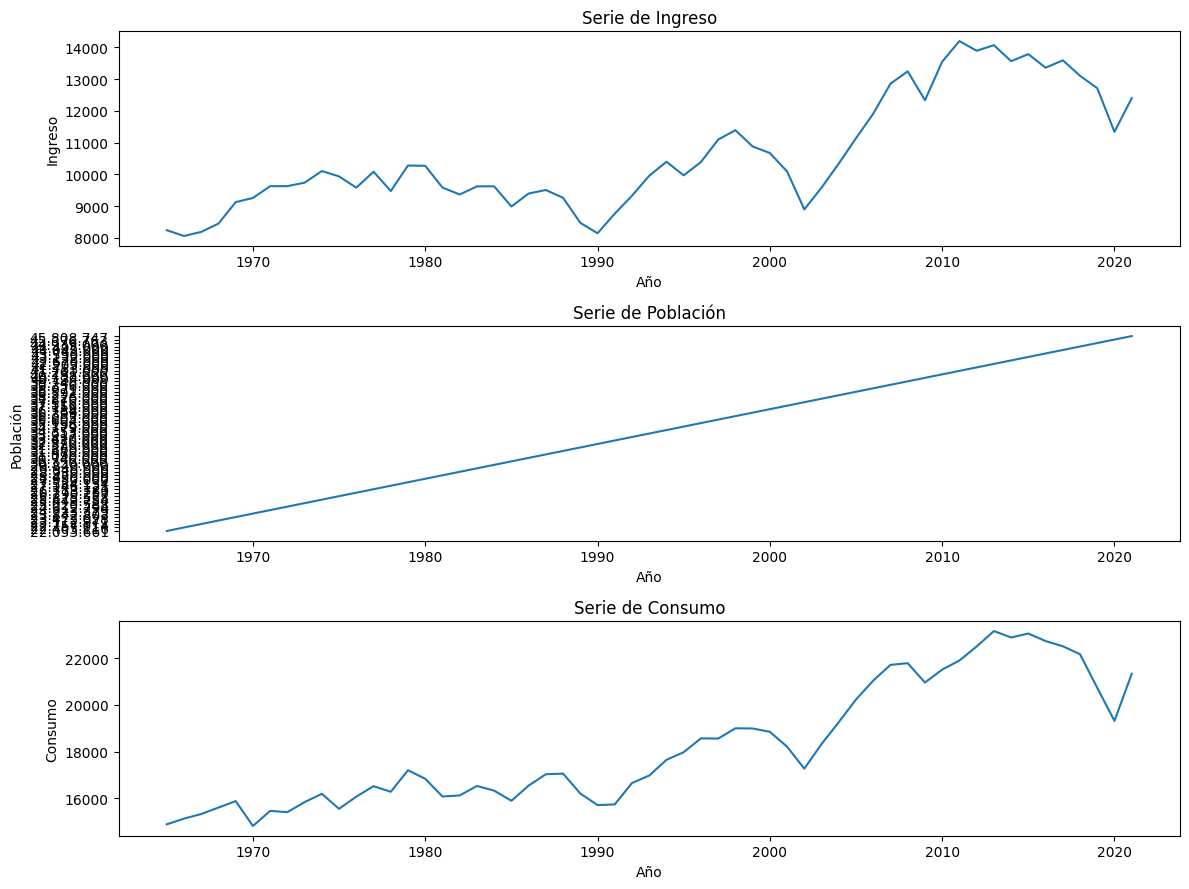

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))

# Graficar la serie 'Ingreso'
axes[0].plot(df_consolidado.index, df_consolidado['Ingreso'], label='Ingreso')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Ingreso')
axes[0].set_title('Serie de Ingreso')

# Graficar la serie 'Poblacion'
axes[1].plot(df_consolidado.index, df_consolidado['Poblacion'], label='Población')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Población')
axes[1].set_title('Serie de Población')

# Graficar la serie 'Consumo'
axes[2].plot(df_consolidado.index, df_consolidado['Consumo'], label='Consumo')
axes[2].set_xlabel('Año')
axes[2].set_ylabel('Consumo')
axes[2].set_title('Serie de Consumo')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()

A simple vista, parece haber una cierta relacion entra las series de consumo y la del ingreso. Tambien ambas parecen compartir una tendencia creciente con la seria de la poblacion.

In [ ]:
# Divido en train, test y vvalidacion
df_consolidado['Ingreso'] = pd.to_numeric(df_consolidado['Ingreso'], errors='coerce')
df_consolidado['Poblacion'] = pd.to_numeric(df_consolidado['Poblacion'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
df_consolidado['Consumo'] = pd.to_numeric(df_consolidado['Consumo'], errors='coerce')
df_consolidado = df_consolidado.dropna()

train_size = int(0.7 * len(df_consolidado))
test_size = int(0.2 * len(df_consolidado))
train_data = df_consolidado.iloc[:train_size]
test_data = df_consolidado.iloc[train_size:train_size+test_size]
validation_data = df_consolidado.iloc[train_size+test_size:]

<ipython-input-114-bc13ae9b2204>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_consolidado['Poblacion'] = pd.to_numeric(df_consolidado['Poblacion'].str.replace('.', '').str.replace(',', '.'), errors='coerce')


In [ ]:
from statsmodels.tsa.api import VAR

# Ajusto modelo VAR usando train
model = VAR(train_data)
model_fitted = model.fit(1)


forecast = model_fitted.forecast(train_data.values, steps=len(test_data))
forecast_validation = model_fitted.forecast(test_data.values, steps=len(validation_data))


forecast_df = pd.DataFrame(forecast, columns=['Ingreso', 'Poblacion', 'Consumo'], index=test_data.index)
forecast_validation_df = pd.DataFrame(forecast_validation, columns=['Ingreso', 'Poblacion', 'Consumo'], index=validation_data.index)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


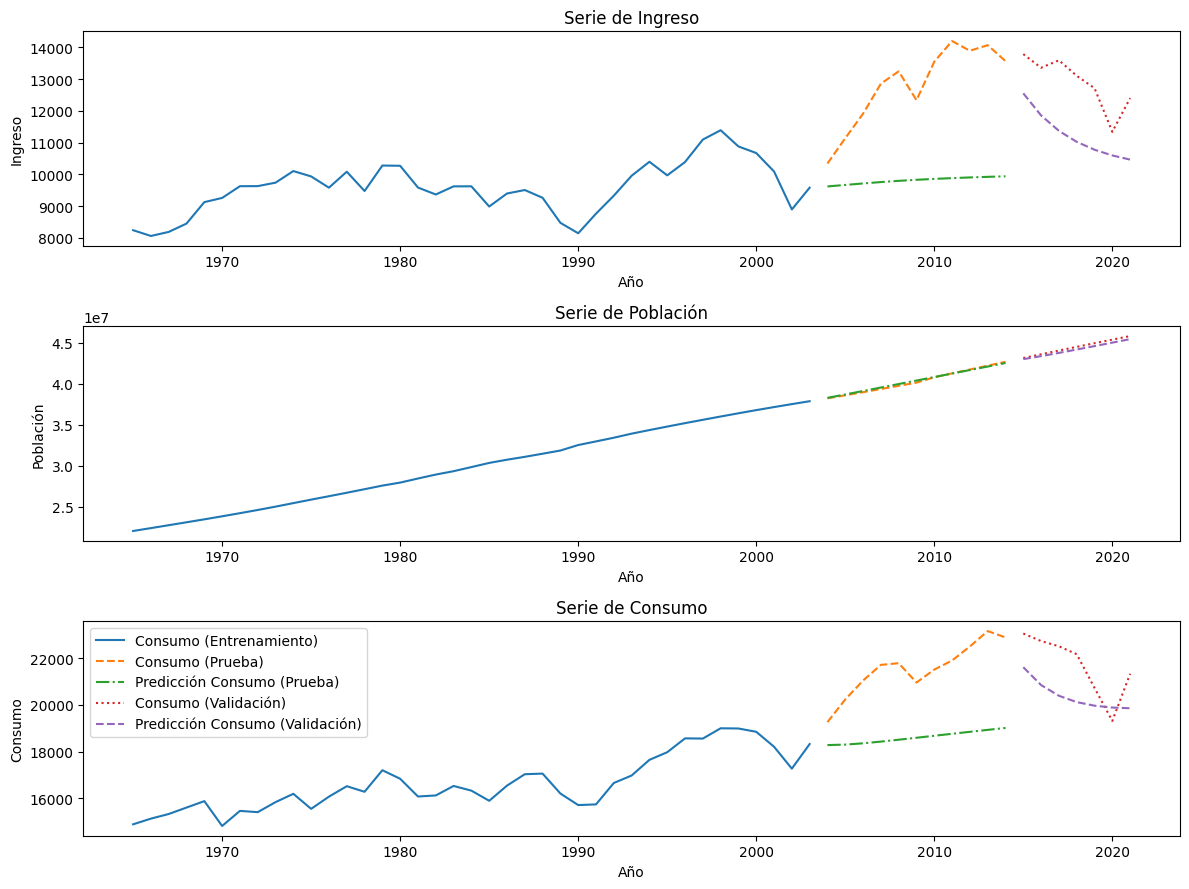

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))

# Graficar las series originales y las predicciones en el conjunto de prueba
axes[0].plot(train_data.index, train_data['Ingreso'], label='Ingreso (Entrenamiento)')
axes[0].plot(test_data.index, test_data['Ingreso'], label='Ingreso (Prueba)', linestyle='--')
axes[0].plot(forecast_df.index, forecast_df['Ingreso'], label='Predicción Ingreso (Prueba)', linestyle='-.')
axes[0].plot(validation_data.index, validation_data['Ingreso'], label='Ingreso (Validación)', linestyle=':')
axes[0].plot(forecast_validation_df.index, forecast_validation_df['Ingreso'], label='Predicción Ingreso (Validación)', linestyle='--')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Ingreso')
axes[0].set_title('Serie de Ingreso')

axes[1].plot(train_data.index, train_data['Poblacion'], label='Población (Entrenamiento)')
axes[1].plot(test_data.index, test_data['Poblacion'], label='Población (Prueba)', linestyle='--')
axes[1].plot(forecast_df.index, forecast_df['Poblacion'], label='Predicción Población (Prueba)', linestyle='-.')
axes[1].plot(validation_data.index, validation_data['Poblacion'], label='Población (Validación)', linestyle=':')
axes[1].plot(forecast_validation_df.index, forecast_validation_df['Poblacion'], label='Predicción Población (Validación)', linestyle='--')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Población')
axes[1].set_title('Serie de Población')

axes[2].plot(train_data.index, train_data['Consumo'], label='Consumo (Entrenamiento)')
axes[2].plot(test_data.index, test_data['Consumo'], label='Consumo (Prueba)', linestyle='--')
axes[2].plot(forecast_df.index, forecast_df['Consumo'], label='Predicción Consumo (Prueba)', linestyle='-.')
axes[2].plot(validation_data.index, validation_data['Consumo'], label='Consumo (Validación)', linestyle=':')
axes[2].plot(forecast_validation_df.index, forecast_validation_df['Consumo'], label='Predicción Consumo (Validación)', linestyle='--')
axes[2].set_xlabel('Año')
axes[2].set_ylabel('Consumo')
axes[2].set_title('Serie de Consumo')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar los gráficos
plt.legend()
plt.show()

In [ ]:
# Calcular el MSE y MAE para el conjunto de prueba
mse_test_ingreso = mean_squared_error(test_data['Ingreso'], forecast_df['Ingreso'])
mae_test_ingreso = mean_absolute_error(test_data['Ingreso'], forecast_df['Ingreso'])
mse_test_poblacion = mean_squared_error(test_data['Poblacion'], forecast_df['Poblacion'])
mae_test_poblacion = mean_absolute_error(test_data['Poblacion'], forecast_df['Poblacion'])
mse_test_consumo = mean_squared_error(test_data['Consumo'], forecast_df['Consumo'])
mae_test_consumo = mean_absolute_error(test_data['Consumo'], forecast_df['Consumo'])

# Calcular el MSE y MAE para el conjunto de validación
mse_validation_ingreso = mean_squared_error(validation_data['Ingreso'], forecast_validation_df['Ingreso'])
mae_validation_ingreso = mean_absolute_error(validation_data['Ingreso'], forecast_validation_df['Ingreso'])
mse_validation_poblacion = mean_squared_error(validation_data['Poblacion'], forecast_validation_df['Poblacion'])
mae_validation_poblacion = mean_absolute_error(validation_data['Poblacion'], forecast_validation_df['Poblacion'])
mse_validation_consumo = mean_squared_error(validation_data['Consumo'], forecast_validation_df['Consumo'])
mae_validation_consumo = mean_absolute_error(validation_data['Consumo'], forecast_validation_df['Consumo'])

print(f'MSE para Ingreso en el conjunto de prueba: {mse_test_ingreso}')
print(f'MAE para Ingreso en el conjunto de prueba: {mae_test_ingreso}')
print(' ')

print(f'MSE para Población en el conjunto de prueba: {mse_test_poblacion}')
print(f'MAE para Población en el conjunto de prueba: {mae_test_poblacion}')
print(' ')

print(f'MSE para Consumo en el conjunto de prueba: {mse_test_consumo}')
print(f'MAE para Consumo en el conjunto de prueba: {mae_test_consumo}')
print(' ')

print(f'MSE para Ingreso en el conjunto de validación: {mse_validation_ingreso}')
print(f'MAE para Ingreso en el conjunto de validación: {mae_validation_ingreso}')
print(' ')

print(f'MSE para Población en el conjunto de validación: {mse_validation_poblacion}')
print(f'MAE para Población en el conjunto de validación: {mae_validation_poblacion}')
print(' ')

print(f'MSE para Consumo en el conjunto de validación: {mse_validation_consumo}')
print(f'MAE para Consumo en el conjunto de validación: {mae_validation_consumo}')

MSE para Ingreso en el conjunto de prueba: 10357295.963820657
MAE para Ingreso en el conjunto de prueba: 3021.1411573214627
 
MSE para Población en el conjunto de prueba: 19665461400.47901
MAE para Población en el conjunto de prueba: 119337.89254742184
 
MSE para Consumo en el conjunto de prueba: 9339150.394386292
MAE para Consumo en el conjunto de prueba: 2926.282188706742
 
MSE para Ingreso en el conjunto de validación: 3017747.1189669217
MAE para Ingreso en el conjunto de validación: 1666.1251405807016
 
MSE para Población en el conjunto de validación: 93628869783.43336
MAE para Población en el conjunto de validación: 294814.45680486195
 
MSE para Consumo en el conjunto de validación: 2475904.5465609776
MAE para Consumo en el conjunto de validación: 1468.9363352037128


# Punto 11: Test de Granger y Funcion impulso-respuesta

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests


def granger_causality_test(data, max_lag=5):
    results = {}
    variables_of_interest = ["Ingreso", "Consumo", "Poblacion"]

    for col in variables_of_interest:
        results[col] = {}
        for target_col in variables_of_interest:
            if col != target_col:
                test_result = grangercausalitytests(data[[col, target_col]], max_lag, verbose=False)
                p_values = [test_result[i + 1][0]['ssr_ftest'][1] for i in range(max_lag)]
                results[col][target_col] = p_values
    return results

granger_results = granger_causality_test(train_data, max_lag=3)


for col, p_values in granger_results.items():
    for target_col, p_values_list in p_values.items():
        print(f"P-valores para {col} y {target_col}: {p_values_list}")

P-valores para Ingreso y Consumo: [0.9965140157957372, 0.6180905976346147, 0.5575678287643884]
P-valores para Ingreso y Poblacion: [0.6837995657244313, 0.46378661865468407, 0.6307704260839253]
P-valores para Consumo y Ingreso: [0.7986493977194546, 0.7504522706412804, 0.6323624165820378]
P-valores para Consumo y Poblacion: [0.022732668125724158, 0.05421673948755753, 0.0766796440673739]
P-valores para Poblacion y Ingreso: [0.5630455221440809, 0.788277822970432, 0.36750977182608224]
P-valores para Poblacion y Consumo: [0.07068017201395888, 0.40558695304144504, 0.25154030586315046]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

A partir del analisis de la funcion ide granger, podemo encontrar causalidad entre las series de Poblacion y Consumo, pero ambas parecen no tener causalidad con la serie de el ingreso.

In [ ]:
selected_columns = train_data[["Ingreso", "Consumo", "Poblacion"]]
correlation_matrix = selected_columns.corr()

print(correlation_matrix)

            Ingreso   Consumo  Poblacion
Ingreso    1.000000  0.750728   0.468432
Consumo    0.750728  1.000000   0.846213
Poblacion  0.468432  0.846213   1.000000


Segun la matriz de correlacion, observamos tambien la presencia de correlacion lineal entre las variables Poblacion y Consumo.

Por otro lado, la matriz de correlación muestra una correlación lineal positiva significativa entre las variables "Ingreso" y "Consumo" con un valor de 0.7507. Esto indica que estas dos variables tienen una relación lineal positiva, lo que significa que tienden a moverse en la misma dirección.

Sin embargo, las pruebas de causalidad de Granger no encuentran evidencia estadística de causalidad entre estas variables,. Esto sugiere que, no se puede afirmar que "Ingreso" causa cambios significativos en "Consumo."

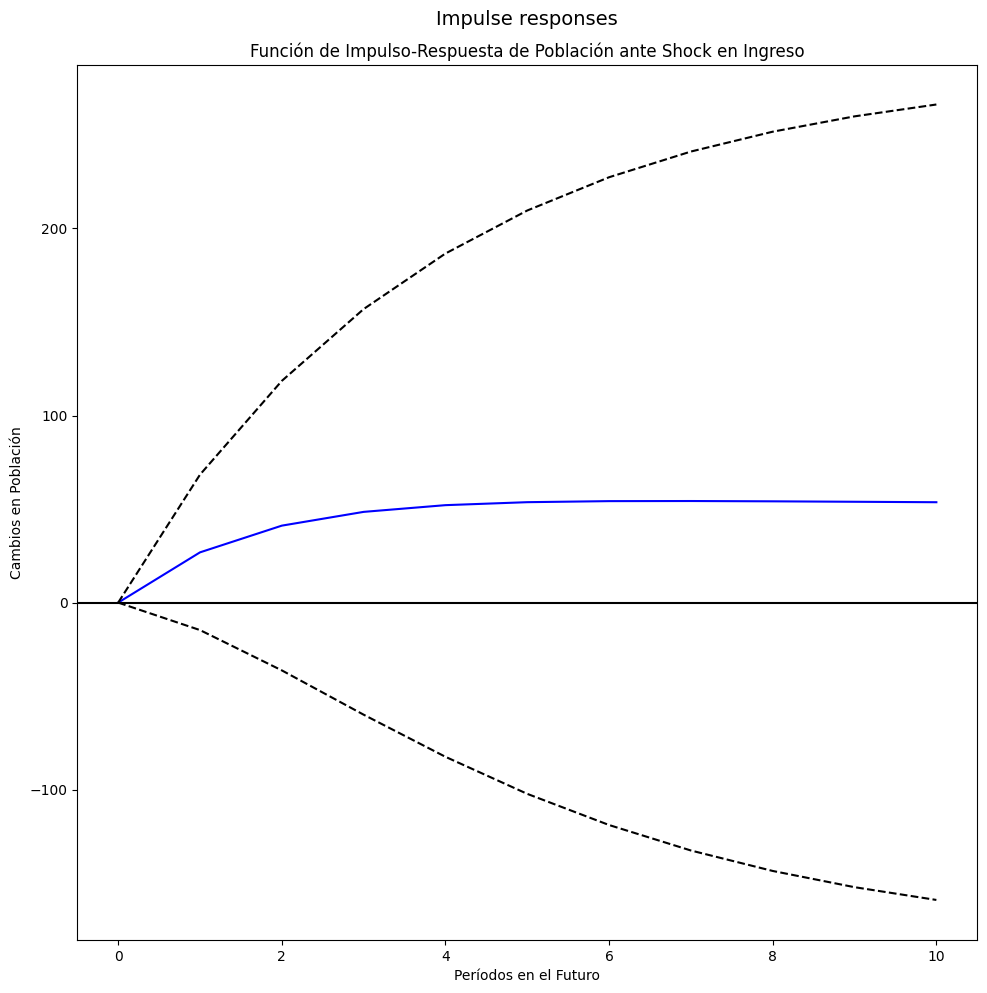

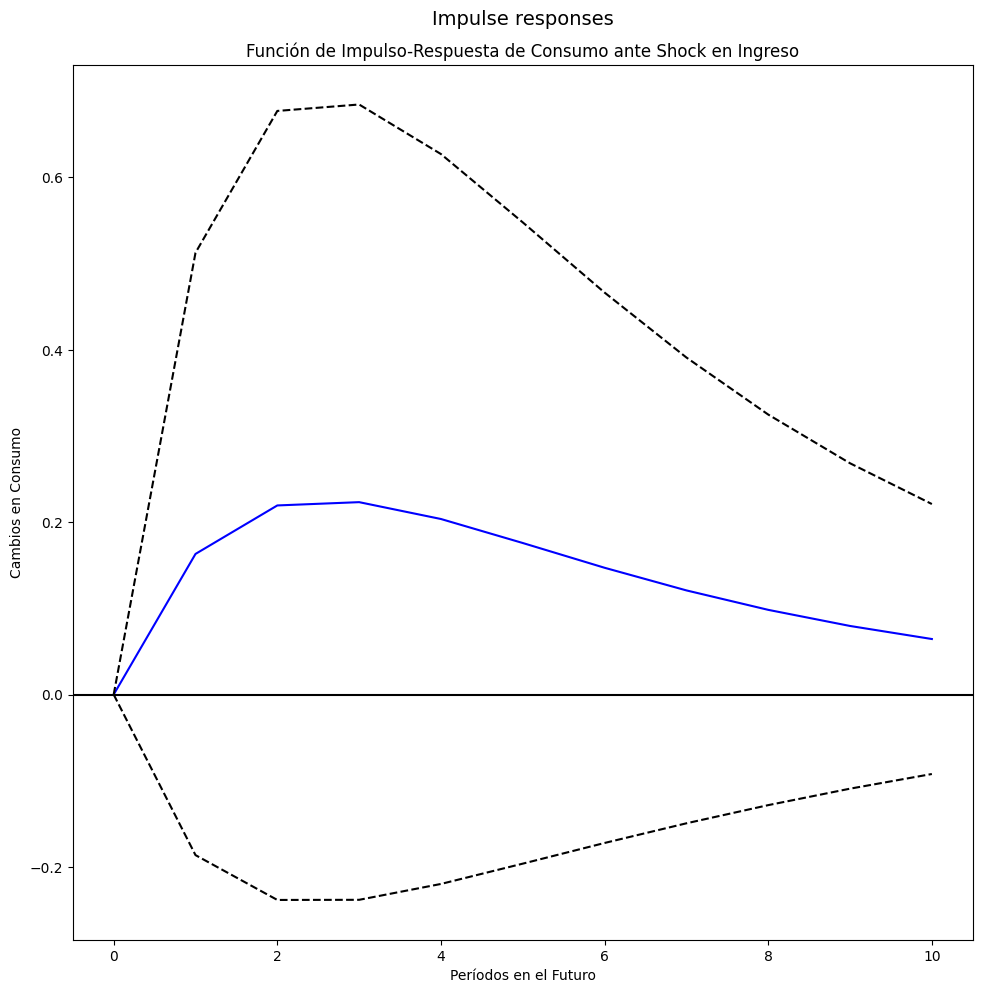

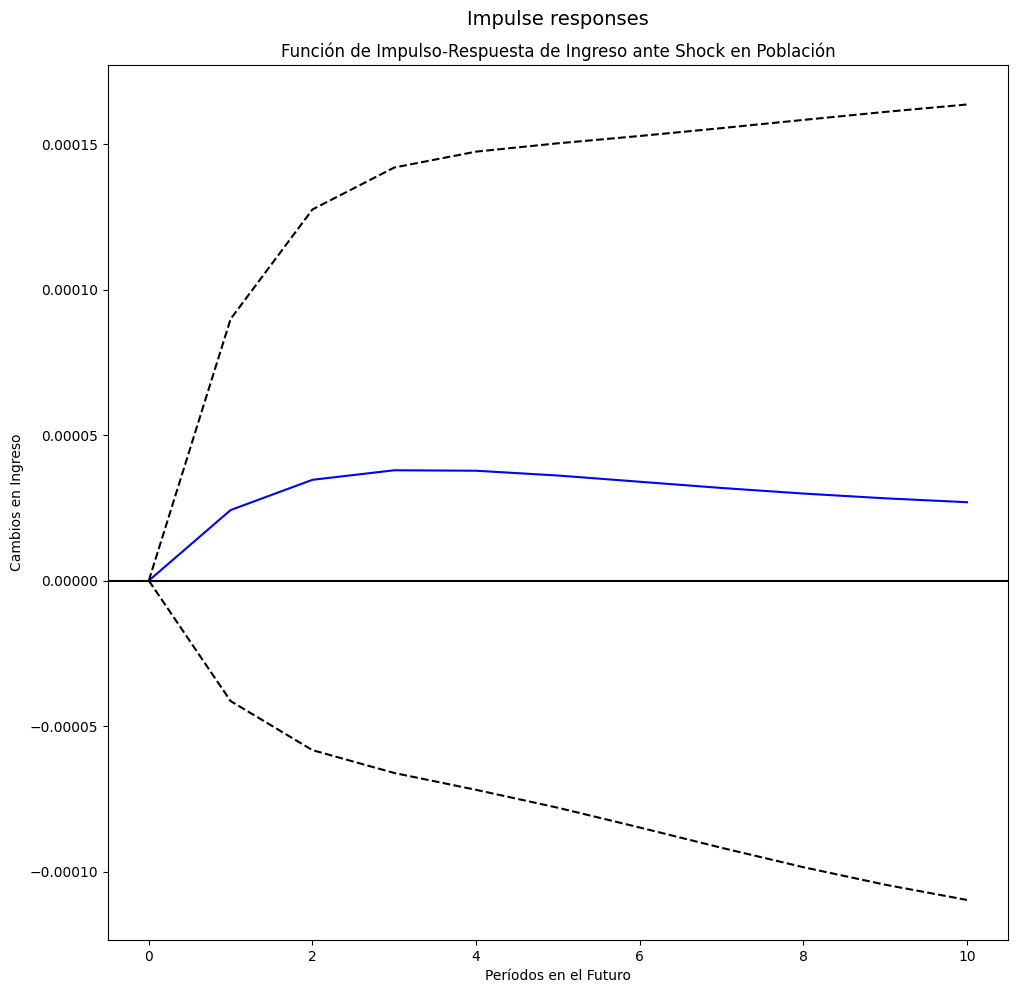

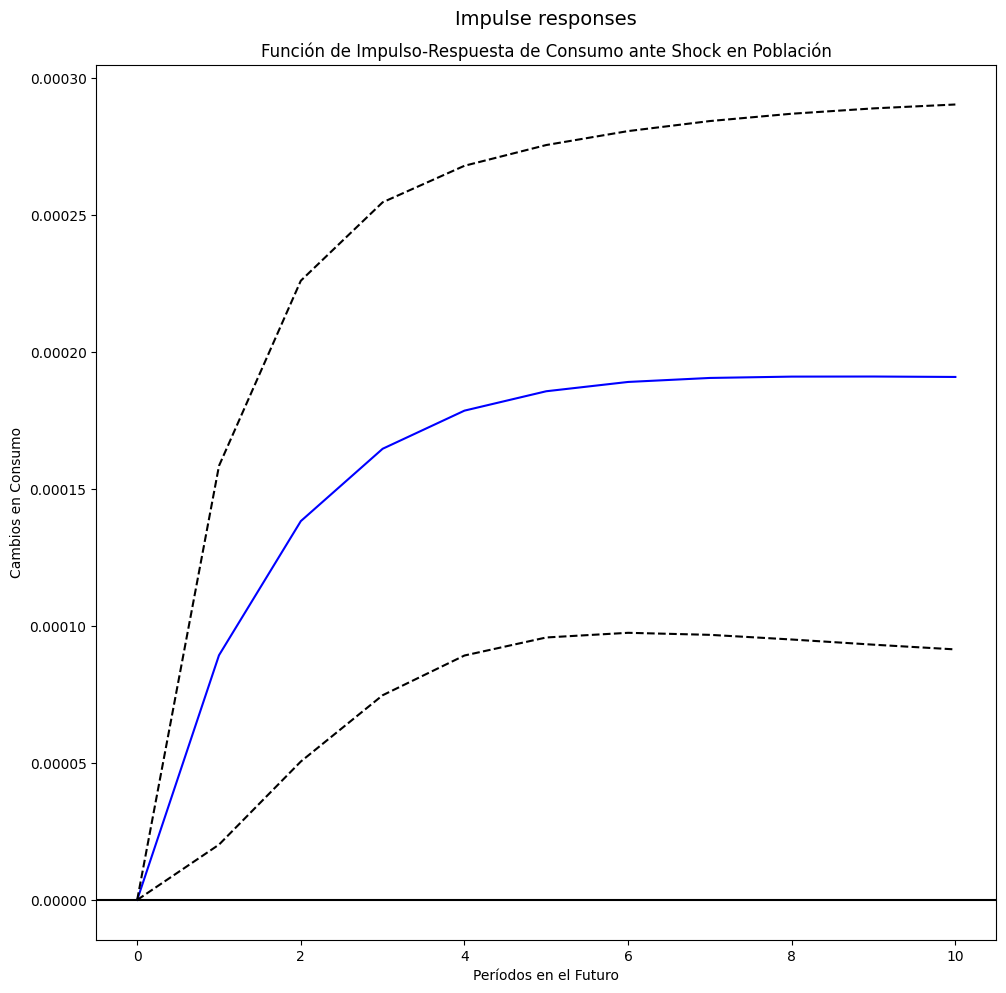

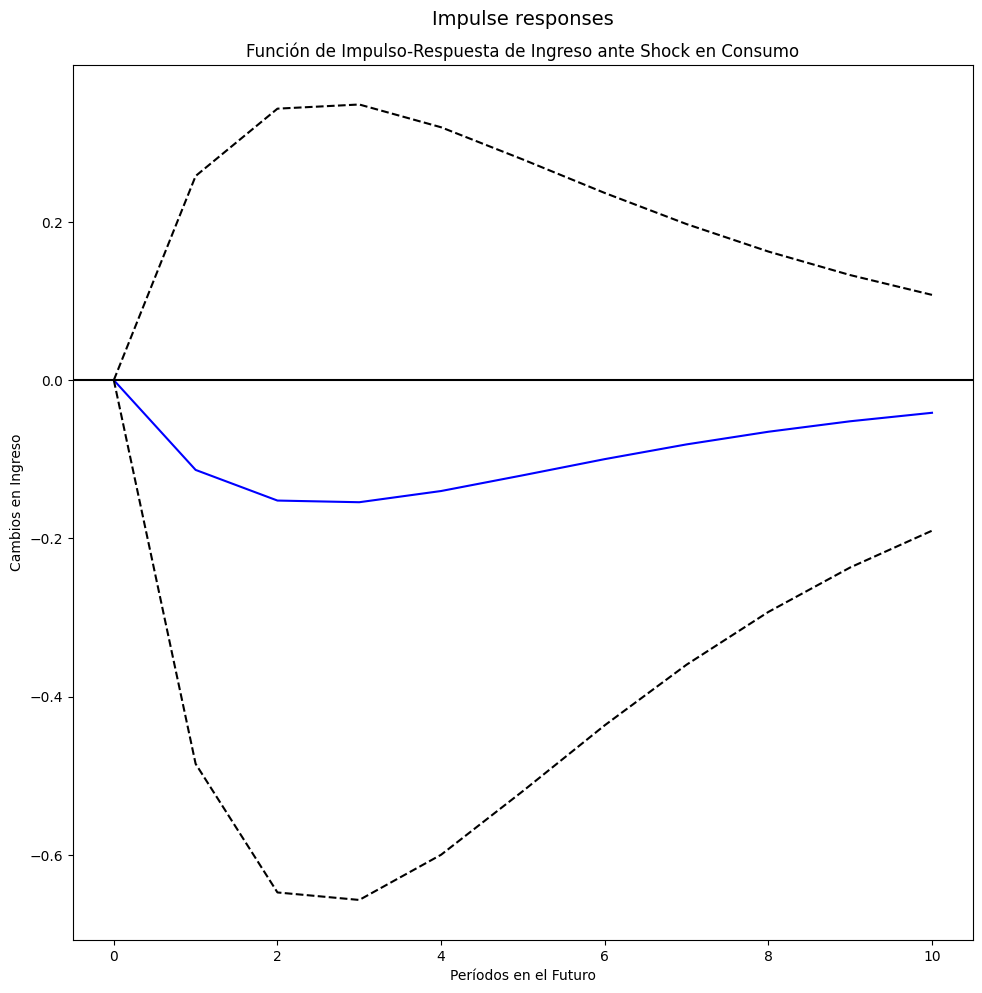

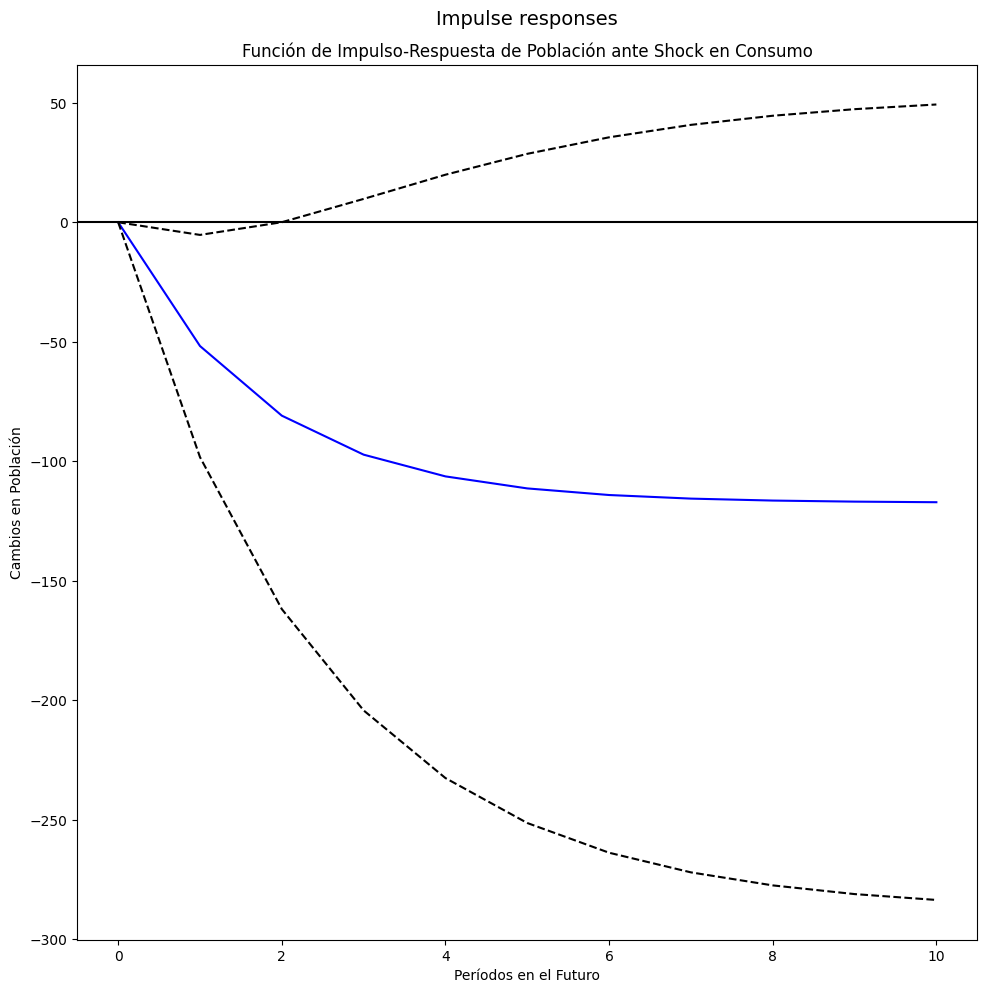

In [ ]:
irf.plot(impulse='Ingreso', response='Poblacion')
plt.title("Función de Impulso-Respuesta de Población ante Shock en Ingreso")
plt.xlabel("Períodos en el Futuro")
plt.ylabel("Cambios en Población")

irf.plot(impulse='Ingreso', response='Consumo')
plt.title("Función de Impulso-Respuesta de Consumo ante Shock en Ingreso")
plt.xlabel("Períodos en el Futuro")
plt.ylabel("Cambios en Consumo")

# Repite lo anterior para otras variables de impulso (Poblacion y Consumo)
irf.plot(impulse='Poblacion', response='Ingreso')
plt.title("Función de Impulso-Respuesta de Ingreso ante Shock en Población")
plt.xlabel("Períodos en el Futuro")
plt.ylabel("Cambios en Ingreso")

irf.plot(impulse='Poblacion', response='Consumo')
plt.title("Función de Impulso-Respuesta de Consumo ante Shock en Población")
plt.xlabel("Períodos en el Futuro")
plt.ylabel("Cambios en Consumo")

irf.plot(impulse='Consumo', response='Ingreso')
plt.title("Función de Impulso-Respuesta de Ingreso ante Shock en Consumo")
plt.xlabel("Períodos en el Futuro")
plt.ylabel("Cambios en Ingreso")

irf.plot(impulse='Consumo', response='Poblacion')
plt.title("Función de Impulso-Respuesta de Población ante Shock en Consumo")
plt.xlabel("Períodos en el Futuro")
plt.ylabel("Cambios en Población")

plt.show()

# Punto 12:

Concluciones sobre esta consigna:

- La serie de Ingresos, no es estacional, pero de todas formas el modelo seleccionado fue un SARIMA.



In [1]:
!pip install pmdarima
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 13.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings
from pmdarima.arima import auto_arima
plt.rcParams['figure.figsize'] = (10, 5)
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.tsa.stattools as tsa
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import ADFTest
from matplotlib import pyplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from datetime import timedelta
warnings.filterwarnings('ignore')
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime
import scipy.stats
import pylab
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
sns.set(rc={'figure.figsize':(20,10)})

In [54]:
file_path = '/content/per-capita-energy-use.csv'
df = pd.read_csv(file_path)
df.head()


Entity Code  Year  energy_consumption_per_capita
0  Afghanistan  AFG  1980                      623.92865
1  Afghanistan  AFG  1981                      786.83690
2  Afghanistan  AFG  1982                      926.65125
3  Afghanistan  AFG  1983                     1149.19590
4  Afghanistan  AFG  1984                     1121.57290

In [55]:
da = df[df['Entity'] == 'Argentina']
da.head()

Entity Code  Year  energy_consumption_per_capita
326  Argentina  ARG  1965                      14896.737
327  Argentina  ARG  1966                      15139.622
328  Argentina  ARG  1967                      15337.348
329  Argentina  ARG  1968                      15612.201
330  Argentina  ARG  1969                      15887.447

In [56]:
da = da[['Year','energy_consumption_per_capita']]
da.head()

Year  energy_consumption_per_capita
326  1965                      14896.737
327  1966                      15139.622
328  1967                      15337.348
329  1968                      15612.201
330  1969                      15887.447

In [57]:
da.tail()

Year  energy_consumption_per_capita
379  2018                      22163.160
380  2019                      20725.168
381  2020                      19314.066
382  2021                      21328.186
383  2022                      21994.422

In [58]:
da.dtypes


Year                               int64
energy_consumption_per_capita    float64
dtype: object

In [60]:
da.isna().sum()

Year                             0
energy_consumption_per_capita    0
dtype: int64

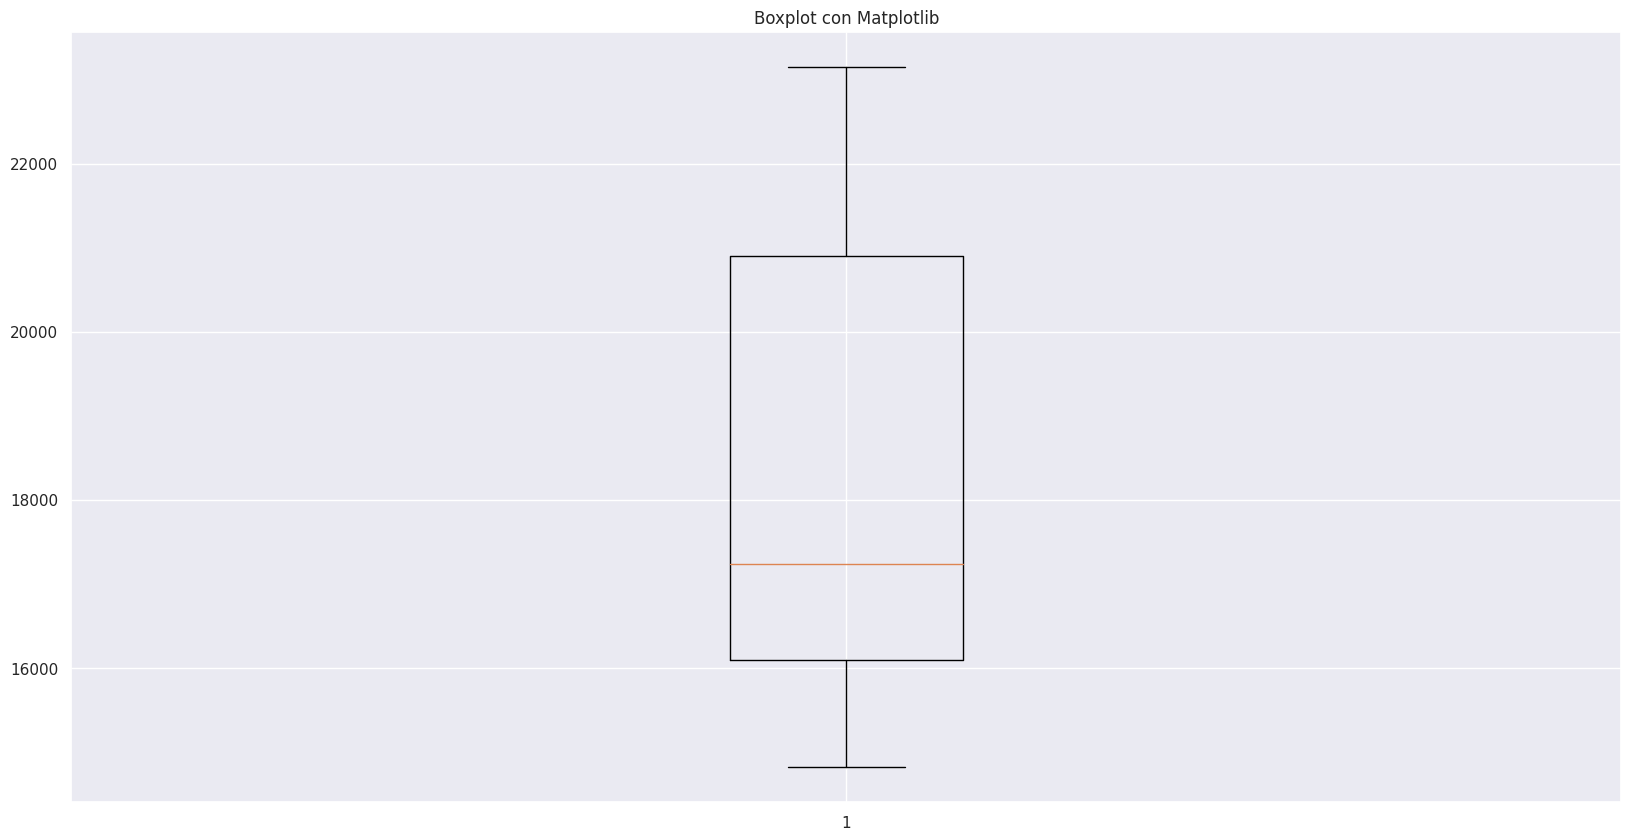

In [ ]:
plt.boxplot(da)
plt.title('Boxplot con Matplotlib')
plt.show()

In [61]:
da.set_index('Year', inplace=True)
da.head()



energy_consumption_per_capita
Year                               
1965                      14896.737
1966                      15139.622
1967                      15337.348
1968                      15612.201
1969                      15887.447

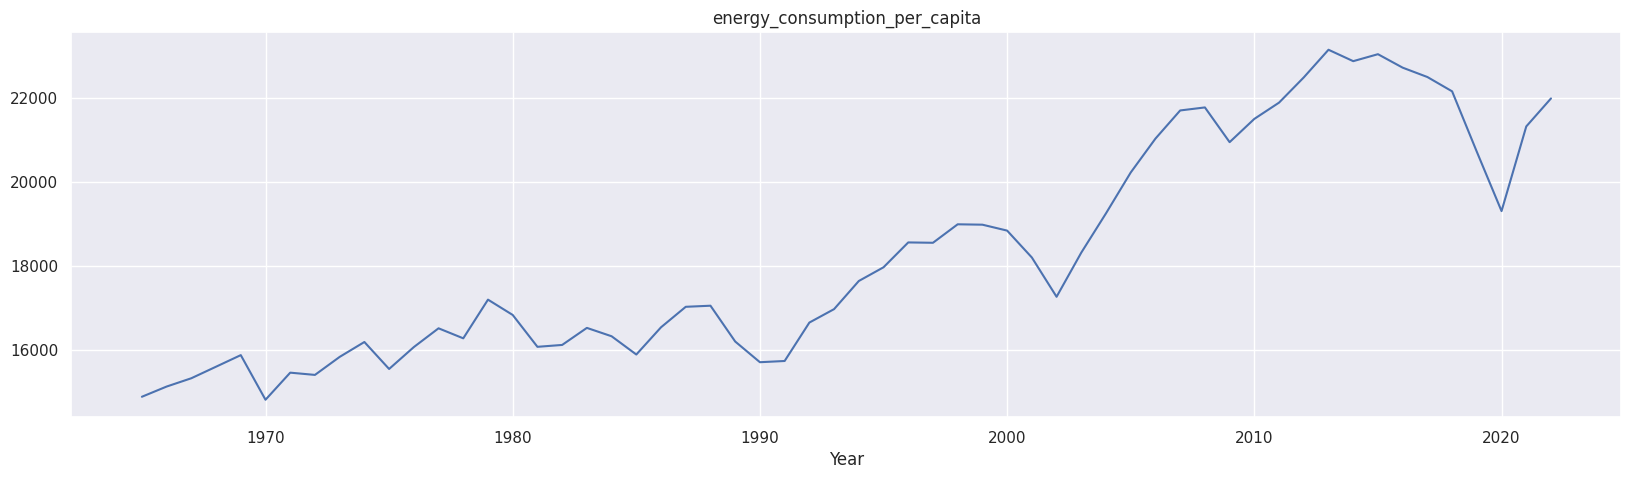

In [63]:
da.energy_consumption_per_capita.plot(figsize=(20,5), title = "energy_consumption_per_capita")
plt.show()



In [64]:
## Función para dibujar juntos FAS: autocovarianzas; FAC (autocorrelacion ) y FACP (autocorrelación parcial)
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  #axes[2,1].set_xlabel('Lag')


  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Serie 1: energy_consumption_per_capita')
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')

   p1.legend()
  plt.show()

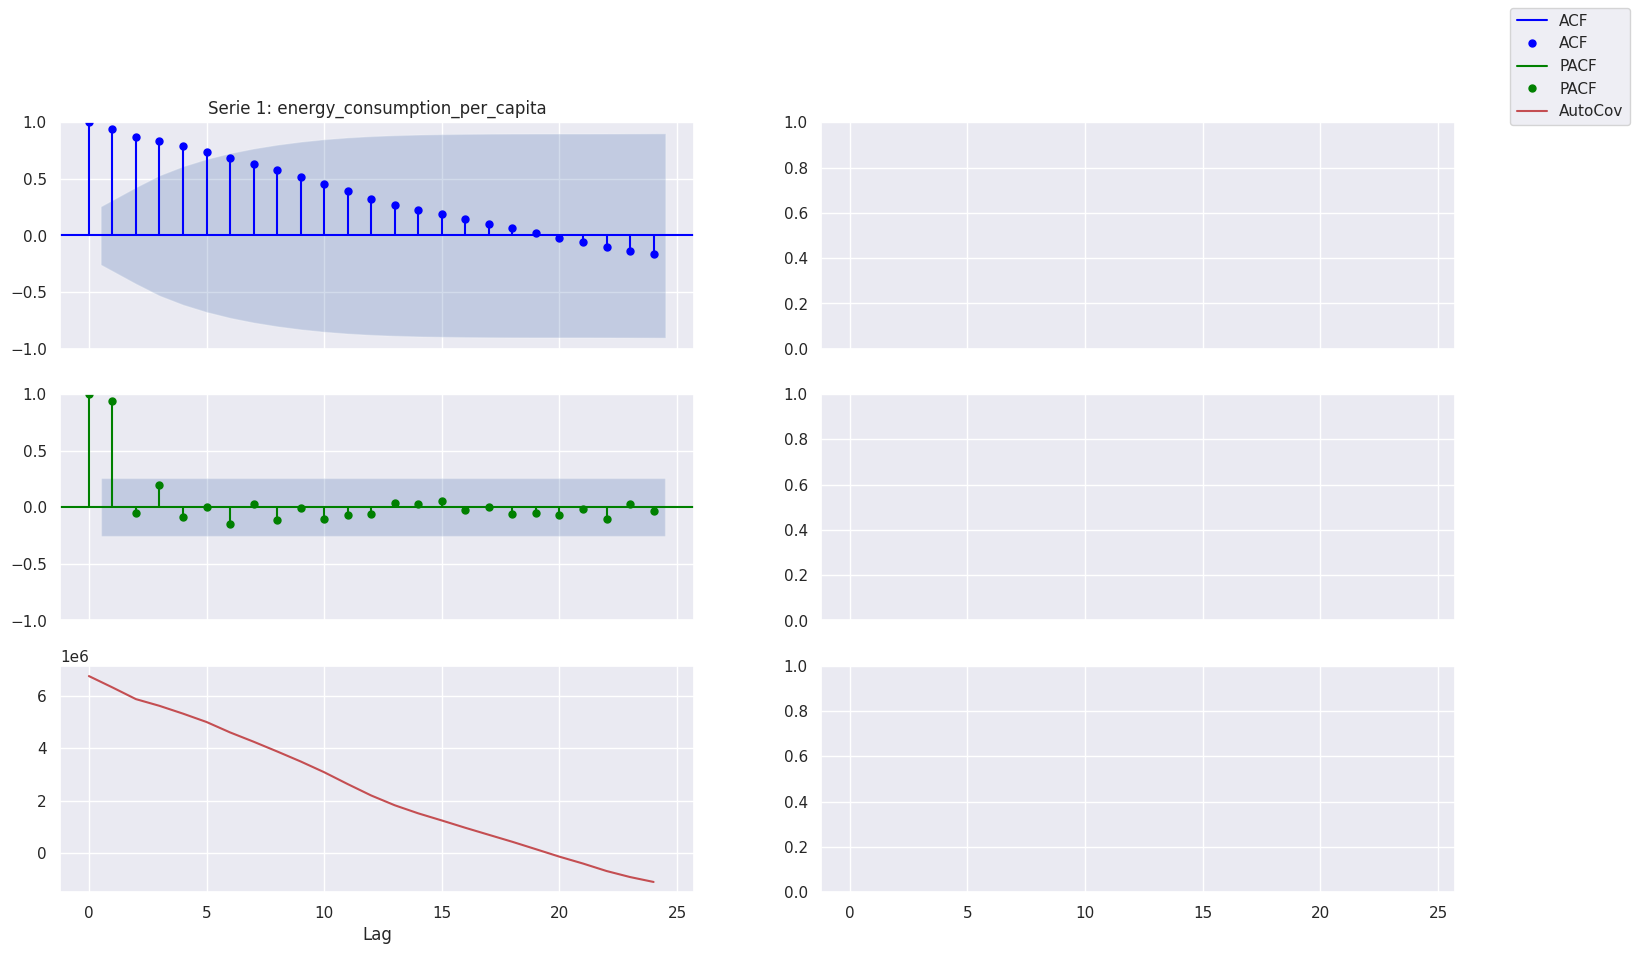

In [65]:
# Grafica diferentes funciones de la serie
autocov_autocorr(da.energy_consumption_per_capita, da.energy_consumption_per_capita ,24)

De acuerdo a los graficos de FAC se trataria de una serie no estacionaria dado que decrece en forma lineal

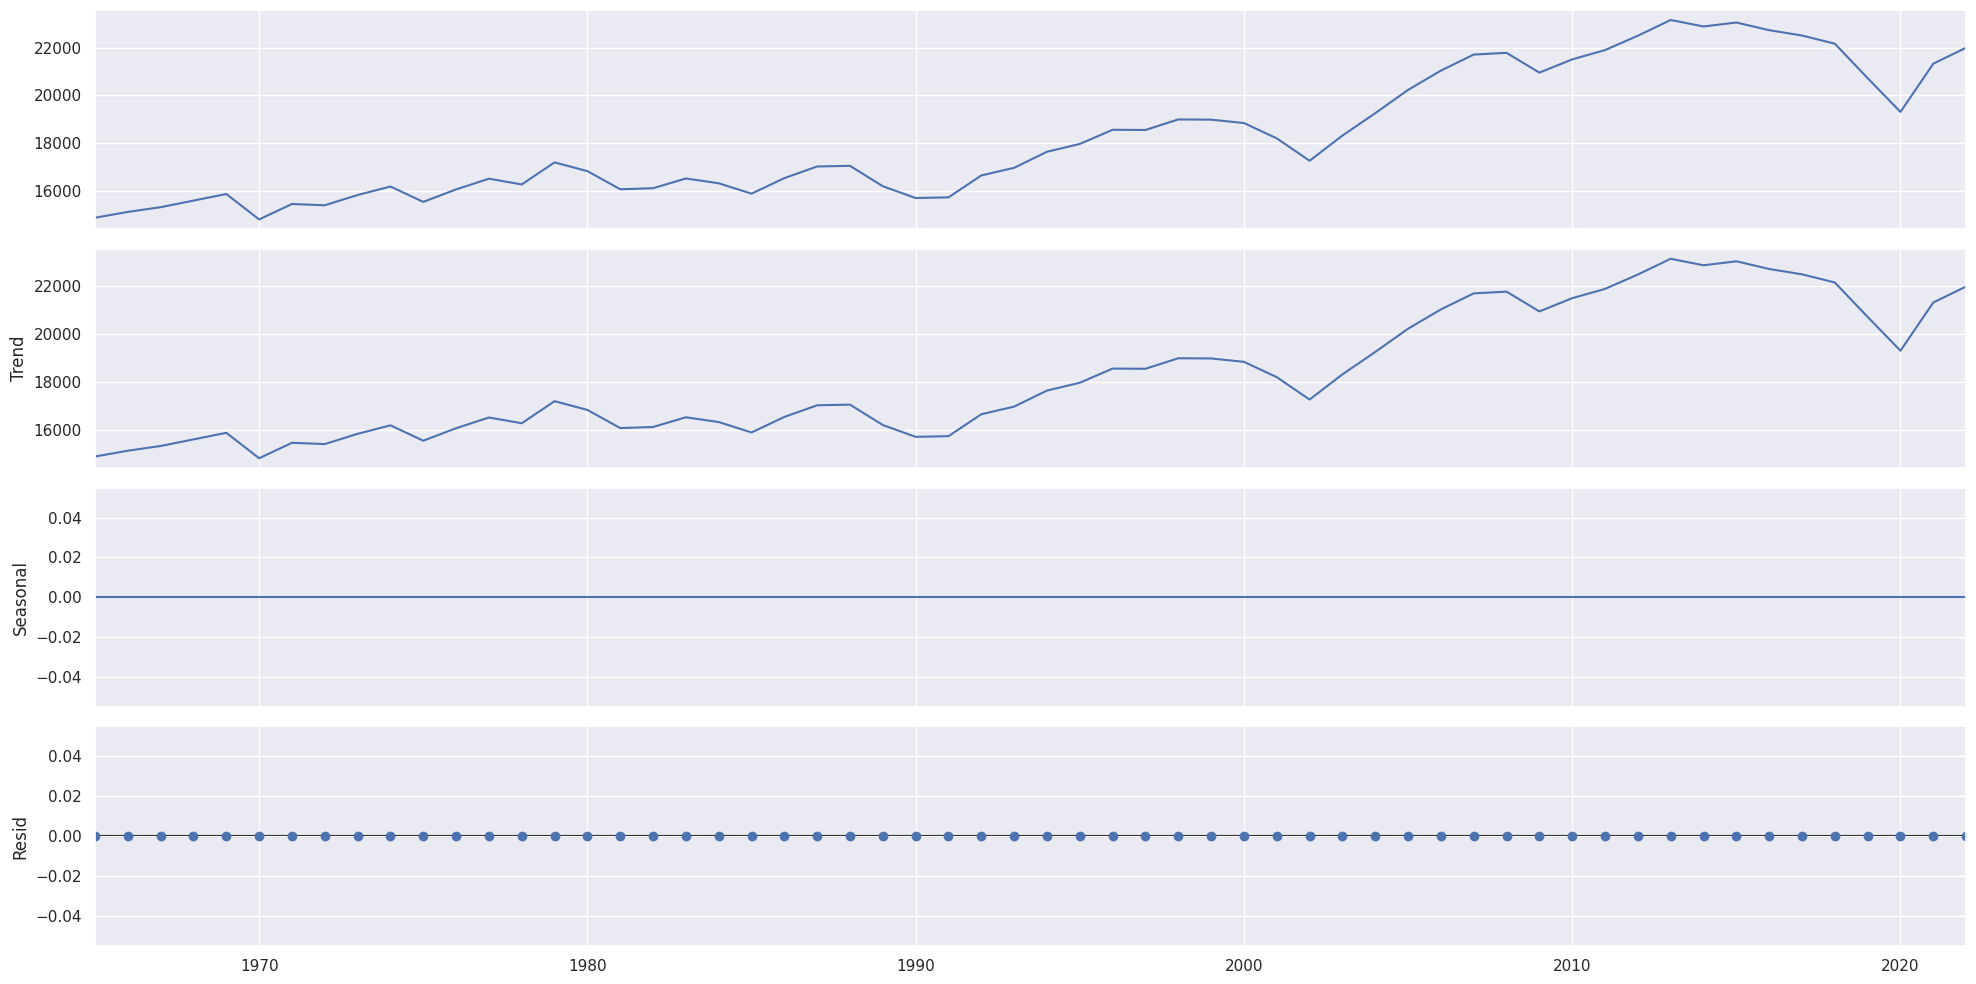

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_additive = seasonal_decompose(da, model = "adittive",period=1)
s_dec_additive.plot()
plt.show()


de acuerdo a la descomposicion de la serie apreciamos tendencia y estacionalidad

analisis de raices unitarias

In [67]:
def estacionario(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

In [68]:
def print_test_afd(y):
  resultado = tsa.adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

SERIE ORIGINAL

In [69]:
print_test_afd(da)

Estadistico ADF: -0.851679
p-valor: 0.803469
Valores criticos:
	1%: -3.555
	5%: -2.916
	10%: -2.596


In [70]:
# No incluye término independiente ni lineal (“None”)
tsa.adfuller(da, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)

(1.1647193711606758,
 0.9365790991428828,
 2,
 55,
 {'1%': -2.6075899173553716,
  '5%': -1.946808366641623,
  '10%': -1.612735648384673},
 732.2576206397222)

In [71]:
# Incluya término independiente pero no incluye término lineal (“Drift”)
tsa.adfuller(da, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-0.8516785458578624,
 0.8034688198189792,
 2,
 55,
 {'1%': -3.5552728880540942,
  '5%': -2.9157312396694217,
  '10%': -2.5956695041322315},
 733.0719055417333)

In [72]:
# Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
tsa.adfuller(da, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

(-2.915487248995459,
 0.1572604354490395,
 1,
 56,
 {'1%': -4.130261462053571,
  '5%': -3.4920297480867344,
  '10%': -3.1746004600947524},
 727.6492332956793)

In [73]:
estacionario(da)

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.3336270226273974, True)


\Con una diferenciacion es suficiente para ser estacionaria

SERIE DIFERENCIADA

In [74]:
X = da[['energy_consumption_per_capita' ]]
X_diff=X.copy()
da_diff=X_diff.diff(axis = 0, periods = 1)
da_diff.head()
da_diff.drop([1965], inplace=True)



In [75]:
print_test_afd(da_diff)

Estadistico ADF: -5.391244
p-valor: 0.000004
Valores criticos:
	1%: -3.555
	5%: -2.916
	10%: -2.596


In [76]:
# No incluye término independiente ni lineal (“None”)
tsa.adfuller(da_diff, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)

(-6.204955560391591,
 3.4170747090574965e-09,
 0,
 56,
 {'1%': -2.606821568877551,
  '5%': -1.9466916602131925,
  '10%': -1.612798147776968},
 716.3103487899825)

In [77]:
# Incluya término independiente pero no incluye término lineal (“Drift”)
tsa.adfuller(da_diff, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-5.391243682992687,
 3.5336342212119855e-06,
 1,
 55,
 {'1%': -3.5552728880540942,
  '5%': -2.9157312396694217,
  '10%': -2.5956695041322315},
 717.1725463891835)

In [78]:
# Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
tsa.adfuller(da_diff, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

(-5.316891325516753,
 5.244428131265887e-05,
 1,
 55,
 {'1%': -4.133575845229151,
  '5%': -3.4935752832456797,
  '10%': -3.1754929451540197},
 719.1724553573326)

In [79]:
estacionario(da_diff)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


Corroboramos que aplicando una diferencianciacion es suficiente para volver estacionaria la serie

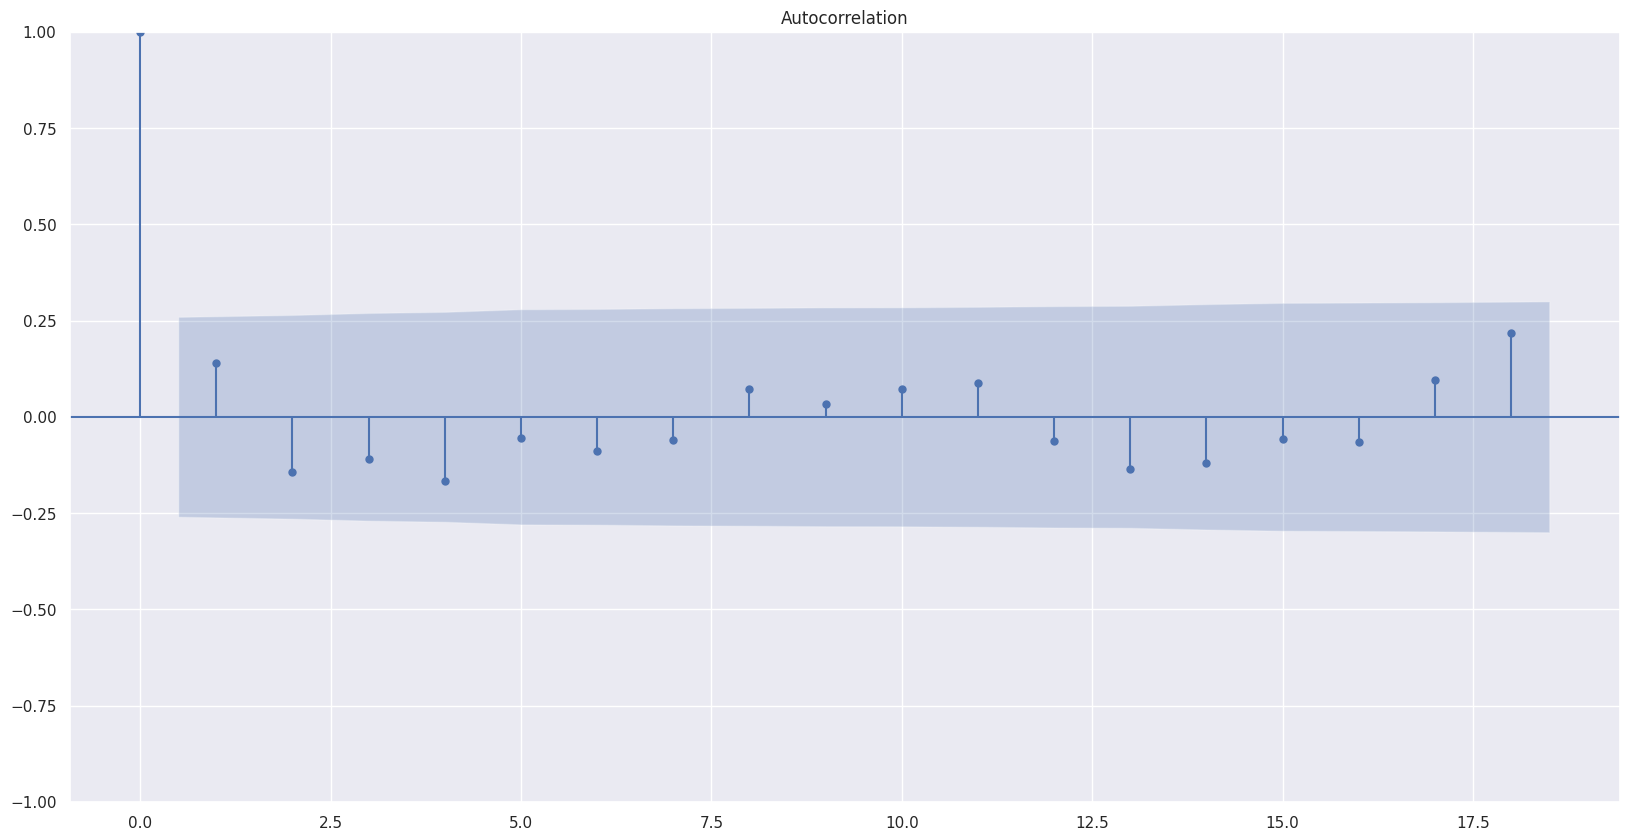

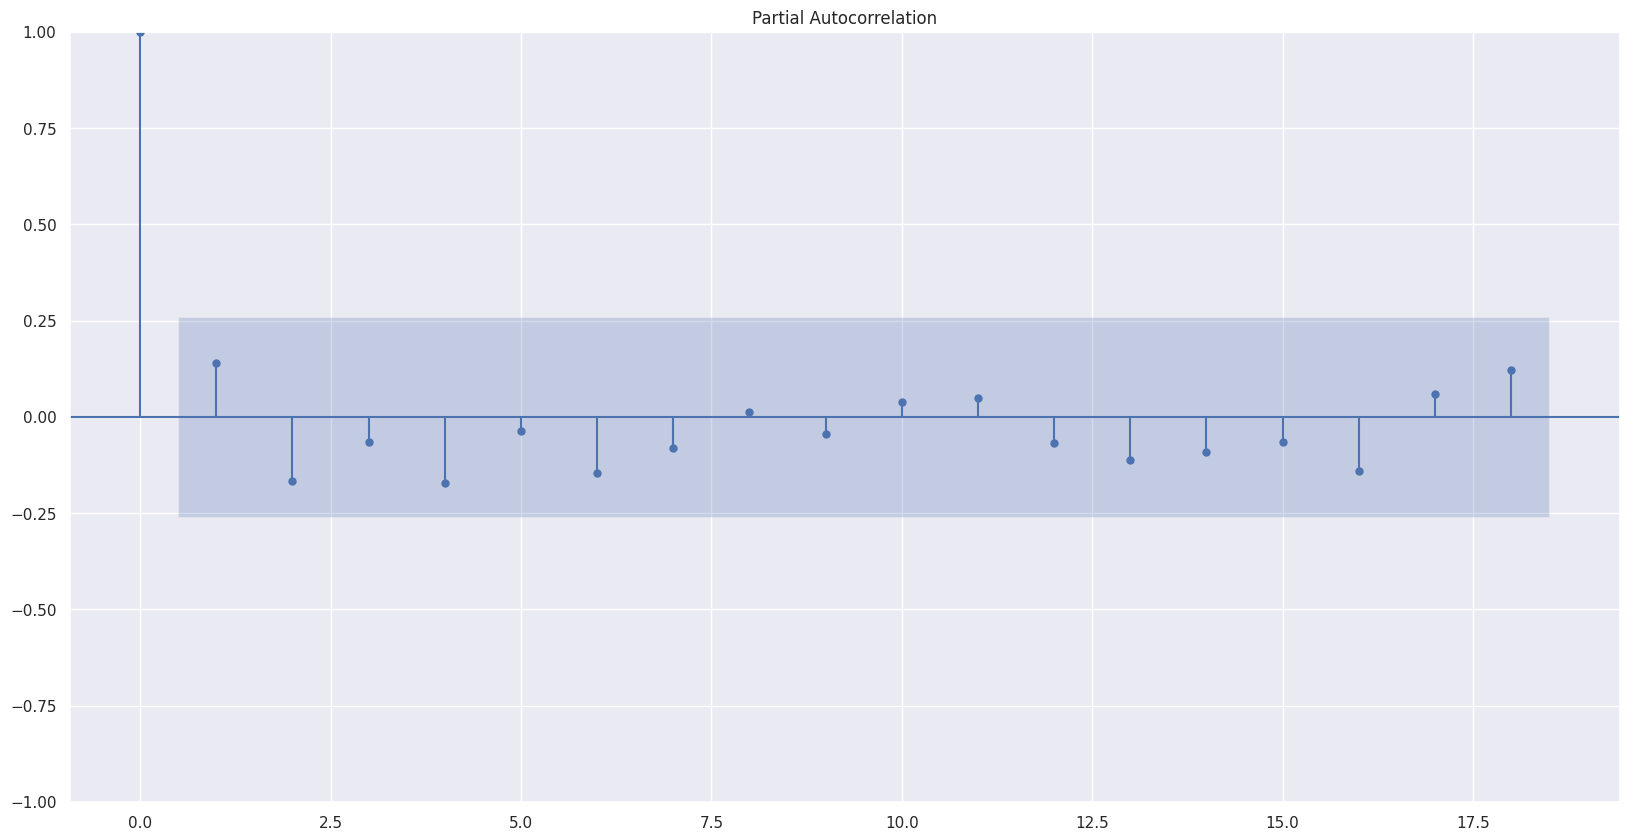

In [80]:
plot_acf(da_diff.energy_consumption_per_capita)
plot_pacf(da_diff.energy_consumption_per_capita)
plt.show()

Corroboramos graficamente que la FAC de la serie con una diferenciacion verifica un decrecimiento exponencial

Phillips-Perron

In [32]:
from arch.unitroot import PhillipsPerron

In [33]:
def Phillips_Perron(series, **k):

    params = {'n':'No incluye término independiente ni lineal',
              'c':'Incluya término independiente pero no incluye término lineal',
              'ct':'Incluya ambos términos'
              }
    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')
        pp = PhillipsPerron(series,trend=param, **k)
        print(f'PP Estadistico: {pp.stat}')
        print(f'p-valor: {pp.pvalue}')
        print(f'numero de lags: {pp.lags}')
        print('Valor Critico:')
        for key, value in pp.critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if pp.pvalue > 0.05 else ""}estacionaria')
        print(f"PP Numero de diferenciacion estimada: {ndiffs(series, test='pp')}")

        print("*".center(60, '*'))
        print("")

In [81]:
Phillips_Perron(da)

Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: 1.8733187870225199
p-valor: 0.9862407072776507
numero de lags: 11
Valor Critico:
   1% : -2.606080904893813
   5% : -1.9465793869098724
   10% : -1.6128587250058046
Resultado: La serie es no estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -0.6632264075865071
p-valor: 0.8560462227245215
numero de lags: 11
Valor Critico:
   1% : -3.5506699942762414
   5% : -2.913766394626147
   10% : -2.5946240473991997
Resultado: La serie es no estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: ct - Incluya ambos términos
PP Estadistico: -2.263608321161395
p-valor: 0.45417408191438646
numero de lags: 11
Valor Critico:
   1% : -4.127070491379263
   5% : -3.490540734099021
   10%

In [82]:
Phillips_Perron(da_diff)

Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: -6.081673599302235
p-valor: 6.293677937229272e-09
numero de lags: 11
Valor Critico:
   1% : -2.606821568877551
   5% : -1.9466916602131925
   10% : -1.612798147776968
Resultado: La serie es estacionaria
PP Numero de diferenciacion estimada: 0
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -6.4449469004579205
p-valor: 1.5743117043366745e-08
numero de lags: 11
Valor Critico:
   1% : -3.552928203580539
   5% : -2.9147306250000002
   10% : -2.595137155612245
Resultado: La serie es estacionaria
PP Numero de diferenciacion estimada: 0
************************************************************

Tipo de regresión: ct - Incluya ambos términos
PP Estadistico: -6.366316377298595
p-valor: 3.616011682815362e-07
numero de lags: 11
Valor Critico:
   1% : -4.130261462053571
   5% : -3.4920297480867344
   1

Idem segun criterio de Perron (solo una diferenciacion es suficiente)

KPSS

In [83]:
from statsmodels.tsa.stattools import kpss

In [84]:
def kpss_test(series, **kw):

    params = {'c':'Los datos son estacionarios alrededor de una constante.',
              'ct': 'Los datos son estacionarios alrededor de una tendencia.'
             }

    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')

        statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
        # Format Output
        print(f'KPSS Estadistico: {statistic}')
        print(f'p-valor: {p_value}')
        print(f'numero de lags: {n_lags}')
        print('Valor critico:')
        for key, value in critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if p_value < 0.05 else ""}estacionaria')
        print(f"KPSS Numero estimado de diferencias a aplicar: {ndiffs(series, test='kpss')}")

        print("*".center(60, '*'))
        print("")

In [85]:
kpss_test(da)

Tipo de regresión: c - Los datos son estacionarios alrededor de una constante.
KPSS Estadistico: 1.1244291789489351
p-valor: 0.01
numero de lags: 4
Valor critico:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Resultado: La serie es no estacionaria
KPSS Numero estimado de diferencias a aplicar: 1
************************************************************

Tipo de regresión: ct - Los datos son estacionarios alrededor de una tendencia.
KPSS Estadistico: 0.1520275063962578
p-valor: 0.04497707800311849
numero de lags: 4
Valor critico:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: La serie es no estacionaria
KPSS Numero estimado de diferencias a aplicar: 1
************************************************************



In [86]:
kpss_test(da_diff)

Tipo de regresión: c - Los datos son estacionarios alrededor de una constante.
KPSS Estadistico: 0.04623039704413811
p-valor: 0.1
numero de lags: 1
Valor critico:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Resultado: La serie es estacionaria
KPSS Numero estimado de diferencias a aplicar: 0
************************************************************

Tipo de regresión: ct - Los datos son estacionarios alrededor de una tendencia.
KPSS Estadistico: 0.043249572516678374
p-valor: 0.1
numero de lags: 1
Valor critico:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: La serie es estacionaria
KPSS Numero estimado de diferencias a aplicar: 0
************************************************************



Idem criterio KPSS (una sola diferenciacion es suficiente para volver estacionaria a la serie)

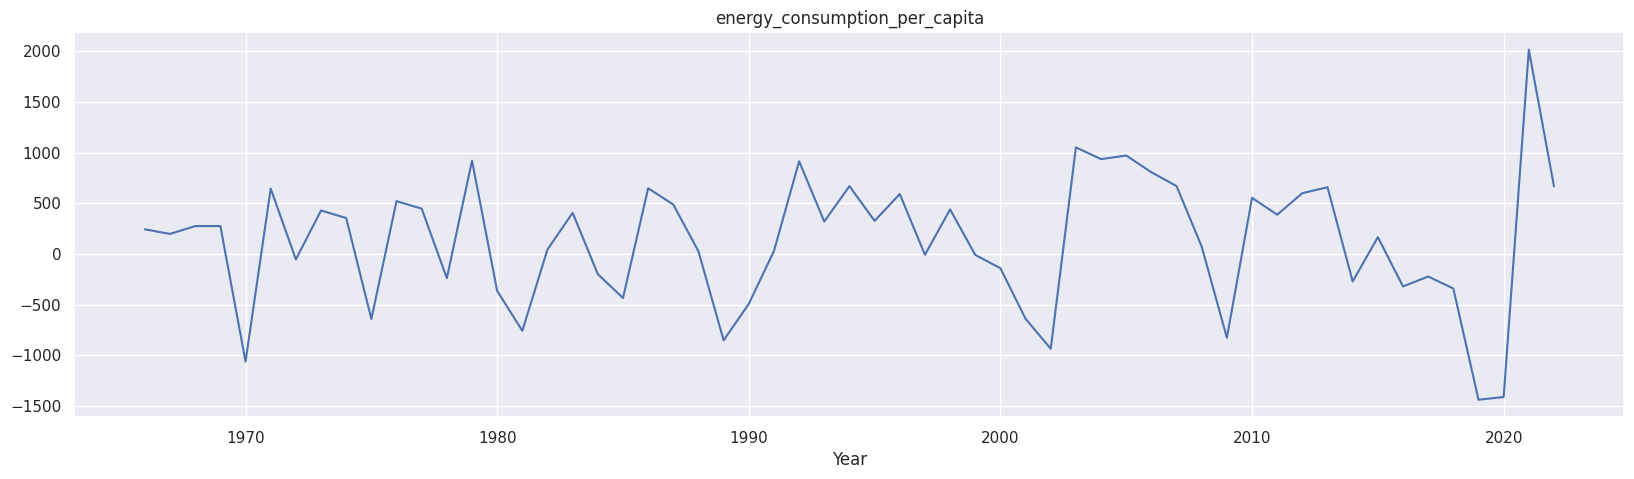

In [87]:
da_diff.energy_consumption_per_capita.plot(figsize=(20,5), title = "energy_consumption_per_capita")
plt.show()

Graficando la serie diferenciada, podemos ver ahora la ausencia de tendencia

In [89]:
# Separacion Train/Test
# Seleccionamos el primer 80% para train
train = da.iloc[:round(len(da)*.80)]

# Seleccionamos el 20% restante para test
test = da.iloc[round(len(da)*.80):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train, test)

      energy_consumption_per_capita
Year                               
1965                     14896.7370
1966                     15139.6220
1967                     15337.3480
1968                     15612.2010
1969                     15887.4470
1970                     14825.7120
1971                     15470.2470
1972                     15416.6920
1973                     15845.2580
1974                     16199.6810
1975                     15557.9690
1976                     16078.7295
1977                     16525.4920
1978                     16286.9300
1979                     17207.5680
1980                     16842.9060
1981                     16085.1020
1982                     16129.6030
1983                     16535.4260
1984                     16336.1760
1985                     15901.7740
1986                     16549.9900
1987                     17037.0800
1988                     17062.9360
1989                     16211.0470
1990                     157

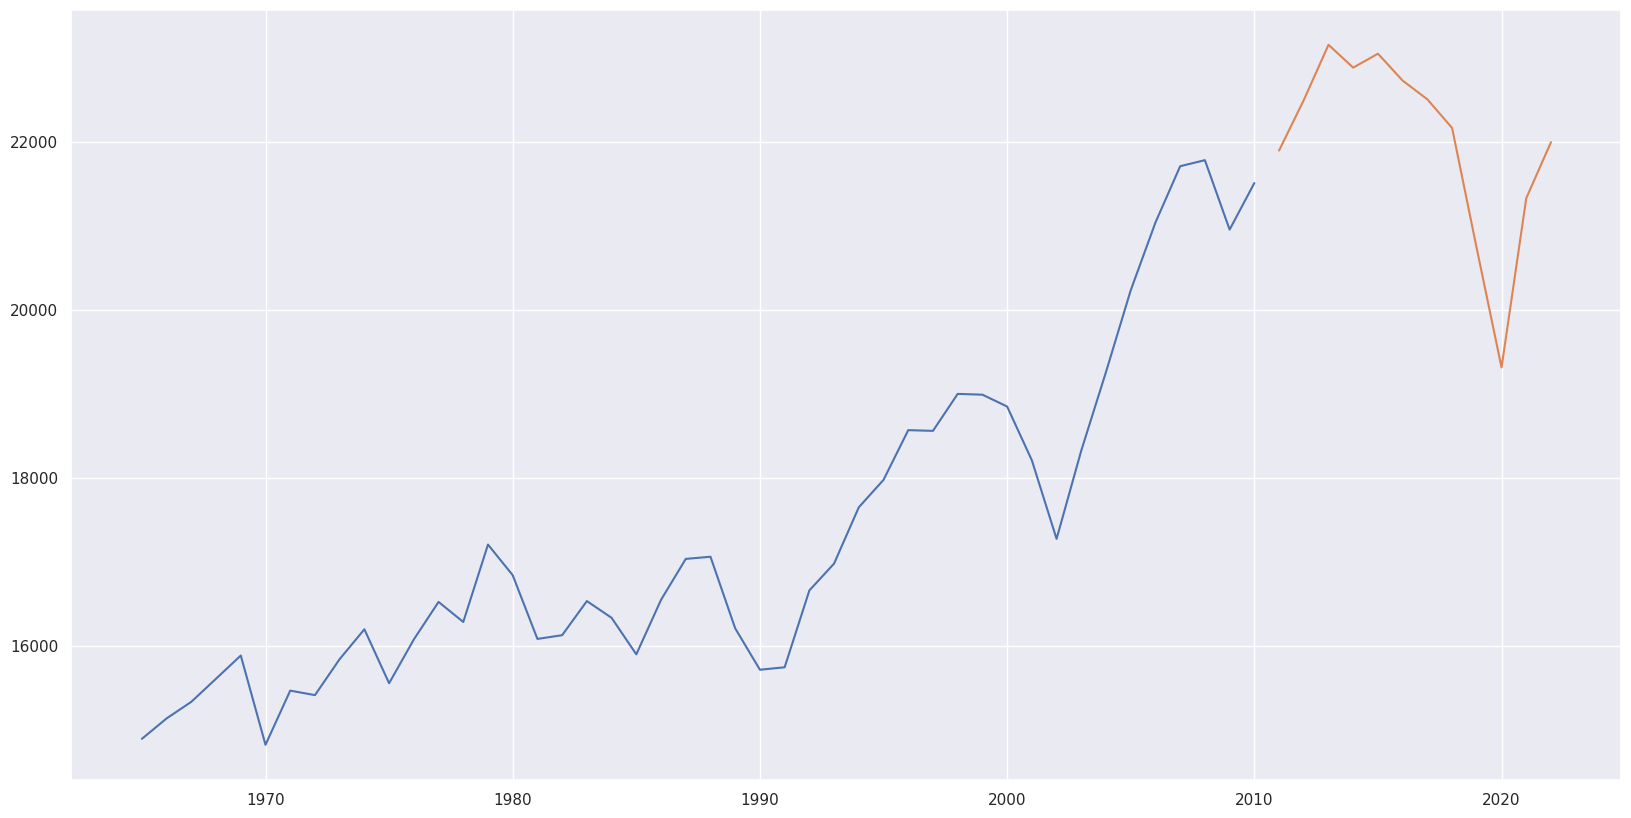

In [90]:

# Visualización Train - Test

plt.plot(train)
plt.plot(test)

In [91]:
# Usamos la funcion auto_arima del paquete pmdarima para optimizar la combinacion de hiperparametros para el modelo SARIMA

stepwise_1=auto_arima(train2, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True,  trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=700.867, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=702.457, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=702.413, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=701.885, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=704.581, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.183 seconds


In [105]:
model_1= sm.tsa.arima.ARIMA(train, order=(0,1,0))
result_1 = model_1.fit()
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     energy_consumption_per_capita   No. Observations:                   46
Model:                            ARIMA(0, 1, 0)   Log Likelihood                -349.942
Date:                           Mon, 13 Nov 2023   AIC                            701.885
Time:                                   15:49:18   BIC                            703.691
Sample:                                        0   HQIC                           702.558
                                            - 46                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.326e+05   1.01e+05      3.305      0.001    1.35e+05     5.3e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                 2.42
Prob(Q):                              0.45   Prob(JB):                         0.30
Heteroskedasticity (H):               1.70   Skew:                            -0.45
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Pruebo otros modelos

In [106]:
model_2= sm.tsa.arima.ARIMA(train, order=(1,1,1))
result_2 = model_2.fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     energy_consumption_per_capita   No. Observations:                   46
Model:                            ARIMA(1, 1, 1)   Log Likelihood                -349.366
Date:                           Mon, 13 Nov 2023   AIC                            704.733
Time:                                   15:49:20   BIC                            710.153
Sample:                                        0   HQIC                           706.753
                                            - 46                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1058      1.223      0.087      0.931      -2.290       2.502
ma.L1          0.0099      1.246      0.008      0.994      -2.432       2.452
sigma2      3.217e+05   9.49e+04      3.388      0.001    1.36e+05    5.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.98   Prob(JB):                         0.39
Heteroskedasticity (H):               1.43   Skew:                            -0.33
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
model_3= sm.tsa.arima.ARIMA(train, order=(0,1,1))
result_3 = model_3.fit()
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     energy_consumption_per_capita   No. Observations:                   46
Model:                            ARIMA(0, 1, 1)   Log Likelihood                -349.371
Date:                           Mon, 13 Nov 2023   AIC                            702.742
Time:                                   15:49:24   BIC                            706.356
Sample:                                        0   HQIC                           704.089
                                            - 46                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1161      0.136      0.854      0.393      -0.150       0.383
sigma2      3.216e+05   9.29e+04      3.463      0.001     1.4e+05    5.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.99   Prob(JB):                         0.39
Heteroskedasticity (H):               1.42   Skew:                            -0.33
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

TRANSFORMACION logaritmica




In [104]:
da_log=da.copy()
da_log = np.log(da_log)


In [108]:
train_log = da_log.iloc[:round(len(da_log)*.80)]

# Seleccionamos el 20% restante para test
test_log = da_log.iloc[round(len(da_log)*.80):]

In [109]:
auto_arima(train_log, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=10, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=-177.406, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=-173.874, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=-173.811, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=-176.610, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[10] intercept   : AIC=-175.791, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[10] intercept   : AIC=-175.670, Time=0.14 sec
 ARIMA(0,1,0)(1,0,1)[10] intercept   : AIC=-174.357, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[10] intercept   : AIC=-175.555, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[10] intercept   : AIC=-175.596, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[10] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[10] intercept
Total fit time: 1.591 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  90.703
Date:                Mon, 13 Nov 2023   AIC                           -177.406
Time:                        15:49:29   BIC                           -173.792
Sample:                             0   HQIC                          -176.059
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0082      0.005      1.521      0.128      -0.002       0.019
sigma2         0.0010      0.000      3.592      0.000       0.000       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 2.73
Prob(Q):                              0.69   Prob(JB):                         0.25
Heteroskedasticity (H):               1.11   Skew:                            -0.53
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
model_LOG= sm.tsa.arima.ARIMA(train_log, order=(1,1,1))
result_LOG = model_LOG.fit()
result_LOG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     energy_consumption_per_capita   No. Observations:                   46
Model:                            ARIMA(1, 1, 1)   Log Likelihood                  90.161
Date:                           Mon, 13 Nov 2023   AIC                           -174.322
Time:                                   15:49:35   BIC                           -168.902
Sample:                                        0   HQIC                          -172.301
                                            - 46                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8696      0.212     -4.098      0.000      -1.286      -0.454
ma.L1          0.9997     23.690      0.042      0.966     -45.432      47.432
sigma2         0.0010      0.024      0.042      0.966      -0.047       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.33
Prob(Q):                              0.97   Prob(JB):                         0.31
Heteroskedasticity (H):               1.06   Skew:                            -0.40
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
da_Rcuadrado=da.copy()
da_Rcuadrado=np.sqrt(da_Rcuadrado)


In [112]:
train_R2 = da_Rcuadrado.iloc[:round(len(da_Rcuadrado)*.80)]

# Seleccionamos el 20% restante para test
test_R2 = da_Rcuadrado.iloc[round(len(da_Rcuadrado)*.80):]

In [113]:
auto_arima(train_R2, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=10, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=199.119, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=202.505, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=202.529, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=200.030, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[10] intercept   : AIC=200.704, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[10] intercept   : AIC=200.836, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[10] intercept   : AIC=202.163, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[10] intercept   : AIC=200.811, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[10] intercept   : AIC=200.738, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[10] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[10] intercept
Total fit time: 0.779 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -97.559
Date:                Mon, 13 Nov 2023   AIC                            199.119
Time:                        15:49:40   BIC                            202.732
Sample:                             0   HQIC                           200.466
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5467      0.348      1.571      0.116      -0.135       1.229
sigma2         4.4732      1.266      3.532      0.000       1.991       6.955
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 2.60
Prob(Q):                              0.57   Prob(JB):                         0.27
Heteroskedasticity (H):               1.34   Skew:                            -0.49
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
model_R2= sm.tsa.arima.ARIMA(train_R2, order=(1,1,1))
result_R2 = model_R2.fit()
result_R2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     energy_consumption_per_capita   No. Observations:                   46
Model:                            ARIMA(1, 1, 1)   Log Likelihood                 -98.146
Date:                           Mon, 13 Nov 2023   AIC                            202.291
Time:                                   15:49:43   BIC                            207.711
Sample:                                        0   HQIC                           204.312
                                            - 46                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8667      0.216     -4.017      0.000      -1.290      -0.444
ma.L1          0.9998     25.139      0.040      0.968     -48.271      50.271
sigma2         4.4475    111.516      0.040      0.968    -214.120     223.015
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.42
Prob(Q):                              0.91   Prob(JB):                         0.30
Heteroskedasticity (H):               1.27   Skew:                            -0.37
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Transformacion de Box y Cox

In [115]:
#BOX & COX
from scipy import stats

da_BoxCox = da.copy()
transform = np.asarray(da_BoxCox['energy_consumption_per_capita'].values)
fitted_data, fitted_lambda = stats.boxcox(transform)
#da['energy_consumption_per_capita'] = fitted_data


In [116]:
da_boxcox=pd.DataFrame(fitted_data, columns=['energy_consumption_per_capita'])


In [117]:
da_boxcox = da_boxcox.set_index(da.index)
da_boxcox.index.name = 'Year'
da_boxcox.head()

energy_consumption_per_capita
Year                               
1965                        0.45775
1966                        0.45775
1967                        0.45775
1968                        0.45775
1969                        0.45775

In [118]:
train_BC = fitted_data[:round(len(fitted_data)*.80)]

# Seleccionamos el 20% restante para test
test_BC = fitted_data[round(len(fitted_data)*.80):]


In [119]:
from scipy.stats import jarque_bera, shapiro, boxcox, probplot

In [120]:
print(f" El lambda óptima aproximado es =  {fitted_lambda}")

 El lambda óptima aproximado es =  -2.1845986155468506


In [121]:
auto_arima(train_BC, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=10, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=-937.797, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=-927.606, Time=0.58 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=-952.831, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=-1045.732, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[10] intercept   : AIC=-937.011, Time=0.30 sec
 ARIMA(0,1,0)(0,0,1)[10] intercept   : AIC=-965.935, Time=0.18 sec
 ARIMA(0,1,0)(1,0,1)[10] intercept   : AIC=-950.812, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[10] intercept   : AIC=-935.486, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[10] intercept   : AIC=-931.453, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[10] intercept   : AIC=-933.797, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[10]          
Total fit time: 2.789 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 523.866
Date:                Mon, 13 Nov 2023   AIC                          -1045.732
Time:                        15:49:54   BIC                          -1043.926
Sample:                             0   HQIC                         -1045.059
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       7.25e-12   2.87e-10      0.025      0.980   -5.55e-10     5.7e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 3.22
Prob(Q):                              0.76   Prob(JB):                         0.20
Heteroskedasticity (H):               0.51   Skew:                            -0.65
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
model_BC= sm.tsa.arima.ARIMA(train_BC, order=(1,1,0))
result_BC = model_BC.fit()
result_BC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 498.384
Date:                Mon, 13 Nov 2023   AIC                           -992.769
Time:                        15:49:54   BIC                           -989.156
Sample:                             0   HQIC                          -991.422
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0027   5.53e-19   4.86e+15      0.000       0.003       0.003
sigma2      2.296e-11   2.89e-10      0.080      0.937   -5.43e-10    5.89e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 3.19
Prob(Q):                              0.74   Prob(JB):                         0.20
Heteroskedasticity (H):               0.51   Skew:                            -0.65
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [123]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cargar los datos y preparar la serie temporal
# (El código para cargar y preparar los datos permanece igual)

# Función para encontrar el mejor modelo SARIMA basado en AIC
def find_best_sarima(train, p_values, d_values, q_values, P_values, D_values, Q_values, M_values):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in M_values:
                                order = (p, d, q)
                                seasonal_order = (P, D, Q, m)
                                try:
                                    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
                                    results = model.fit(disp=False)
                                    aic = results.aic
                                    if aic < best_aic:
                                        best_aic = aic
                                        best_order = order
                                        best_seasonal_order = seasonal_order
                                except:
                                    continue

    return best_order, best_seasonal_order, best_aic

# Define los rangos de órdenes de parámetros a considerar
p_values = range(0, 3)
d_values = [1]
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
M_values = range(2, 7)

# Encuentra el mejor modelo SARIMA basado en AIC
best_order_aic, best_seasonal_order_aic, best_aic = find_best_sarima(train, p_values, d_values, q_values, P_values, D_values, Q_values, M_values)

# Imprime los resultados
print("Mejor modelo SARIMA basado en AIC:")
print(f"Orden de parámetros: {best_order_aic}")
print(f"Orden de parámetros estacional: {best_seasonal_order_aic}")
print(f"AIC: {best_aic}")


Mejor modelo SARIMA basado en AIC:
Orden de parámetros: (2, 1, 1)
Orden de parámetros estacional: (1, 0, 0, 5)
AIC: 10.0


In [124]:
model_4= sm.tsa.arima.ARIMA(train, order=((0,1),1,1),seasonal_order=(1,0,0,5))
result_4 = model_4.fit()
result_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:      energy_consumption_per_capita   No. Observations:                   46
Model:             ARIMA([2], 1, 1)x(1, 0, [], 5)   Log Likelihood                -348.434
Date:                            Mon, 13 Nov 2023   AIC                            704.869
Time:                                    15:54:28   BIC                            712.095
Sample:                                         0   HQIC                           707.563
                                             - 46                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.0100      0.146      0.068      0.946      -0.277       0.297
ma.L1          0.1104      0.142      0.775      0.438      -0.169       0.390
ar.S.L5       -0.1493      0.117     -1.277      0.202      -0.379       0.080
sigma2      3.186e+05   9.34e+04      3.410      0.001    1.36e+05    5.02e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.93   Prob(JB):                         0.46
Heteroskedasticity (H):               1.51   Skew:                            -0.28
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Metricas de performance

In [125]:
#Función para evaluar los modelos contra el test en MSE, MAE, RMSE

def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')


In [126]:
# Utilizando el modelo realizamos la prediccion ---
predicciones_modelo1 = result_1.get_forecast(steps=len(test))
predicciones_modelo2 = result_2.get_forecast(steps=len(test))
predicciones_modelo3 = result_3.get_forecast(steps=len(test))
predicciones_modeloBC= result_BC.get_forecast(steps=len(test))
predicciones_modeloLOG= result_LOG.get_forecast(steps=len(test))
predicciones_modeloR2= result_R2.get_forecast(steps=len(test))
predicciones_modelo4= result_4.get_forecast(steps=len(test))


In [127]:
#Evaluamos las métricas del modelo
evaluar_metricas(test, predicciones_modelo1.predicted_mean )

MSE: 1390457.6828996658
MAE: 1037.0221666666657
RMSE: 1179.176697064382


In [128]:
evaluar_metricas(test, predicciones_modelo2.predicted_mean )

MSE: 1322024.1851666982
MAE: 1001.4084422777956
RMSE: 1149.7931053744835


In [129]:
evaluar_metricas(test, predicciones_modelo3.predicted_mean )

MSE: 1319099.1432692145
MAE: 999.3372345048829
RMSE: 1148.5204148247494


In [130]:
evaluar_metricas(test, predicciones_modelo4.predicted_mean )

MSE: 1497608.9460415964
MAE: 1080.5797405883447
RMSE: 1223.7683383882736


Antitransformo

In [131]:
MSE_LOG = mean_squared_error(np.exp(test_log), np.exp(predicciones_modeloLOG.predicted_mean))
MAE_LOG =mean_absolute_error(np.exp(test_log), np.exp(predicciones_modeloLOG.predicted_mean))
RMSE_LOG = (np.sqrt(mean_squared_error(np.exp(test_log), np.exp(predicciones_modeloLOG.predicted_mean))))
print("Mean Squared Error (MSE) en escala original:", MSE_LOG)
print("Mean Absolute Error (MAE) en escala original:", MAE_LOG)
print("Root Mean Squared Error (RMSE) en escala original:", RMSE_LOG)


Mean Squared Error (MSE) en escala original: 1307520.3530865288
Mean Absolute Error (MAE) en escala original: 996.0862441912526
Root Mean Squared Error (RMSE) en escala original: 1143.4685623516411


In [132]:
MSE_R2 = mean_squared_error((test_R2)** 2, (predicciones_modeloR2.predicted_mean)** 2)
MAE_R2 =mean_absolute_error((test_R2)** 2, (predicciones_modeloR2.predicted_mean)** 2)
RMSE_R2 = np.sqrt(mean_squared_error((test_R2)**2, (predicciones_modeloR2.predicted_mean)**2))
print("Mean Squared Error (MSE) en escala original:", MSE_R2)
print("Mean Absolute Error (MAE) en escala original:", MAE_R2)
print("Root Mean Squared Error (RMSE) en escala original:", RMSE_R2)

Mean Squared Error (MSE) en escala original: 1306278.0513415502
Mean Absolute Error (MAE) en escala original: 995.2182848420811
Root Mean Squared Error (RMSE) en escala original: 1142.925216863094


In [133]:
from scipy.special import inv_boxcox
fitted_lambda

-2.1845986155468506

In [134]:
valores_antitransformados = inv_boxcox(predicciones_modeloBC.predicted_mean, fitted_lambda)
test_antit=inv_boxcox(test_BC, fitted_lambda)

# Convertir los valores antitransformados a un array de tipo numpy
valores_antitransformados = np.array(valores_antitransformados)
#test_antit= np.array(test_antit)

# Calcular MSE, MAE y RMSE en escala original
MSE_BC = mean_squared_error(test, valores_antitransformados)
MAE_BC = mean_absolute_error(test, valores_antitransformados)
RMSE_BC = np.sqrt(mean_squared_error(test, valores_antitransformados))

print("Mean Squared Error (MSE) en escala original:", MSE_BC)
print("Mean Absolute Error (MAE) en escala original:", MAE_BC)
print("Root Mean Squared Error (RMSE) en escala original:", RMSE_BC)


Mean Squared Error (MSE) en escala original: 1388877.3726413138
Mean Absolute Error (MAE) en escala original: 1036.2481250867331
Root Mean Squared Error (RMSE) en escala original: 1178.5064160373986


De acuerdo a todos los criterios evaluados, el modelo R2 resulta tener mejor performance

Analisis de Residuos (Modelo R2)

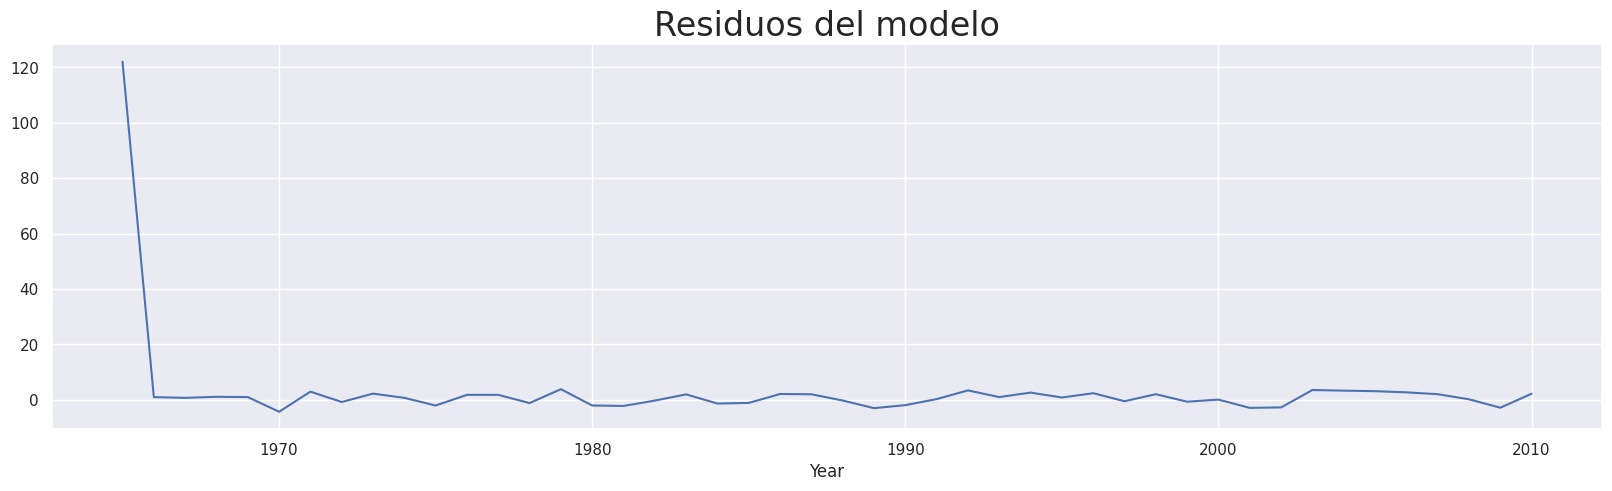

In [135]:
result_R2.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

Text(0.5, 1.0, 'Histograma de los residuos del modelo')

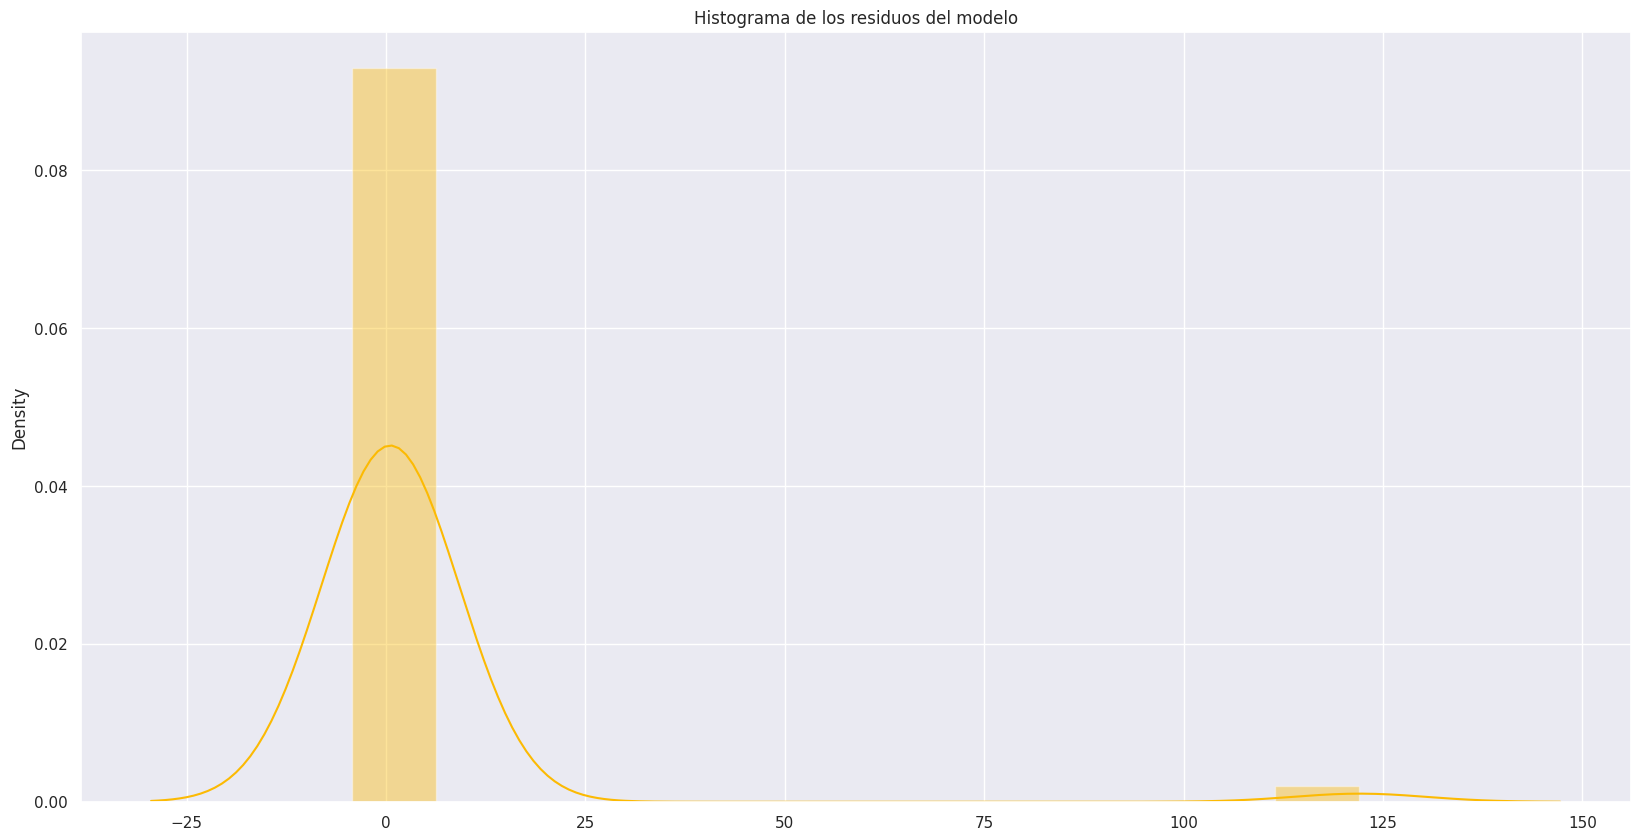

In [ ]:
sns.distplot(result_R2.resid,bins=12,color='#fcba03')
plt.title('Histograma de los residuos del modelo')

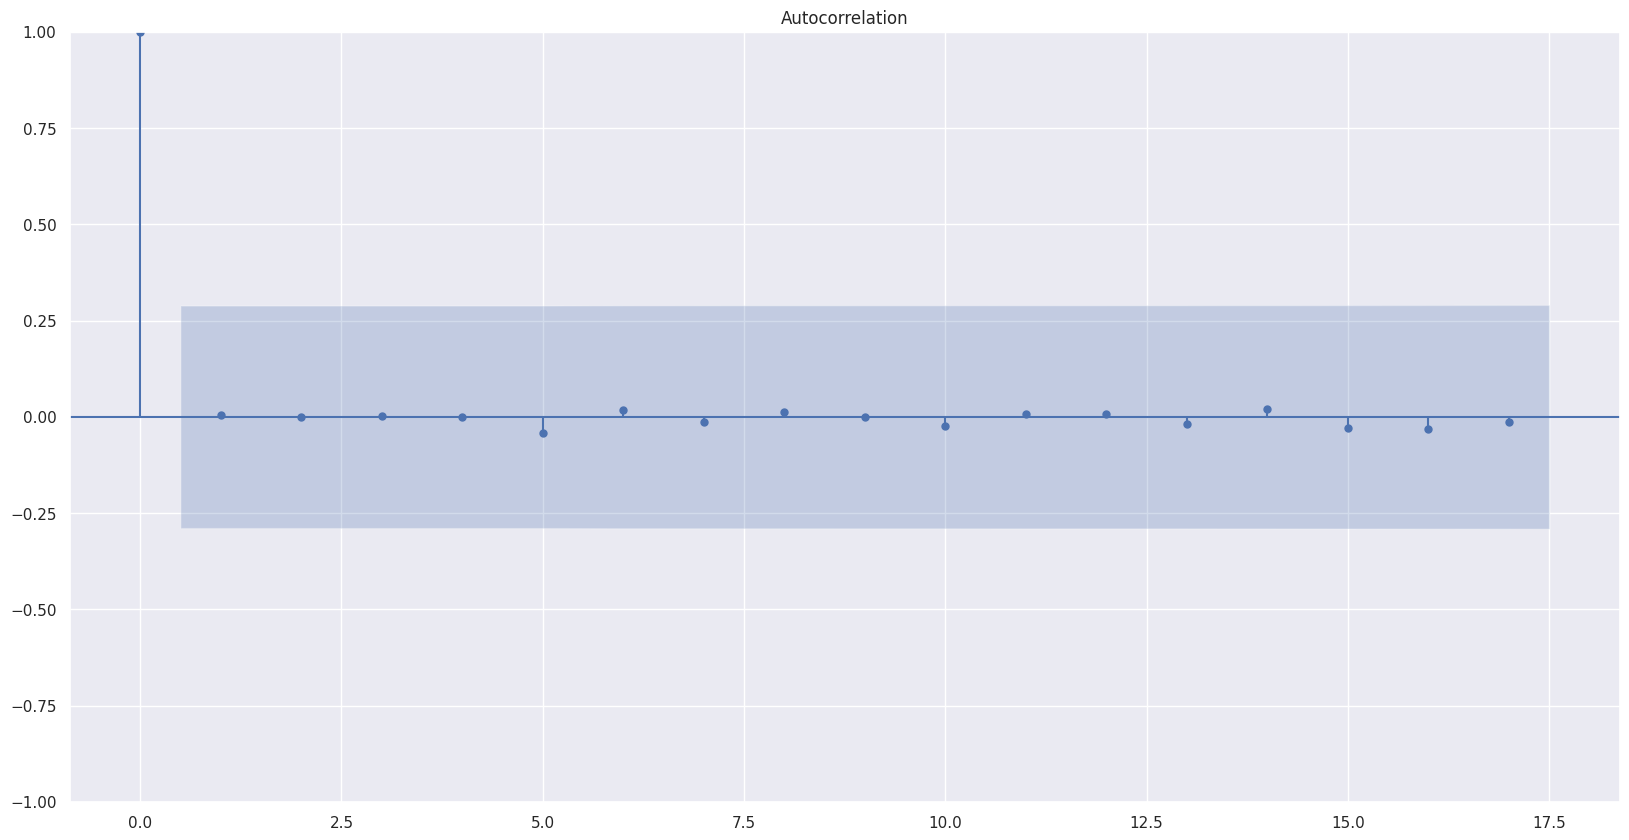

In [ ]:
plot_acf(result_R2.resid);

In [ ]:
import scipy.stats
import pylab

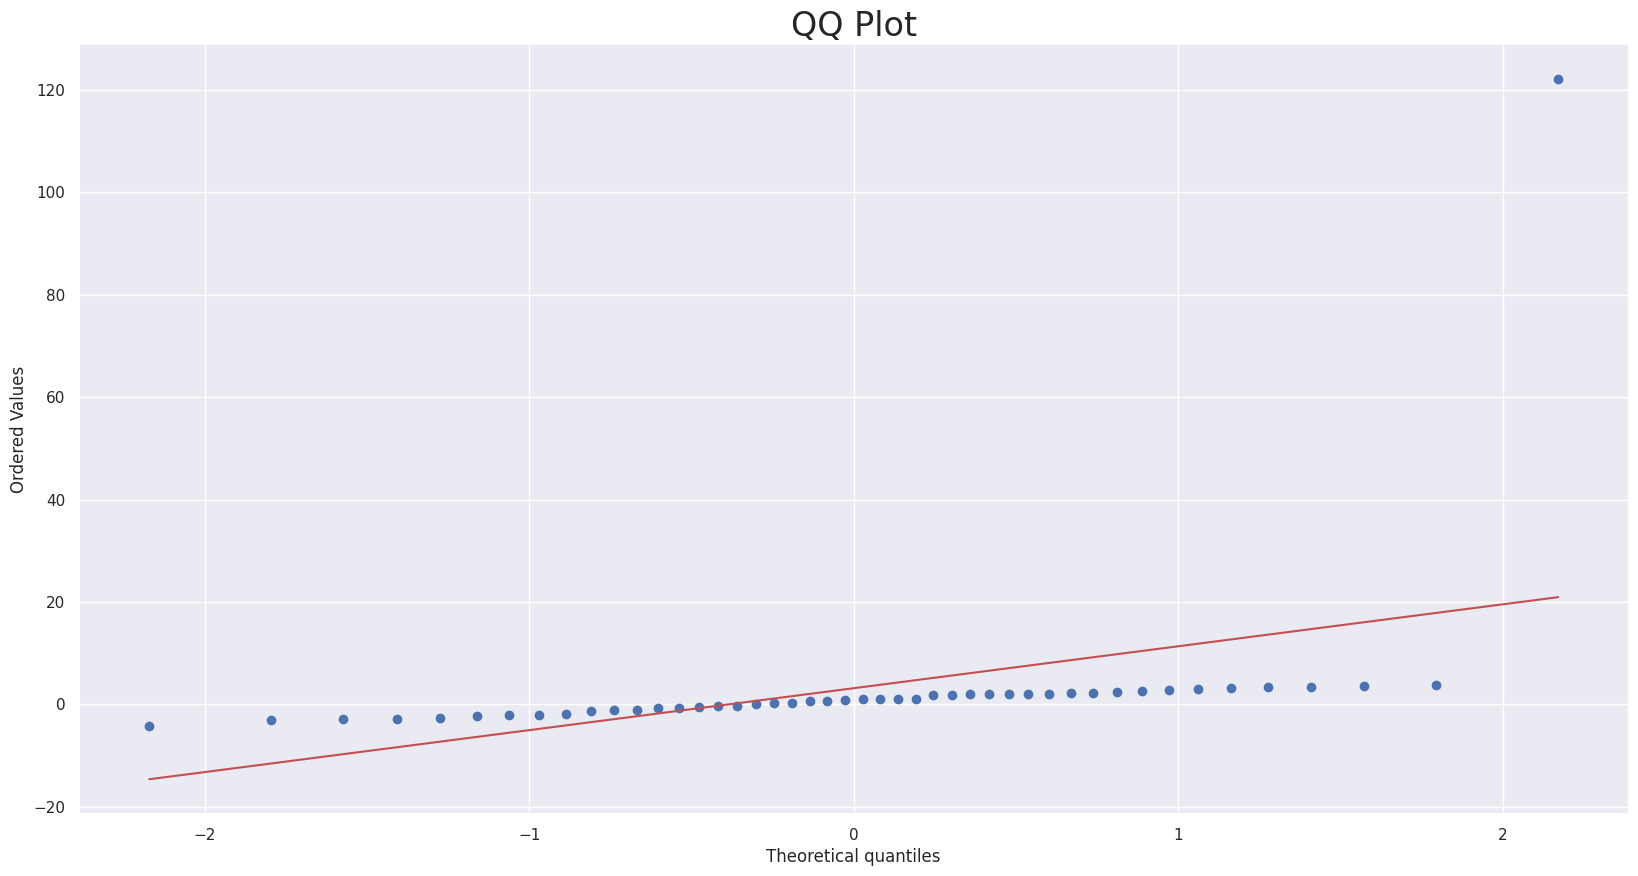

In [ ]:
scipy.stats.probplot(result_R2.resid, plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

Aqui trabajamos con el test de L-Jung Box. Trabajamos la incorrelacion o no de los residuos del modelo. Si hay algun valor que rechazo, entonces algun componente no estoy especificando bien en mi modelo y tiene correlacion. Entonces, tendria que incorporarlo a la especificacion. Este test es fundamental cuando analizo los residuos del modelo que tienen que comportarse como un ruido blanco.

In [ ]:
import statsmodels.api as sm

In [ ]:
Incorr_residuos_modelo=sm.stats.acorr_ljungbox(result_R2.resid, lags=30)

In [ ]:
Incorr_residuos_modelo

lb_stat  lb_pvalue
1   0.000739   0.978314
2   0.000739   0.999631
3   0.000815   0.999994
4   0.000817   1.000000
5   0.099415   0.999840
6   0.114351   0.999970
7   0.124587   0.999995
8   0.135140   0.999999
9   0.135332   1.000000
10  0.170694   1.000000
11  0.173592   1.000000
12  0.176649   1.000000
13  0.202110   1.000000
14  0.229693   1.000000
15  0.285270   1.000000
16  0.356908   1.000000
17  0.373294   1.000000
18  0.374530   1.000000
19  0.411295   1.000000
20  0.446917   1.000000
21  0.448703   1.000000
22  0.448748   1.000000
23  0.483510   1.000000
24  0.649910   1.000000
25  0.761875   1.000000
26  0.792215   1.000000
27  0.808850   1.000000
28  0.821635   1.000000
29  0.823064   1.000000
30  0.846481   1.000000

Text(0, 0.5, 'P-valores ')

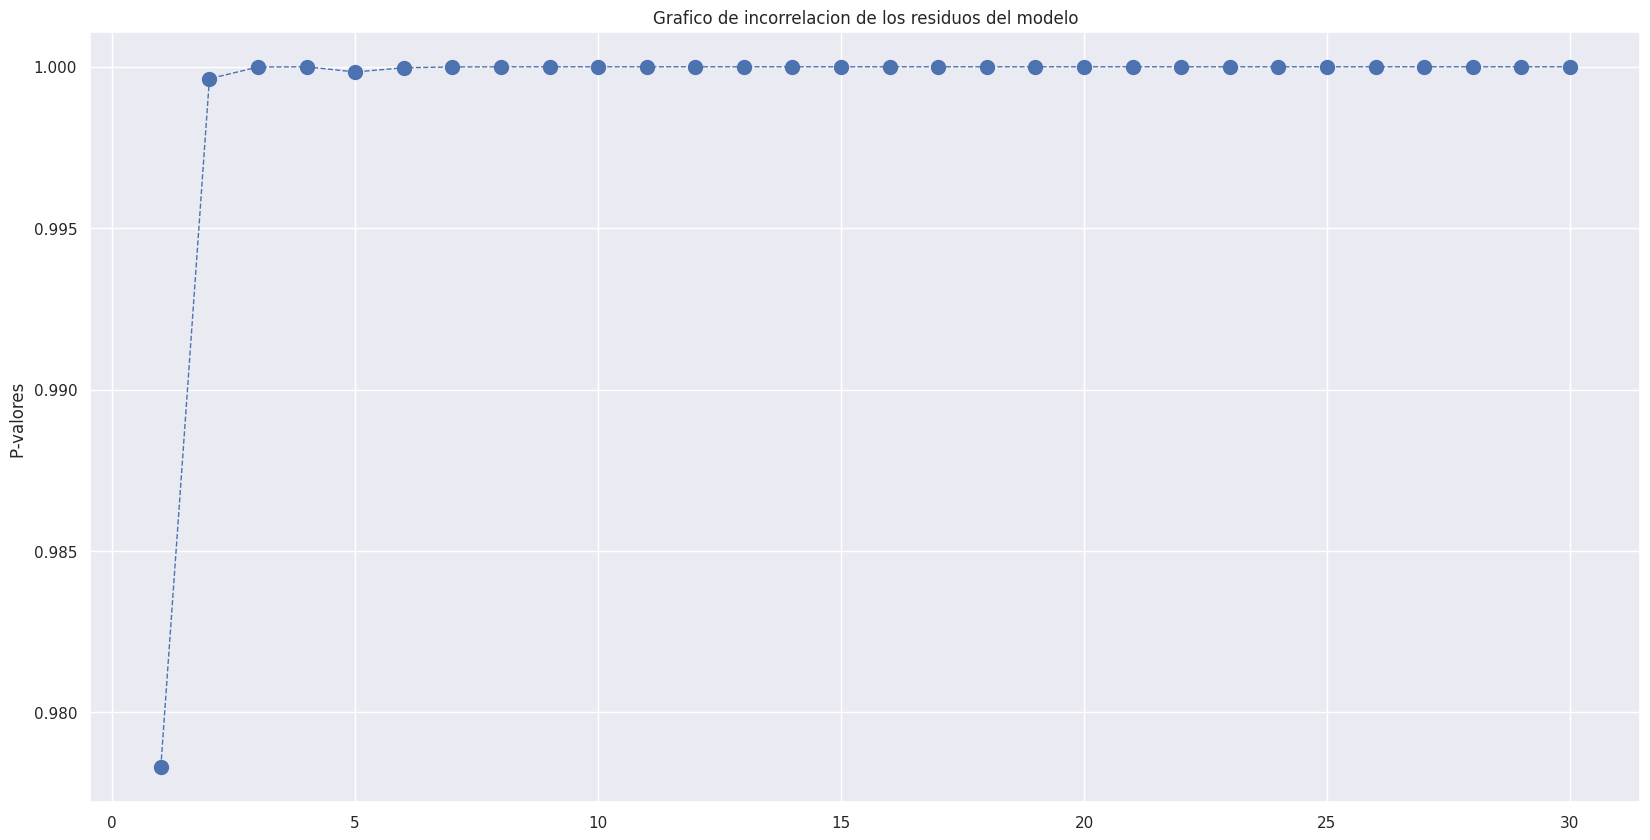

In [ ]:
plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo")
plt.ylabel("P-valores ")

In [ ]:
predictions = result_1.get_forecast(steps=len(test))

forecasted_values = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

mse = mean_squared_error(test, forecasted_values)
mae = mean_absolute_error(test, forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error cuadrático medio (MSE): 1390457.6828996658
Error Absoluto Medio (MAE): 1037.0221666666657


In [ ]:
forecasted_values.index = test.index

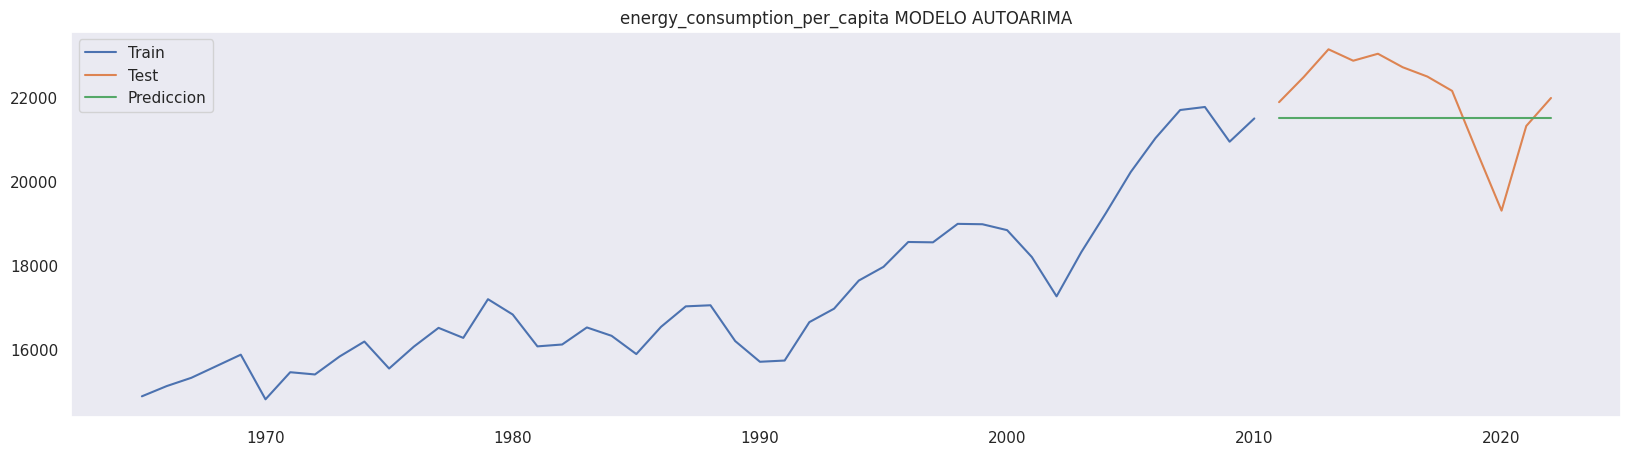

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['energy_consumption_per_capita'], label='Train')
plt.plot(test['energy_consumption_per_capita'], label='Test')
plt.plot(forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('energy_consumption_per_capita MODELO AUTOARIMA')
plt.show()

In [ ]:
forecasted_values

Year
2011    21507.703
2012    21507.703
2013    21507.703
2014    21507.703
2015    21507.703
2016    21507.703
2017    21507.703
2018    21507.703
2019    21507.703
2020    21507.703
2021    21507.703
2022    21507.703
Name: predicted_mean, dtype: float64

In [136]:
predictions = result_3.get_forecast(steps=len(test))

forecasted_values = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

mse = mean_squared_error(test, forecasted_values)
mae = mean_absolute_error(test, forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error cuadrático medio (MSE): 1319099.1432692145
Error Absoluto Medio (MAE): 999.3372345048829


In [137]:
forecasted_values.index = test.index

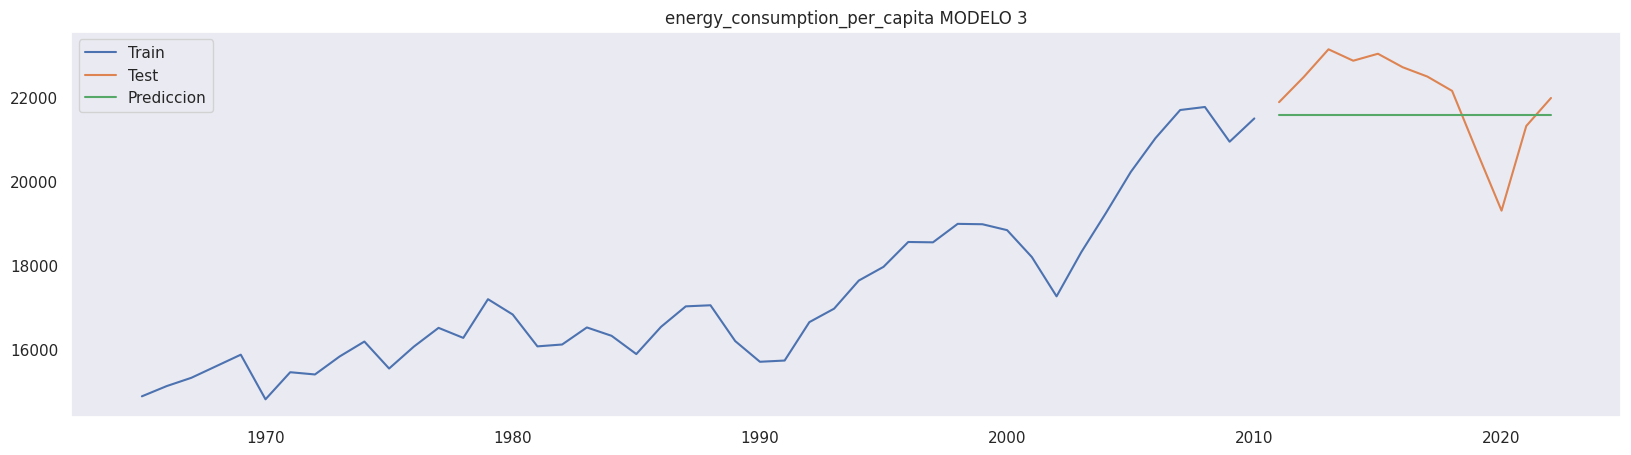

In [138]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['energy_consumption_per_capita'], label='Train')
plt.plot(test['energy_consumption_per_capita'], label='Test')
plt.plot(forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('energy_consumption_per_capita MODELO 3')
plt.show()

In [ ]:
forecasted_values

Year
2011    21466.060772
2012    21373.025527
2013    21363.056872
2014    21486.493360
2015    21403.854409
2016    21410.073745
2017    21423.967243
2018    21425.455919
2019    21407.022529
2020    21419.363419
2021    21418.434655
2022    21416.359869
Name: predicted_mean, dtype: float64

In [ ]:
predictions = result_LOG.get_forecast(steps=len(test))

forecasted_values = np.exp(predictions.predicted_mean)
confidence_intervals = predictions.conf_int()

mse = mean_squared_error(test, forecasted_values)
mae = mean_absolute_error(test, forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error cuadrático medio (MSE): 1307520.3530865342
Error Absoluto Medio (MAE): 996.0862441912537


In [ ]:
forecasted_values.index = test.index

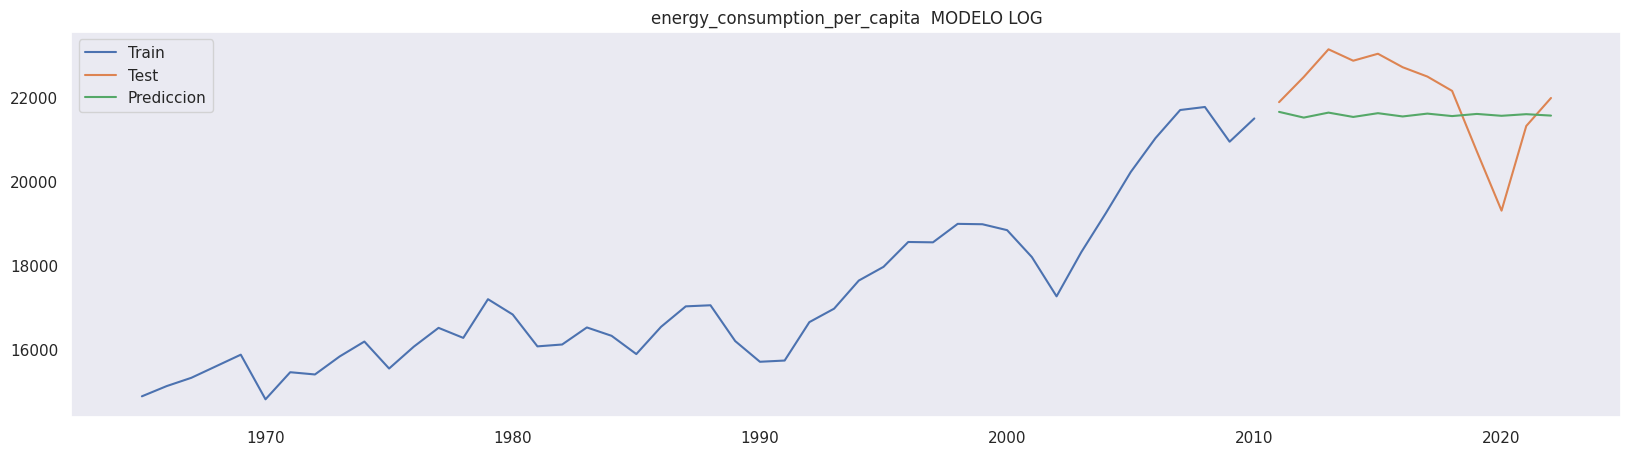

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['energy_consumption_per_capita'], label='Train')
plt.plot(test['energy_consumption_per_capita'], label='Test')
plt.plot(forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('energy_consumption_per_capita  MODELO LOG')
plt.show()

In [ ]:
predictions = result_R2.get_forecast(steps=len(test))

forecasted_values = (predictions.predicted_mean)** 2
confidence_intervals = predictions.conf_int()

mse = mean_squared_error(test, forecasted_values)
mae = mean_absolute_error(test, forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error cuadrático medio (MSE): 1306278.0513415511
Error Absoluto Medio (MAE): 995.2182848420816


In [ ]:
forecasted_values.index = test.index

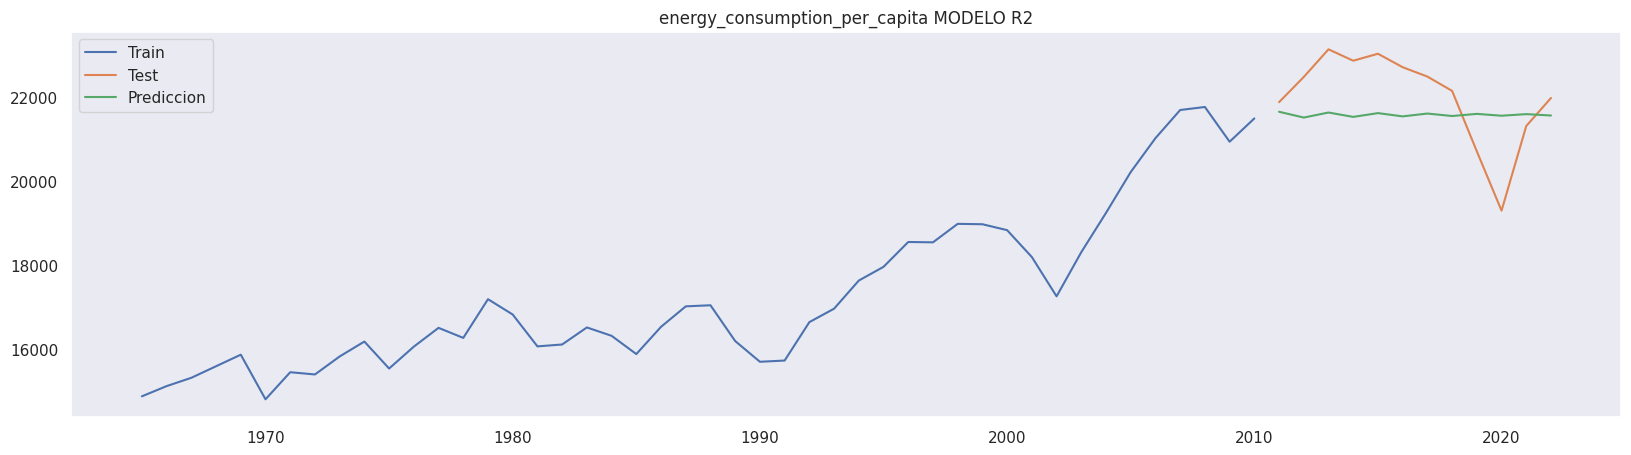

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['energy_consumption_per_capita'], label='Train')
plt.plot(test['energy_consumption_per_capita'], label='Test')
plt.plot(forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('energy_consumption_per_capita MODELO R2')
plt.show()

In [ ]:
forecasted_values

Year
2011    21666.679780
2012    21528.863579
2013    21648.281056
2014    21544.764946
2015    21634.466207
2016    21556.712935
2017    21624.092243
2018    21565.689706
2019    21616.301596
2020    21572.433734
2021    21610.450665
2022    21577.500125
Name: predicted_mean, dtype: float64

In [ ]:
predictions = result_BC.get_forecast(steps=len(test))

forecasted_values = inv_boxcox(predictions.predicted_mean,fitted_lambda)
confidence_intervals = predictions.conf_int()

mse = mean_squared_error(test, forecasted_values)
mae = mean_absolute_error(test, forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error cuadrático medio (MSE): 1388877.3726413138
Error Absoluto Medio (MAE): 1036.2481250867331


In [ ]:
2.- Graficar las series originales.  Analizar si es necesario diferenciarlas para convertirlas en estacionarias.
Exponer los conceptos relacionados con la estacionariedad de la serie



# Bibliotecas y funciones

In [1]:
#Módulos a instalar
!pip install pmdarima
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 16.8 MB/s eta 0:00:00


Instalamos las librerias

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.tsa.stattools as tsa
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import ADFTest
from matplotlib import pyplot

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from datetime import timedelta
import statsmodels.api as sm

In [4]:
## Función para dibujar juntos FAS: autocovarianzas; FAC (autocorrelacion ) y FACP (autocorrelación parcial)
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  axes[2,1].set_xlabel('Lag')

  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Serie 1: Residentes')
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')

  plot_acf(serie_nr, lags=nrol, ax= axes[0,1], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Repito grafico: Residentes')
  plot_pacf(serie_nr, lags=nrol, ax= axes[1,1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,1].plot(tsa.acovf(serie_nr,fft=False, nlag=nrol), color='r', label='AutoCov')

  p1.legend()
  plt.show()

In [5]:
def print_test_afd(y):
  resultado = tsa.adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

Importo serie


In [6]:

# Leer set de datos
df = pd.read_csv("/content/Poblacion.csv", sep=";")
df


Year       Pais     Hombres     Mujeres   Población
0   2021  Argentina  22.678.199  23.130.548  45.808.747
1   2020  Argentina  22.465.694  22.911.069  45.376.763
2   2019  Argentina  22.249.019  22.689.693  44.939.000
3   2018  Argentina  22.027.014  22.467.488  44.495.000
4   2017  Argentina  21.800.696  22.244.116  44.045.000
5   2016  Argentina  21.571.303  22.019.065  43.590.000
6   2015  Argentina  21.340.426  21.791.541  43.132.000
7   2014  Argentina  21.106.519  21.562.981  42.670.000
8   2013  Argentina  20.870.445  21.332.490  42.203.000
9   2012  Argentina  20.634.269  21.099.001  41.733.000
10  2011  Argentina  20.395.723  20.865.767  41.261.000
11  2010  Argentina  20.154.486  20.633.966  40.788.000
12  2009  Argentina  20.095.357  20.588.982  40.134.000
13  2008  Argentina  19.886.051  20.387.718  39.746.000
14  2007  Argentina  19.685.381  20.190.731  39.356.000
15  2006  Argentina  19.484.104  19.992.747  38.971.000
16  2005  Argentina  19.279.145  19.791.355  38.592.000
17  2004  Argentina  19.077.001  19.591.796  38.226.000
18  2003  Argentina  18.879.701  19.398.462  37.870.000
19  2002  Argentina  18.683.681  19.201.347  37.516.000
20  2001  Argentina  18.484.124  18.996.369  37.156.000
21  2000  Argentina  18.280.746  18.790.028  36.784.000
22  1999  Argentina  18.072.503  18.580.528  36.399.000
23  1998  Argentina  17.863.135  18.370.060  36.005.000
24  1997  Argentina  17.655.867  18.160.104  35.604.000
25  1996  Argentina  17.443.158  17.946.204  35.196.000
26  1995  Argentina  17.220.607  17.725.502  34.779.000
27  1994  Argentina  16.989.567  17.499.129  34.353.000
28  1993  Argentina  16.757.748  17.269.492  33.917.000
29  1992  Argentina  16.529.209  17.039.077  33.420.000
30  1991  Argentina  16.298.168  16.807.594  32.970.000
31  1990  Argentina  16.063.515  16.574.141  32.530.000
32  1989  Argentina  15.827.047  16.338.719  31.860.000
33  1988  Argentina  15.589.854  16.100.939  31.470.000
34  1987  Argentina  15.353.727  15.862.727  31.090.000
35  1986  Argentina  15.121.779  15.626.548  30.740.000
36  1985  Argentina  14.894.307  15.392.805  30.350.000
37  1984  Argentina  14.672.462  15.159.735  29.840.000
38  1983  Argentina  14.452.651  14.924.486  29.340.000
39  1982  Argentina  14.234.248  14.688.513  28.930.000
40  1981  Argentina  14.018.171  14.453.114  28.450.000
41  1980  Argentina  13.804.052  14.220.750  27.950.000
42  1979  Argentina  13.592.350  13.991.784  27.584.134
43  1978  Argentina  13.382.114  13.764.006  27.146.121
44  1977  Argentina  13.175.780  13.538.001  26.713.780
45  1976  Argentina  12.975.103  13.315.154  26.290.257
46  1975  Argentina  12.779.176  13.096.382  25.875.558
47  1974  Argentina  12.580.117  12.869.638  25.449.754
48  1973  Argentina  12.381.457  12.639.130  25.020.588
49  1972  Argentina  12.193.317  12.419.477  24.612.794
50  1971  Argentina  12.014.710  12.208.669  24.223.379
51  1970  Argentina  11.837.757  12.005.045  23.842.803
52  1969  Argentina  11.663.371  11.808.657  23.472.028
53  1968  Argentina  11.495.179  11.617.792  23.112.971
54  1967  Argentina  11.327.623  11.429.390  22.757.014
55  1966  Argentina  11.160.113  11.243.003  22.403.116
56  1965  Argentina  10.994.680  11.058.981  22.053.661

2.- Graficar la serie, analizar si es necesario convertirla en estacionaria. Exponer conceptos relacionados a la estacionariedad.

In [7]:
df.dtypes #Verifico el campo fecha

Year          int64
Pais         object
Hombres      object
Mujeres      object
Población    object
dtype: object

In [9]:
cols =["Year","Población"]
df_arg = df.loc[:,cols]
df_arg.set_index("Year",inplace=True)
df_arg.head()





Población
Year            
2021  45.808.747
2020  45.376.763
2019  44.939.000
2018  44.495.000
2017  44.045.000

In [10]:
df_arg.dtypes

Población    object
dtype: object

In [11]:
df_arg['Población'] = df_arg['Población'].str.replace('.', '').astype(float)


<ipython-input-11-b901596ae196>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_arg['Población'] = df_arg['Población'].str.replace('.', '').astype(float)


# Punto 2.Graficamos la serie

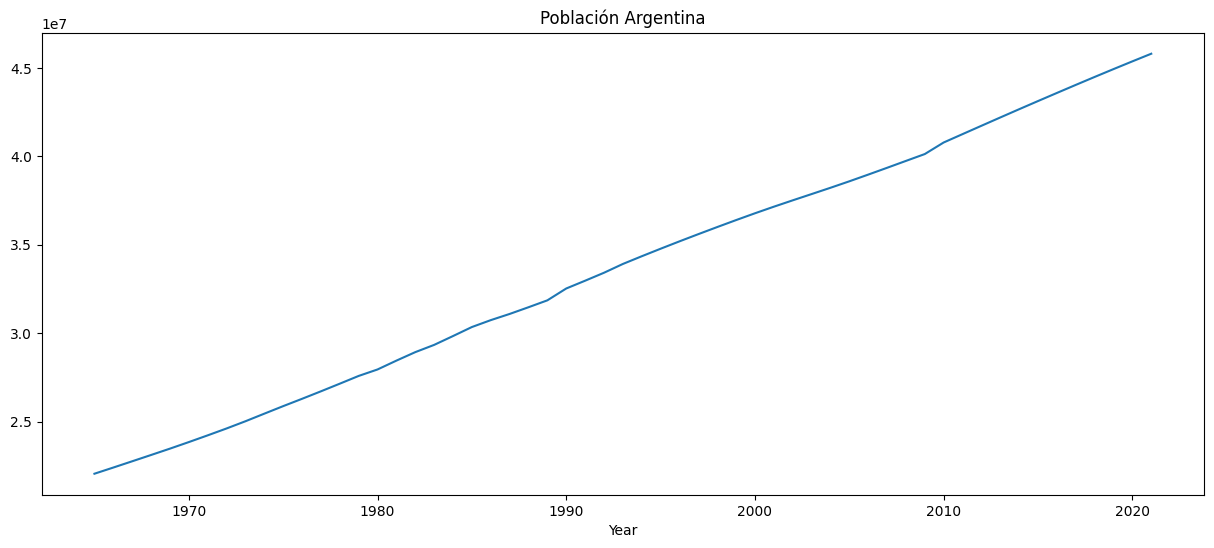

In [12]:
df_arg["Población"].plot(figsize=(15,6))
plt.xlabel("Year")
plt.ylabel=("Población")
plt.title("Población Argentina")
plt.show()

In [13]:
adfuller(df_arg['Población'])   #Analizo si es estacionaria

(-1.4378380359942582,
 0.5640077585670986,
 1,
 55,
 {'1%': -3.5552728880540942,
  '5%': -2.9157312396694217,
  '10%': -2.5956695041322315},
 1130.8949500191268)


Obtenemos p-value para test de dickey fuller (0.56),  no tenemos información suficiente para rechazar H0 (indica presencia raices unitarias) por lo que es necesario diferenciar la serie para hacerla estacionaria
> Bloque con sangría



Punto 3: Graficar FAS, FAC y FACP en un solo grafico y analizarla.

<Figure size 1500x600 with 0 Axes>

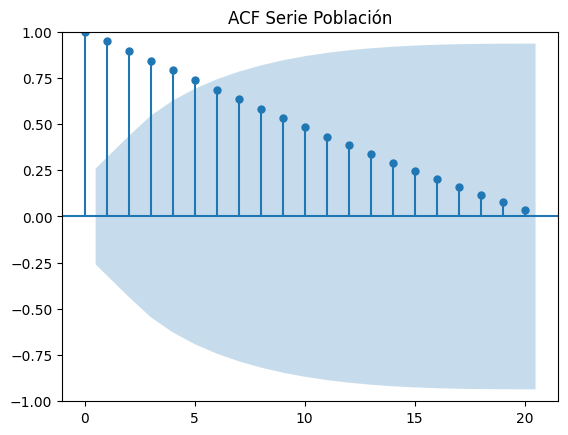

<Figure size 1500x600 with 0 Axes>

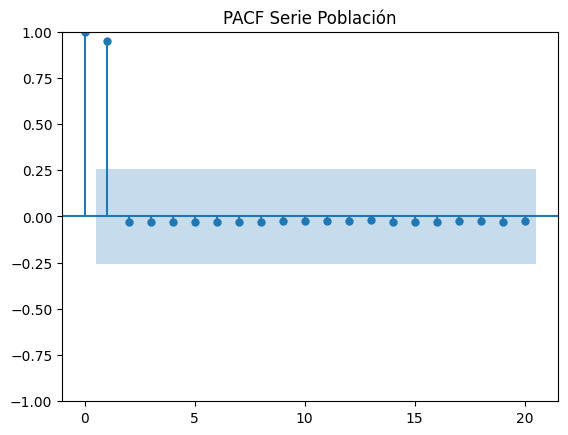

In [14]:
plt.figure(figsize=(15,6))
plot_acf(df_arg["Población"], lags=20, title="ACF Serie Población")
plt.show()
plt.figure(figsize=(15,6))
plot_pacf(df_arg["Población"], lags=20, title="PACF Serie Población")
plt.show()





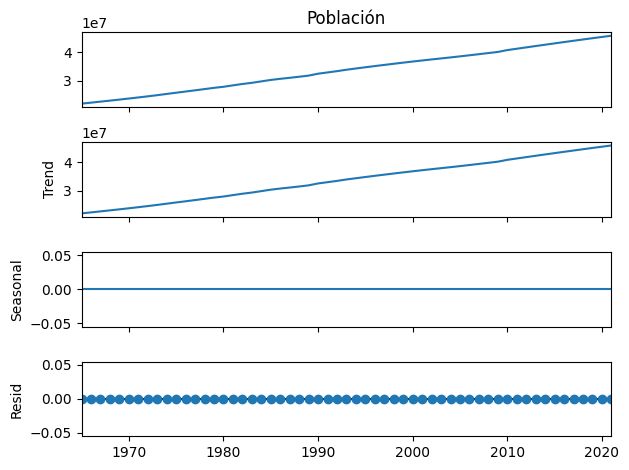

In [ ]:
df_arg.sort_index(inplace=True)
s_dec_additive = seasonal_decompose(df_arg['Población'], model="additive", period=1)  # Periodo de 1 dato anual
s_dec_additive.plot()
plt.show()

En la grafica puede verificarse la no estacionariedad de la seria (validad por test de DF).  La funcion de ACF decrece en forma constante.
En el grafico de autocorrelación parcial podria indicar que un modelo de orden uno podria ser util para modelar la serie.

En el ultimo grafico se puede visualizar que la serie no tiene estacionalidad,  tiene una clara tendencia creciente.

# Punto 4:  Pruebas de raices unitarias

Cargamos funciones
Prueba de Dickey-Fuller aumentada
Prueba de Kwiatkowski-Phillips-Schmidt-Shin
Prueba de Phillips-Perron

In [ ]:
def estacionario(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

In [ ]:
estacionario(df_arg)

Estimado de número de diferencias con ADF test
2
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.32761832004601665, True)


Al realizar las 3 pruebas diferentes:
ADF - Dickey Fuller aumentada -  Indica que debe diferenciarse 2 veces para lograr estacionariedad
KPSS - Kwiatkowski-Phillips-Schdmit - Indica que debe diferenciarse 1 vez
PP - Phillips-Perron - Indica que debe diferenciarse 1 vez.

Aplicar diferencia 1 orden implica restar al valor actual el anterior,  la de 2 orden vuelve a repetirse pero con el valor anterior al 1.

# Punto 5: Identificación del orden a utilizar

In [ ]:
auto_arima(df_arg, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True, information_criterion='aic').summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1400.953, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1669.076, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1403.313, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1613.450, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=1402.653, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1402.635, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=1404.630, Time=1.33 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1681.599, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1401.715, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1401.774, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 2.630 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -698.476
Date:                Tue, 07 Nov 2023   AIC                           1400.953
Time:                        21:15:21   BIC                           1405.004
Sample:                             0   HQIC                          1402.523
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.242e+05   1.18e+04     35.881      0.000    4.01e+05    4.47e+05
sigma2      3.993e+09   5.77e+08      6.917      0.000    2.86e+09    5.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   6.14   Jarque-Bera (JB):                82.17
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             1.81
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima(df_arg, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True, information_criterion='bic').summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=1405.004, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=1677.177, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=1411.414, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=1615.475, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : BIC=1408.729, Time=0.24 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : BIC=1408.711, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : BIC=1412.732, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=1687.675, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=1407.791, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : BIC=1409.876, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 1.567 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -698.476
Date:                Tue, 07 Nov 2023   AIC                           1400.953
Time:                        21:15:32   BIC                           1405.004
Sample:                             0   HQIC                          1402.523
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.242e+05   1.18e+04     35.881      0.000    4.01e+05    4.47e+05
sigma2      3.993e+09   5.77e+08      6.917      0.000    2.86e+09    5.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   6.14   Jarque-Bera (JB):                82.17
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             1.81
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima(df_arg, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True, information_criterion='aicc').summary()

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AICC=1401.175, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AICC=1669.845, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AICC=1404.082, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AICC=1613.523, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AICC=1403.106, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AICC=1403.088, Time=0.11 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AICC=1405.400, Time=1.25 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AICC=1682.052, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AICC=1402.167, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AICC=1402.543, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 2.836 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -698.476
Date:                Tue, 07 Nov 2023   AIC                           1400.953
Time:                        21:15:40   BIC                           1405.004
Sample:                             0   HQIC                          1402.523
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.242e+05   1.18e+04     35.881      0.000    4.01e+05    4.47e+05
sigma2      3.993e+09   5.77e+08      6.917      0.000    2.86e+09    5.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   6.14   Jarque-Bera (JB):                82.17
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             1.81
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima(df_arg, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True, information_criterion='aicc').summary()

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AICC=1401.175, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AICC=1669.845, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AICC=1404.082, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AICC=1613.523, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AICC=1403.106, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AICC=1403.088, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AICC=1405.400, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AICC=1682.052, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AICC=1402.167, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AICC=1402.543, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 1.367 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -698.476
Date:                Tue, 07 Nov 2023   AIC                           1400.953
Time:                        21:15:46   BIC                           1405.004
Sample:                             0   HQIC                          1402.523
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.242e+05   1.18e+04     35.881      0.000    4.01e+05    4.47e+05
sigma2      3.993e+09   5.77e+08      6.917      0.000    2.86e+09    5.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   6.14   Jarque-Bera (JB):                82.17
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             1.81
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima(df_arg, trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1403.208, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1400.953, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1681.599, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1401.715, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1613.450, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1401.774, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.100 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

El modelo seleccionado es ARIMA(0,1,0)(0,0,0)[0].   ES un modelo sin termino autorregresivo ni de media móvil con una diferenciación no estacional de primer orden (d=1) y sin periodicidad estacional.

PAra todos los criterios de información aplicados, selecciona ese modelo

Punto 6: Métricas de performace en entrenamiento y testeo

In [ ]:
df_arg.dtypes

Población    float64
dtype: object

In [ ]:
df_arg.tail()

Población
Year            
2017  44045000.0
2018  44495000.0
2019  44939000.0
2020  45376763.0
2021  45808747.0

In [ ]:
import pandas as pd

# Supongamos que tienes un DataFrame llamado 'df_arg' con 'Year' como índice
# y 'Poblacion' como una columna de tipo float64

# Convierte el índice a objetos datetime solo con el año
df_arg.index = pd.to_datetime(df_arg.index, format='%Y')

# Define el año de inicio para el conjunto de entrenamiento y prueba
año_inicio_entrenamiento = 1965
año_inicio_prueba = 2010

# Divide el DataFrame en conjuntos de entrenamiento y prueba
train = df_arg[df_arg.index.year < año_inicio_prueba]
test = df_arg[df_arg.index.year >= año_inicio_prueba]

# 'train' contendrá datos con años anteriores a 2010
# 'test' contendrá datos a partir de 2010 en adelante

auto_arima_model = sm.tsa.SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
auto_arima_results = auto_arima_model.fit()

auto_arima_predictions = auto_arima_results.get_forecast(steps=len(test))

auto_arima_forecasted_values = auto_arima_predictions.predicted_mean
confidence_intervals = auto_arima_predictions.conf_int()

mse = mean_squared_error(test, auto_arima_forecasted_values)
mae = mean_absolute_error(test, auto_arima_forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")


Error cuadrático medio (MSE): 12749185615681.5
Error Absoluto Medio (MAE): 3202792.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Punto 7: Comparación con otros modelos

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cargar los datos y preparar la serie temporal
# (El código para cargar y preparar los datos permanece igual)

# Función para encontrar el mejor modelo SARIMA basado en AIC
def find_best_sarima(train_data, p_values, d_values, q_values, P_values, D_values, Q_values, M_values):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in M_values:
                                order = (p, d, q)
                                seasonal_order = (P, D, Q, m)
                                try:
                                    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
                                    results = model.fit(disp=False)
                                    aic = results.aic
                                    if aic < best_aic:
                                        best_aic = aic
                                        best_order = order
                                        best_seasonal_order = seasonal_order
                                except:
                                    continue

    return best_order, best_seasonal_order, best_aic

# Define los rangos de órdenes de parámetros a considerar
p_values = range(0, 3)
d_values = [1]
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
M_values = range(2, 7)

# Encuentra el mejor modelo SARIMA basado en AIC
best_order_aic, best_seasonal_order_aic, best_aic = find_best_sarima(train, p_values, d_values, q_values, P_values, D_values, Q_values, M_values)

# Imprime los resultados
print("Mejor modelo SARIMA basado en AIC:")
print(f"Orden de parámetros: {best_order_aic}")
print(f"Orden de parámetros estacional: {best_seasonal_order_aic}")
print(f"AIC: {best_aic}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be use

Mejor modelo SARIMA basado en AIC:
Orden de parámetros: (2, 1, 0)
Orden de parámetros estacional: (0, 0, 1, 6)
AIC: 8.0


# Punto 8: Analisis de residuos del modelo
Dado que en el punto anterior se ha encontrado un modelo que posee mejores metricas de error.  Se avanzara en el analisis de ese modelo.  Se selecciono utilizando el criterio de akaike (valor AIC mas bajo).   El orden de parametros (1,1,0) se refiere a los componentes SARIMA.  Tiene un componente autorregresivo de orden 1,  un componente integrado de orden 1 y un componente MA de orden 0


In [ ]:
order = (1, 1 , 0)
seasonal_order = (1, 0, 0, 3)



# Crea el modelo SARIMA sin el coeficiente no significativo
model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)

# Ajusta el modelo a los datos
results = model.fit()

# Muestra el nuevo resumen del modelo
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                         Población   No. Observations:                   45
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 3)   Log Likelihood               -1277.418
Date:                           Tue, 07 Nov 2023   AIC                           2560.836
Time:                                   21:25:36   BIC                           2566.188
Sample:                               01-01-1965   HQIC                          2562.821
                                    - 01-01-2009                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0292      0.001     42.950      0.000       0.028       0.031
ar.S.L3        0.0290      0.001     42.221

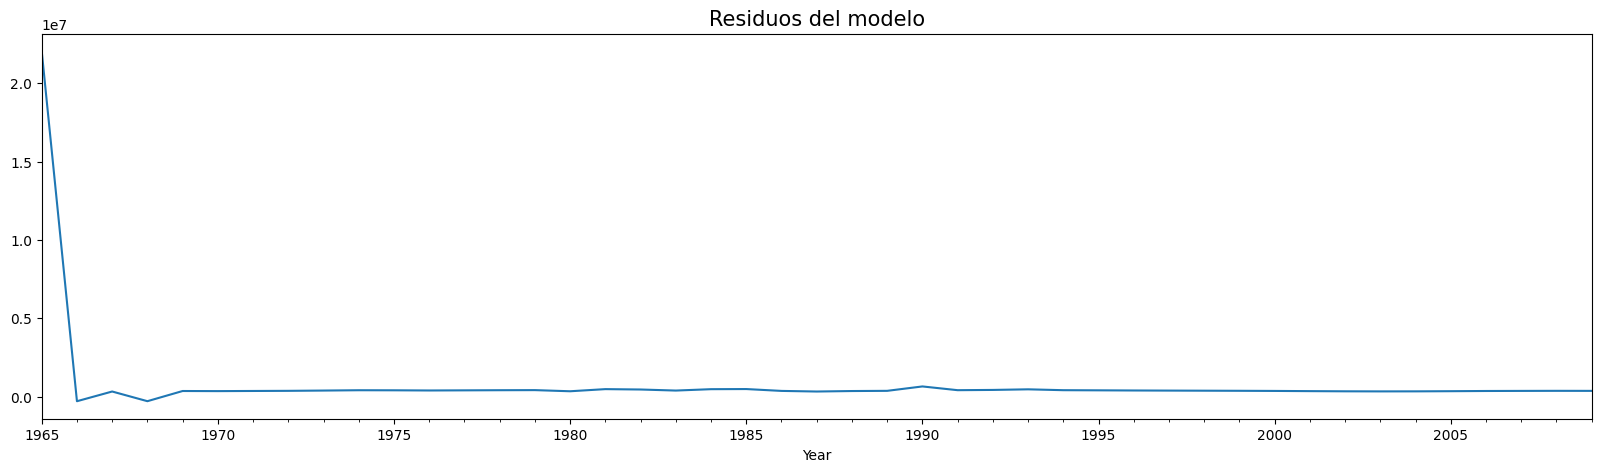

In [ ]:
results.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=15)
plt.show()

<ipython-input-32-c8516847380e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid, bins=15, color='#fcba03')


Text(0.5, 1.0, 'Histograma de los residuos del modelo')

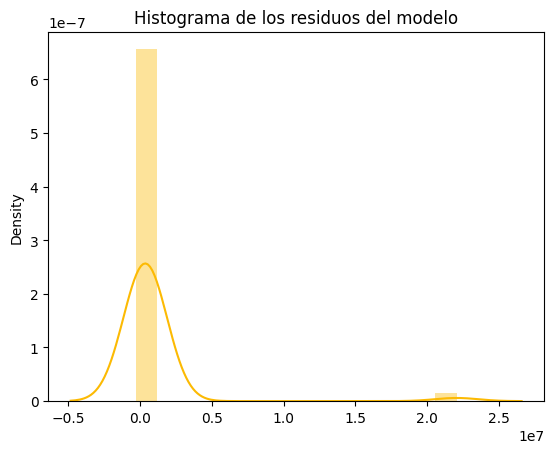

In [ ]:
import seaborn as sns
sns.distplot(results.resid, bins=15, color='#fcba03')
plt.title('Histograma de los residuos del modelo')


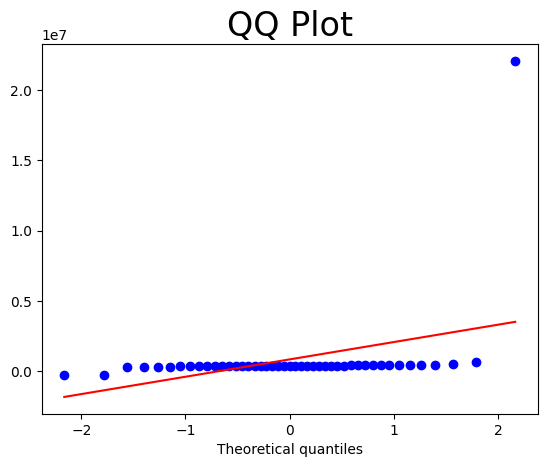

In [ ]:
import scipy.stats
import pylab
import matplotlib.pyplot as plt

scipy.stats.probplot(results.resid, plot=pylab)
plt.title("QQ Plot", size=24)
pylab.show()

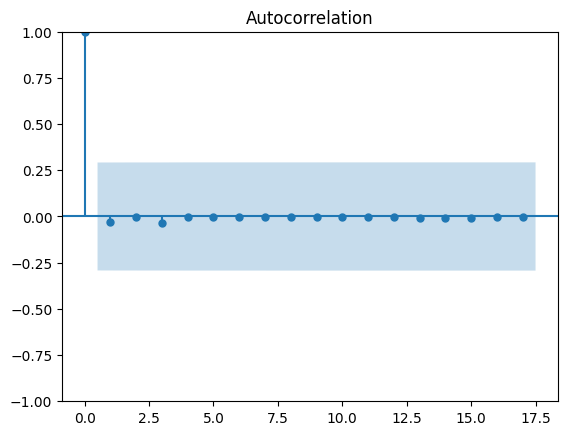

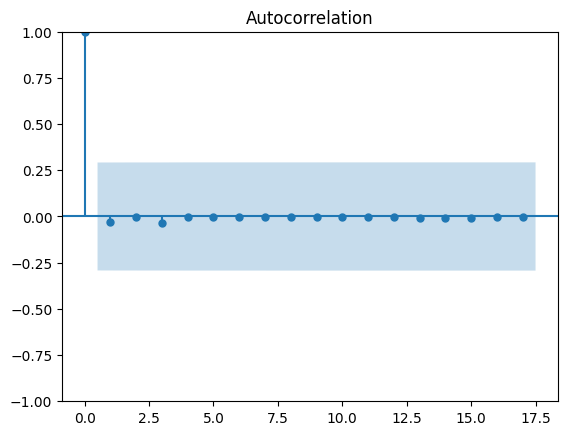

In [ ]:
plot_acf(results.resid)

In [ ]:
Incorr_residuos_modelo=sm.stats.acorr_ljungbox(results.resid, lags=30)
Incorr_residuos_modelo

lb_stat  lb_pvalue
1   0.046181   0.829847
2   0.046421   0.977057
3   0.100355   0.991795
4   0.100945   0.998768
5   0.101894   0.999830
6   0.102930   0.999978
7   0.104088   0.999997
8   0.105103   1.000000
9   0.105923   1.000000
10  0.107131   1.000000
11  0.108979   1.000000
12  0.110868   1.000000
13  0.112997   1.000000
14  0.115210   1.000000
15  0.121703   1.000000
16  0.122728   1.000000
17  0.124685   1.000000
18  0.130436   1.000000
19  0.132320   1.000000
20  0.133963   1.000000
21  0.143316   1.000000
22  0.159074   1.000000
23  0.172714   1.000000
24  0.187763   1.000000
25  0.187848   1.000000
26  0.199841   1.000000
27  0.211750   1.000000
28  0.220730   1.000000
29  0.237764   1.000000
30  0.258768   1.000000

TypeError: ignored

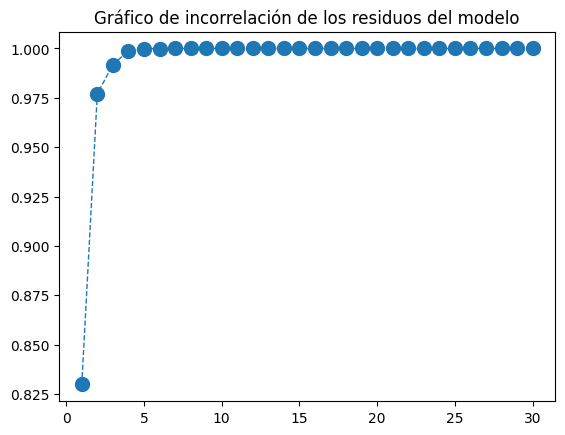

In [ ]:
plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Gráfico de incorrelación de los residuos del modelo")
plt.ylabel("P-valores")


Punto 9: Pronóstico

In [ ]:
predictions = results.get_forecast(steps=len(test))

forecasted_values = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

mse = mean_squared_error(test, forecasted_values)
mae = mean_absolute_error(test, forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

forecasted_values.index = test.index  #agregado con recomendacion Vero

Error cuadrático medio (MSE): 12459740315942.203
Error Absoluto Medio (MAE): 3159677.6817414253


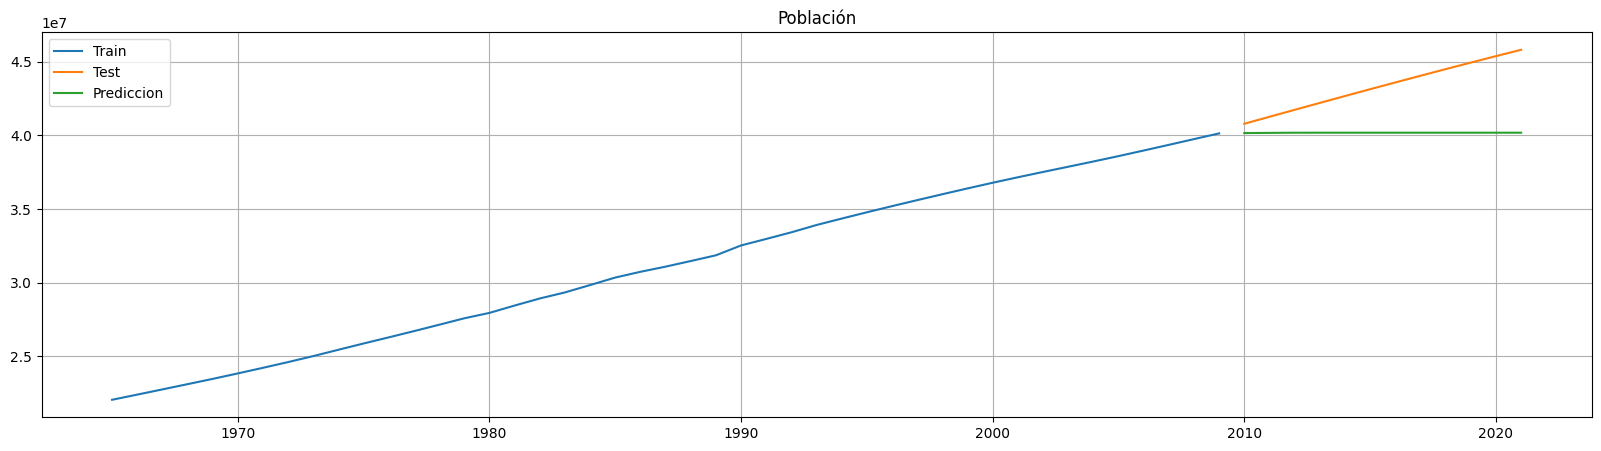

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Población'], label='Train')
plt.plot(test['Población'], label='Test')
plt.plot(forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('Población')
plt.show()

Texto con conclusiones

Utilizando box&cox para mejorar prediciones

In [ ]:
from scipy import stats
df_arg_BoxCox = df_arg.copy()

transformacion_Box_Cox = np.asarray(df_arg['Población'].values)
fitted_data, fitted_lambda = stats.boxcox(transformacion_Box_Cox)
df_arg_BoxCox['Población'] = fitted_data

df_arg_BoxCox.head()

Población
Year                     
1965-01-01  253029.505667
1966-01-01  255893.943579
1967-01-01  258781.897913
1968-01-01  261673.817584
1969-01-01  264578.137480

In [ ]:
train_cox = df_arg_BoxCox['1960-01-01':'2009-01-01']
test_cox = df_arg_BoxCox['2010-01-01':]

In [ ]:
model_cox = sm.tsa.SARIMAX(train_cox, order=order, seasonal_order=seasonal_order)
results_cox = model.fit()

print(results.summary())

predictions_cox = results_cox.get_forecast(steps=len(test_cox))

forecasted_values_cox = predictions_cox.predicted_mean
confidence_intervals = predictions_cox.conf_int()

mse = mean_squared_error(test_cox, forecasted_values_cox)
mae = mean_absolute_error(test_cox, forecasted_values_cox)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

                                     SARIMAX Results                                     
Dep. Variable:                         Población   No. Observations:                   45
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 3)   Log Likelihood               -1277.418
Date:                           Tue, 07 Nov 2023   AIC                           2560.836
Time:                                   18:12:22   BIC                           2566.188
Sample:                               01-01-1965   HQIC                          2562.821
                                    - 01-01-2009                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0292      0.001     42.950      0.000       0.028       0.031
ar.S.L3        0.0290      0.001     42.221

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TypeError: ignored

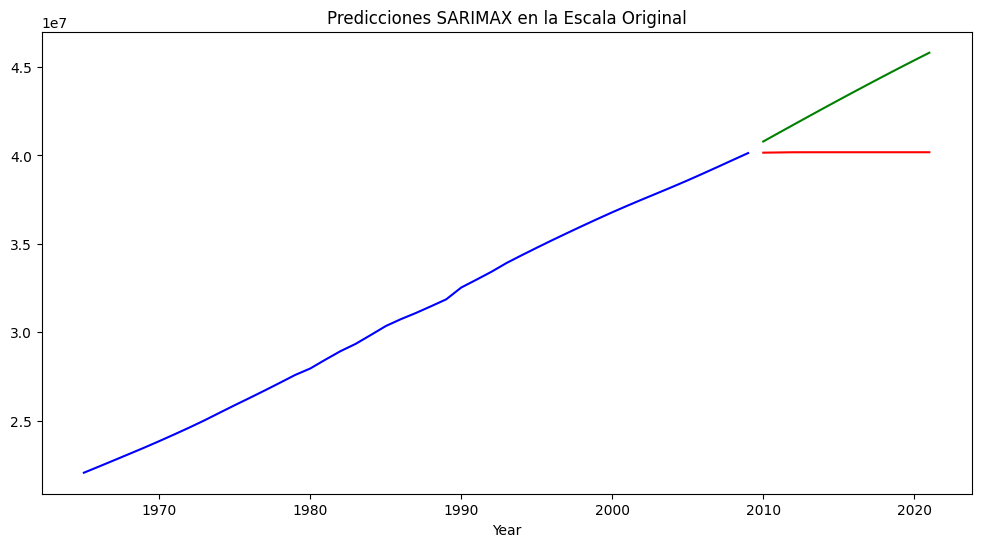

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Invertir la transformación Box-Cox en los datos de entrenamiento, prueba y predicciones
train_original = train
test_original = test
forecasted_values_original = forecasted_values_cox

# Crear un gráfico
plt.figure(figsize=(12, 6))

# Graficar el conjunto de entrenamiento en la escala original
plt.plot(train_original.index, train_original['Población'], label='Conjunto de Entrenamiento', color='blue')

# Graficar el conjunto de prueba en la escala original
plt.plot(test_original.index, test_original['Población'], label='Conjunto de Prueba', color='green')

# Graficar las predicciones en la escala original
plt.plot(test_cox.index, forecasted_values_original, label='Predicciones', color='red')

# Rellenar el área entre los intervalos de confianza en la escala original
lower_bound_original = np.exp(confidence_intervals.iloc[:, 0])
upper_bound_original = np.exp(confidence_intervals.iloc[:, 1])
plt.fill_between(test_cox.index, lower_bound_original, upper_bound_original, color='pink', alpha=0.5)

# Configurar el título y las etiquetas de los ejes
plt.title('Predicciones SARIMAX en la Escala Original')
plt.xlabel('Year')
plt.ylabel('Población')
plt.legend()

# Mostrar el gráfico
plt.show()

Punto 9: Pronostico

In [ ]:
predictions = results.get_forecast(steps=len(test))

forecasted_values = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

mse = mean_squared_error(test, forecasted_values)
mae = mean_absolute_error(test, forecasted_values)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error cuadrático medio (MSE): 12459740315942.203
Error Absoluto Medio (MAE): 3159677.6817414253


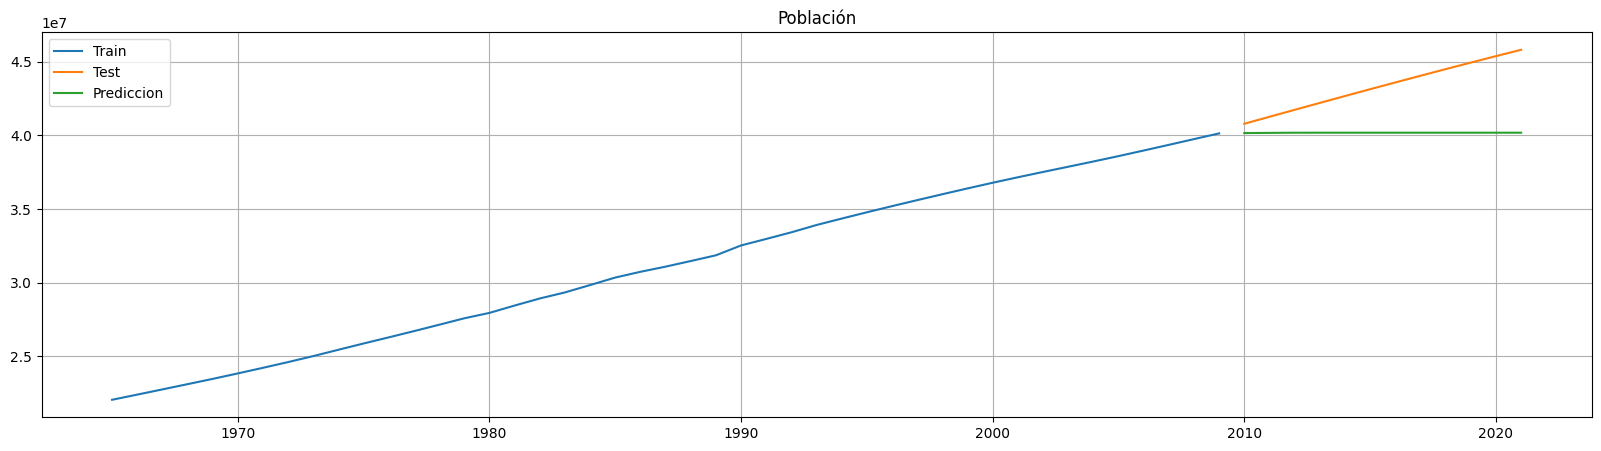

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Población'], label='Train')
plt.plot(test['Población'], label='Test')
plt.plot(forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('Población')
plt.show()



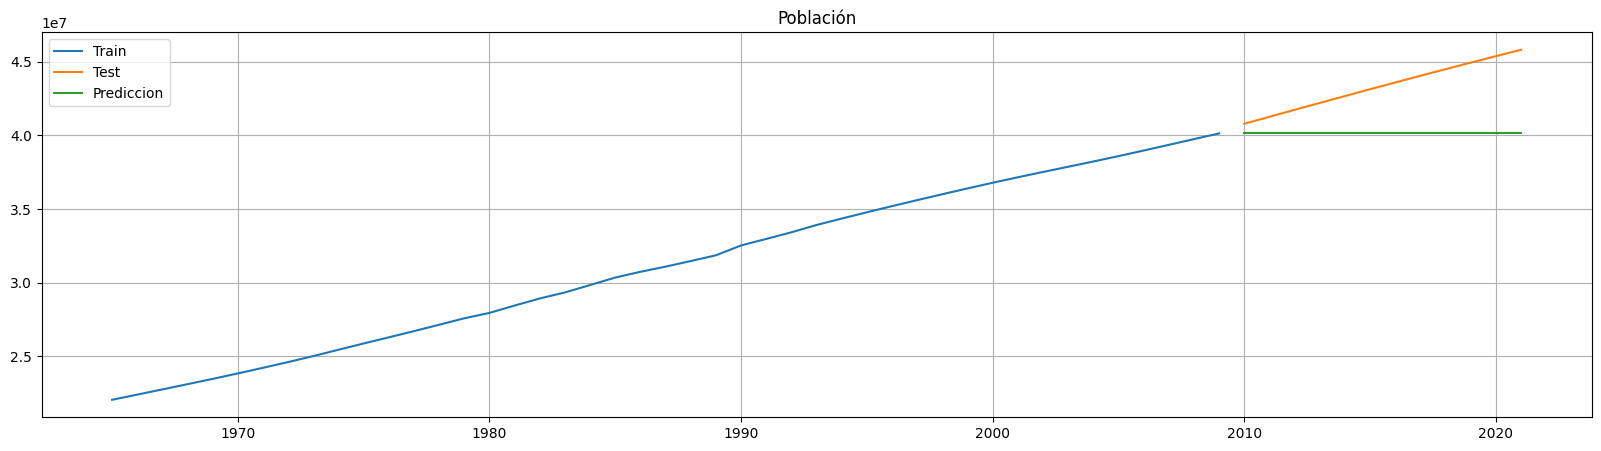

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Población'], label='Train')
plt.plot(test['Población'], label='Test')
plt.plot(auto_arima_forecasted_values, label='Prediccion')
plt.legend(loc='best')
plt.title('Población')
plt.show()